# 变量解释

Pregnancies: 怀孕次数

Glucose：葡萄糖  正常为3.92-6.16$mmol/L$

BloodPressure;血压（$mm Hg$）正常范围90-140

SkinThickness：皮脂厚度($mm$)超过20即为肥胖

Insulin：2小时血清胰岛素含量（$mu/ml$）正常人为4.03-23.46

BMI： 体重指数($kg/m^2$) BMI大于28即为肥胖

DiabetesPedigreeFunction： 遗传指数

Age; 年龄(岁）

Outcome: 标签 1：患病 0： 不患病

In [1]:
import pandas as pd
pd.set_option('precision', 3)   # 设置精度
import numpy as np
import time    # 记算运行时间
from sklearn import metrics
import matplotlib.pyplot  as plt
from sklearn.model_selection import train_test_split
from matplotlib import font_manager
plt.rcParams['font.sans-serif'] = ['SimHei']   # 中文显示问题
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from sklearn.metrics import accuracy_score  # 准确率
import warnings

warnings.filterwarnings("ignore")

In [2]:
diabetes = pd.read_csv("D:/deep-learning/datasets/diabetes.csv")
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# 标签频数观察

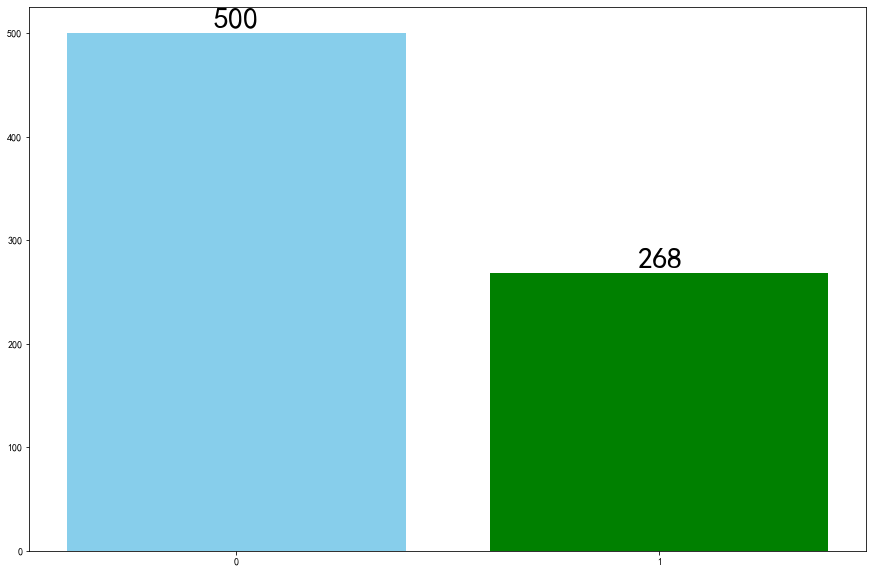

In [3]:
plt.figure(figsize = (15, 10))
label_counts = diabetes['Outcome'].value_counts()   # 统计标签频数
plt.bar(label_counts.keys(), label_counts.values, color = ['skyblue', 'g'])
plt.xticks(label_counts.keys())
for a, b in zip(label_counts.keys(), label_counts.values):
    plt.text(a, b, '%.0f'%b, ha = 'center', va = 'bottom', fontsize =30)
plt.show()

# 处理数据
## 异常值处理

In [4]:
diabetes.describe()    # 查看数据均值、标准差、最大、最小值、分位数

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241,0.349
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760,0.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000,0.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000,0.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.372,29.000,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


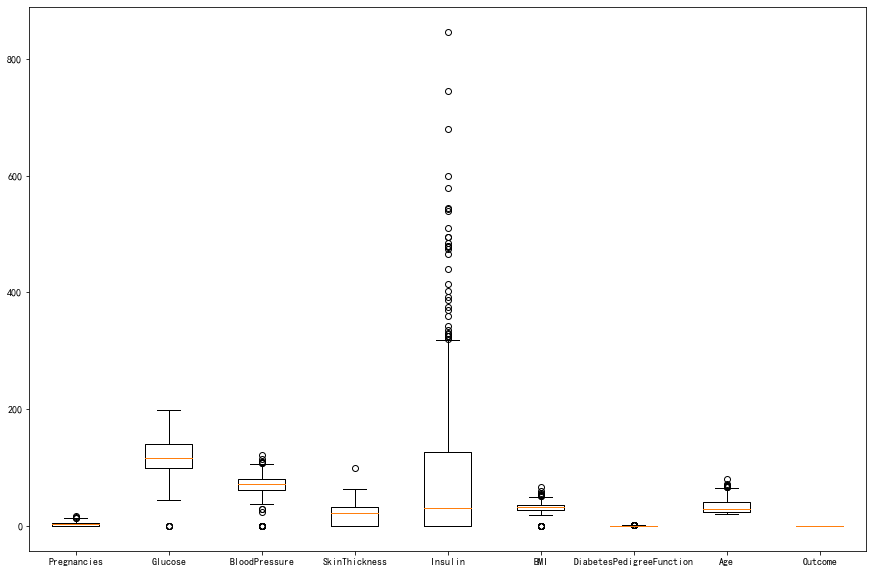

In [5]:
'''通过箱线图观察'''
plt.figure(figsize = (15, 10))
plt.boxplot(diabetes, labels = diabetes.columns)
plt.show()

3$\sigma$原则适用于服从正态分布的数据

箱线图异常值定义为小于$Q_1 - 1.5IQR$或大于$Q_3 + 1.5IQR$  $IQR = Q_3 - Q_1$

而考虑数据信息的丢失，只删除一些明显异常的值：Insulin = 846、skinthickness = 99、 BMI = 67

而怀孕次数、血压、年龄的取值是在合理范围之内，不做异常值处理。

In [6]:
'''处理异常值'''
diabetes = diabetes.loc[~diabetes['Insulin'].isin([846])]
diabetes = diabetes.loc[~diabetes['SkinThickness'].isin([99])]
diabetes = diabetes.loc[~diabetes['BMI'].isin([67.1])]
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# 缺失值处理

2小时血清胰岛素含量、葡萄糖含量、血压、皮脂厚度为0十分反常，可以认为是存在缺失值的。

以同类平均数进行填充

In [7]:
diabetes_0 = diabetes.loc[diabetes['Outcome'] == 0]
diabetes_1 = diabetes.loc[diabetes['Outcome'] == 1]
zero_mean = diabetes_0.mean()
one_mean = diabetes_1.mean()

In [8]:
for attribute in ['Insulin', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI']:
    for i in diabetes.index:
        if diabetes[attribute][i] == 0:
            if diabetes['Outcome'][i] == 0:
                diabetes[attribute][i] = zero_mean[attribute]
            else:
                diabetes[attribute][i] = one_mean[attribute] 
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,97,33.6,0.627,50,1
1,1,85,66,29,68,26.6,0.351,31,0
2,8,183,64,21,97,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,68,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,21,97,30.1,0.349,47,1


# 确认处理后数据

In [9]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,765.000,765.000,765.000,765.000,765.000,765.000,765.000,765.000,765.000
mean,3.856,121.489,72.216,26.265,117.186,32.394,0.472,33.179,0.346
std,3.371,30.299,12.058,9.425,90.227,6.778,0.332,11.697,0.476
min,0.000,44.000,24.000,7.000,14.000,18.200,0.078,21.000,0.000
25%,1.000,99.000,64.000,19.000,68.000,27.500,0.243,24.000,0.000
50%,3.000,117.000,72.000,23.000,97.000,32.000,0.371,29.000,0.000
75%,6.000,140.000,80.000,32.000,126.000,36.600,0.627,41.000,1.000
max,17.000,199.000,122.000,63.000,744.000,59.400,2.420,81.000,1.000


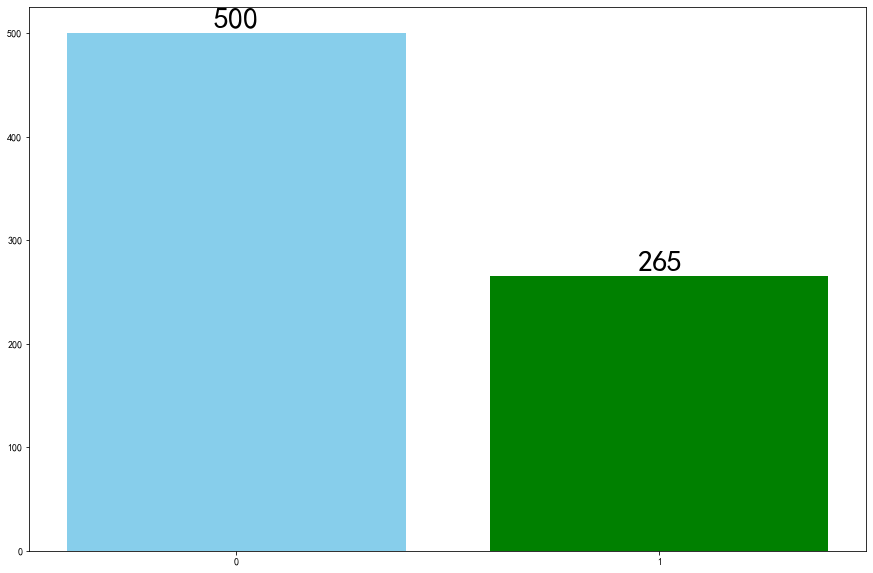

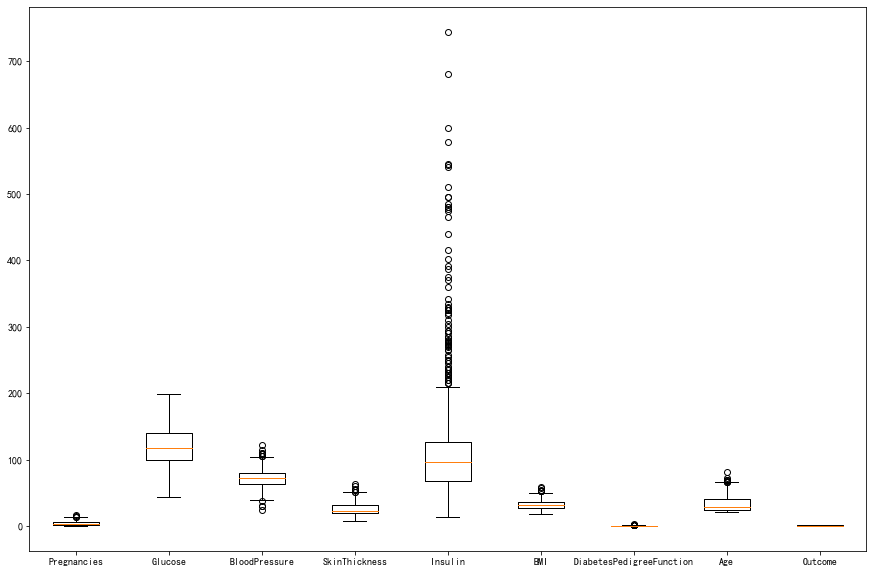

In [10]:
plt.figure(figsize = (15, 10))
label_counts = diabetes['Outcome'].value_counts()   # 统计标签频数
plt.bar(label_counts.keys(), label_counts.values, color = ['skyblue', 'g'])
plt.xticks(label_counts.keys())
for a, b in zip(label_counts.keys(), label_counts.values):
    plt.text(a, b, '%.0f'%b, ha = 'center', va = 'bottom', fontsize =30)
plt.show()
plt.figure(figsize = (15, 10))
plt.boxplot(diabetes, labels = diabetes.columns)
plt.show()

# 归一化处理
通过观察箱线图，发现各个特征之间存在明显的量纲差别，学生采用的是归一化处理，有别于标准化，能够在消除量纲影响时有效保留原数据分布特点

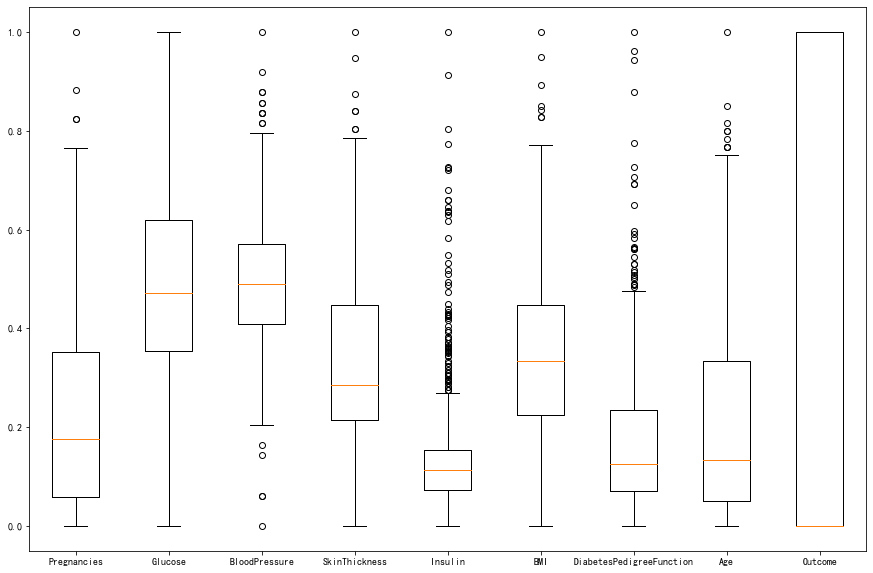

In [14]:
def MIN_MAX(X, MAX, MIN):
    X = (X - MIN) / (MAX - MIN)
    return X

for attribute in diabetes.columns:
    MAX = diabetes[attribute].max()
    MIN = diabetes[attribute].min()
    diabetes[attribute] = MIN_MAX(diabetes[attribute], MAX, MIN)
plt.figure(figsize = (15, 10))
plt.boxplot(diabetes, labels = diabetes.columns)
plt.show()

In [15]:
X = diabetes.iloc[:,:-1]
Y = diabetes.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 123457)

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# KNN

In [17]:
from sklearn.neighbors import KNeighborsClassifier
start = time.time()
avg_scores = []
all_scores = []
test_scores = []
parameter_value = list(range(1, 21))
for n_neighbors in parameter_value:
    KNN = KNeighborsClassifier(n_neighbors = n_neighbors)
    scores = cross_val_score(KNN, X_train, y_train, scoring = 'accuracy')
    KNN.fit(X_train, y_train)
    y_pre = KNN.predict(X_test)
    KNN_accuracy = accuracy_score(y_test,y_pre)
    avg_scores.append(np.mean(scores))
    all_scores.append(scores)
    test_scores.append(KNN_accuracy)
end = time.time()
print(f'KNN交叉验证调参运行时间为：{end - start:.4f}')

KNN交叉验证调参运行时间为：1.1958


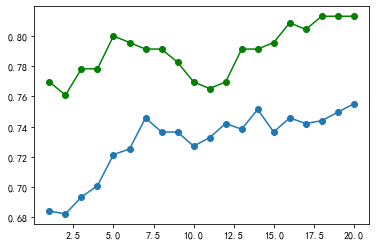

In [18]:
plt.plot(parameter_value, avg_scores, '-o')
plt.plot(parameter_value, test_scores, '-o', color = 'g')
plt.show()

In [20]:
# k = 6
KNN = KNeighborsClassifier(n_neighbors = 6)
KNN.fit(X_train, y_train)
y_pre = KNN.predict(X_test)
KNN_accuracy = accuracy_score(y_test,y_pre)
print(f'测试集准确率为：{KNN_accuracy:.4f}')
print(classification_report(y_test, y_pre))

测试集准确率为：0.7957
              precision    recall  f1-score   support

         0.0       0.80      0.92      0.86       153
         1.0       0.77      0.56      0.65        77

    accuracy                           0.80       230
   macro avg       0.79      0.74      0.75       230
weighted avg       0.79      0.80      0.79       230



准确来说，并不能画出在测试集上的正确率曲线，否则会导致测试集参与模型的训练，发生过拟合。
此处做个参考。k可取10

# 随机森林

In [21]:
from sklearn.ensemble import RandomForestClassifier
start_RT = time.time()
parameter_space = {
    'max_features': [2, 10, 'auto'],
    'n_estimators': [100, 200],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [2, 4, 6]
}
clf = RandomForestClassifier(random_state = 3)
grid_rt = GridSearchCV(clf, parameter_space)
grid_rt.fit(X_train, y_train)
end_RT = time.time()
print(f'随机森林网格搜索调整参数运行时间：{end_RT - start_RT:.4f}')

随机森林网格搜索调整参数运行时间：32.3040


In [41]:
print(f'泛化误差估计为：{grid_rt.best_score_}')
print(grid_rt.best_estimator_)

泛化误差估计为：0.8822429906542055
RandomForestClassifier(max_features=2, min_samples_leaf=2, random_state=3)


In [23]:
y_pre = grid_rt.predict(X_test)
RT_accuracy = accuracy_score(y_test, y_pre)
print(f'测试集准确率为：{RT_accuracy:.4f}')
print(classification_report(y_test, y_pre))

测试集准确率为：0.9000
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92       153
         1.0       0.84      0.87      0.85        77

    accuracy                           0.90       230
   macro avg       0.89      0.89      0.89       230
weighted avg       0.90      0.90      0.90       230



# catboost
梯度提升决策树（GBDT）的改进版，可以更好处理类别数据，并且实现类别之间的组合。

In [24]:
import catboost as cb
start_cb = time.time()
cv_parameter = {'iterations': [100, 200],
               'learning_rate': [0.1, 0.2]
               }
parameter_space = {
    'depth': 3,
    'loss_function': 'Logloss',
    'leaf_estimation_method': 'Newton',
    'random_state': 12
}
cb_model = cb.CatBoostClassifier(parameter_space)
grid_cb = GridSearchCV(cb_model, cv_parameter)
grid_cb.fit(X_train, y_train)
end_cb = time.time()
print(f'CATBOOST网格搜索调部分参数运行时间为：{end_cb - start_cb:.4f}')

0:	learn: 0.6557259	total: 68.7ms	remaining: 6.8s
1:	learn: 0.6210538	total: 70.3ms	remaining: 3.44s
2:	learn: 0.5903262	total: 72.2ms	remaining: 2.33s
3:	learn: 0.5590991	total: 73.8ms	remaining: 1.77s
4:	learn: 0.5365467	total: 75.4ms	remaining: 1.43s
5:	learn: 0.5149932	total: 76.8ms	remaining: 1.2s
6:	learn: 0.4883041	total: 78.2ms	remaining: 1.04s
7:	learn: 0.4665902	total: 79.5ms	remaining: 914ms
8:	learn: 0.4460633	total: 81.1ms	remaining: 820ms
9:	learn: 0.4331551	total: 82.4ms	remaining: 742ms
10:	learn: 0.4179631	total: 83.8ms	remaining: 678ms
11:	learn: 0.4050177	total: 85.2ms	remaining: 625ms
12:	learn: 0.3947065	total: 86.5ms	remaining: 579ms
13:	learn: 0.3841923	total: 87.9ms	remaining: 540ms
14:	learn: 0.3742609	total: 89.3ms	remaining: 506ms
15:	learn: 0.3649219	total: 90.7ms	remaining: 476ms
16:	learn: 0.3553104	total: 92.1ms	remaining: 449ms
17:	learn: 0.3447328	total: 93.4ms	remaining: 426ms
18:	learn: 0.3387281	total: 94.8ms	remaining: 404ms
19:	learn: 0.3313122	tot

91:	learn: 0.1924549	total: 142ms	remaining: 12.3ms
92:	learn: 0.1923229	total: 143ms	remaining: 10.8ms
93:	learn: 0.1921834	total: 144ms	remaining: 9.22ms
94:	learn: 0.1920309	total: 146ms	remaining: 7.68ms
95:	learn: 0.1918777	total: 147ms	remaining: 6.13ms
96:	learn: 0.1917409	total: 148ms	remaining: 4.59ms
97:	learn: 0.1915923	total: 150ms	remaining: 3.05ms
98:	learn: 0.1914542	total: 151ms	remaining: 1.52ms
99:	learn: 0.1891887	total: 152ms	remaining: 0us
0:	learn: 0.6577812	total: 4.02ms	remaining: 398ms
1:	learn: 0.6188471	total: 5.92ms	remaining: 290ms
2:	learn: 0.5926054	total: 7.91ms	remaining: 256ms
3:	learn: 0.5556402	total: 9.99ms	remaining: 240ms
4:	learn: 0.5279974	total: 11.4ms	remaining: 217ms
5:	learn: 0.5069932	total: 12.8ms	remaining: 201ms
6:	learn: 0.4805294	total: 14.2ms	remaining: 189ms
7:	learn: 0.4630073	total: 15.6ms	remaining: 179ms
8:	learn: 0.4473375	total: 17.4ms	remaining: 176ms
9:	learn: 0.4359201	total: 20ms	remaining: 180ms
10:	learn: 0.4217897	total:

85:	learn: 0.1880125	total: 140ms	remaining: 22.8ms
86:	learn: 0.1879294	total: 141ms	remaining: 21ms
87:	learn: 0.1878497	total: 142ms	remaining: 19.3ms
88:	learn: 0.1877760	total: 142ms	remaining: 17.6ms
89:	learn: 0.1876869	total: 144ms	remaining: 16ms
90:	learn: 0.1876060	total: 145ms	remaining: 14.3ms
91:	learn: 0.1875265	total: 146ms	remaining: 12.7ms
92:	learn: 0.1874785	total: 146ms	remaining: 11ms
93:	learn: 0.1863122	total: 147ms	remaining: 9.41ms
94:	learn: 0.1862356	total: 148ms	remaining: 7.8ms
95:	learn: 0.1861654	total: 149ms	remaining: 6.2ms
96:	learn: 0.1860711	total: 150ms	remaining: 4.64ms
97:	learn: 0.1860034	total: 151ms	remaining: 3.08ms
98:	learn: 0.1859278	total: 151ms	remaining: 1.53ms
99:	learn: 0.1858579	total: 152ms	remaining: 0us
0:	learn: 0.6584161	total: 1.95ms	remaining: 193ms
1:	learn: 0.6204419	total: 3.92ms	remaining: 192ms
2:	learn: 0.5966961	total: 5.85ms	remaining: 189ms
3:	learn: 0.5624670	total: 7.5ms	remaining: 180ms
4:	learn: 0.5369446	total: 9

0:	learn: 0.6326404	total: 2.36ms	remaining: 234ms
1:	learn: 0.5815905	total: 4.06ms	remaining: 199ms
2:	learn: 0.5217417	total: 5.63ms	remaining: 182ms
3:	learn: 0.4797315	total: 7.02ms	remaining: 168ms
4:	learn: 0.4414711	total: 8.35ms	remaining: 159ms
5:	learn: 0.4174166	total: 9.72ms	remaining: 152ms
6:	learn: 0.3842337	total: 11.2ms	remaining: 149ms
7:	learn: 0.3614672	total: 12.8ms	remaining: 147ms
8:	learn: 0.3420765	total: 14.3ms	remaining: 145ms
9:	learn: 0.3287924	total: 15.8ms	remaining: 143ms
10:	learn: 0.3159474	total: 17.4ms	remaining: 141ms
11:	learn: 0.3089113	total: 19.2ms	remaining: 140ms
12:	learn: 0.3013119	total: 20.5ms	remaining: 137ms
13:	learn: 0.2948642	total: 21.9ms	remaining: 135ms
14:	learn: 0.2874899	total: 23.3ms	remaining: 132ms
15:	learn: 0.2839098	total: 24.8ms	remaining: 130ms
16:	learn: 0.2783554	total: 26.2ms	remaining: 128ms
17:	learn: 0.2707671	total: 27.6ms	remaining: 126ms
18:	learn: 0.2675477	total: 29ms	remaining: 124ms
19:	learn: 0.2616054	tot

0:	learn: 0.6253173	total: 1.77ms	remaining: 176ms
1:	learn: 0.5517532	total: 3.35ms	remaining: 164ms
2:	learn: 0.5083328	total: 4.74ms	remaining: 153ms
3:	learn: 0.4635821	total: 6.21ms	remaining: 149ms
4:	learn: 0.4268815	total: 7.63ms	remaining: 145ms
5:	learn: 0.4042881	total: 8.98ms	remaining: 141ms
6:	learn: 0.3800012	total: 10.4ms	remaining: 138ms
7:	learn: 0.3627836	total: 11.8ms	remaining: 136ms
8:	learn: 0.3407354	total: 13.3ms	remaining: 134ms
9:	learn: 0.3301062	total: 14.6ms	remaining: 132ms
10:	learn: 0.3120771	total: 16.1ms	remaining: 130ms
11:	learn: 0.3031871	total: 17.6ms	remaining: 129ms
12:	learn: 0.2957659	total: 19.1ms	remaining: 128ms
13:	learn: 0.2869627	total: 20.7ms	remaining: 127ms
14:	learn: 0.2765989	total: 22.1ms	remaining: 126ms
15:	learn: 0.2691710	total: 23.5ms	remaining: 123ms
16:	learn: 0.2615824	total: 25ms	remaining: 122ms
17:	learn: 0.2544101	total: 26.7ms	remaining: 122ms
18:	learn: 0.2479191	total: 28.3ms	remaining: 121ms
19:	learn: 0.2414900	tot

0:	learn: 0.6054690	total: 4.42ms	remaining: 879ms
1:	learn: 0.5355677	total: 6.3ms	remaining: 624ms
2:	learn: 0.4829406	total: 7.95ms	remaining: 522ms
3:	learn: 0.4406140	total: 9.57ms	remaining: 469ms
4:	learn: 0.3942392	total: 11.3ms	remaining: 442ms
5:	learn: 0.3610492	total: 13ms	remaining: 421ms
6:	learn: 0.3285319	total: 14.7ms	remaining: 407ms
7:	learn: 0.3086158	total: 16.6ms	remaining: 398ms
8:	learn: 0.2963999	total: 18.6ms	remaining: 394ms
9:	learn: 0.2865903	total: 20.3ms	remaining: 385ms
10:	learn: 0.2707853	total: 21.9ms	remaining: 377ms
11:	learn: 0.2564794	total: 23.6ms	remaining: 370ms
12:	learn: 0.2436769	total: 25.3ms	remaining: 364ms
13:	learn: 0.2330724	total: 27.2ms	remaining: 362ms
14:	learn: 0.2274745	total: 29ms	remaining: 358ms
15:	learn: 0.2211206	total: 30.7ms	remaining: 353ms
16:	learn: 0.2147366	total: 32.4ms	remaining: 349ms
17:	learn: 0.2107444	total: 34.1ms	remaining: 345ms
18:	learn: 0.2055869	total: 35.8ms	remaining: 341ms
19:	learn: 0.2002167	total:

187:	learn: 0.0213570	total: 335ms	remaining: 21.4ms
188:	learn: 0.0212453	total: 337ms	remaining: 19.6ms
189:	learn: 0.0210275	total: 339ms	remaining: 17.8ms
190:	learn: 0.0207219	total: 341ms	remaining: 16.1ms
191:	learn: 0.0205932	total: 343ms	remaining: 14.3ms
192:	learn: 0.0205796	total: 344ms	remaining: 12.5ms
193:	learn: 0.0205657	total: 346ms	remaining: 10.7ms
194:	learn: 0.0204638	total: 348ms	remaining: 8.92ms
195:	learn: 0.0203015	total: 350ms	remaining: 7.14ms
196:	learn: 0.0201653	total: 353ms	remaining: 5.37ms
197:	learn: 0.0200203	total: 354ms	remaining: 3.58ms
198:	learn: 0.0198777	total: 356ms	remaining: 1.79ms
199:	learn: 0.0195358	total: 358ms	remaining: 0us
0:	learn: 0.6137792	total: 2.77ms	remaining: 552ms
1:	learn: 0.5506170	total: 4.61ms	remaining: 456ms
2:	learn: 0.4997804	total: 6.37ms	remaining: 418ms
3:	learn: 0.4525104	total: 8.13ms	remaining: 398ms
4:	learn: 0.4035371	total: 9.77ms	remaining: 381ms
5:	learn: 0.3713011	total: 11.5ms	remaining: 370ms
6:	learn

186:	learn: 0.0218687	total: 331ms	remaining: 23ms
187:	learn: 0.0215748	total: 333ms	remaining: 21.2ms
188:	learn: 0.0214742	total: 334ms	remaining: 19.5ms
189:	learn: 0.0213357	total: 336ms	remaining: 17.7ms
190:	learn: 0.0210905	total: 338ms	remaining: 15.9ms
191:	learn: 0.0210767	total: 339ms	remaining: 14.1ms
192:	learn: 0.0209305	total: 341ms	remaining: 12.4ms
193:	learn: 0.0208853	total: 343ms	remaining: 10.6ms
194:	learn: 0.0208312	total: 344ms	remaining: 8.83ms
195:	learn: 0.0205756	total: 347ms	remaining: 7.08ms
196:	learn: 0.0205512	total: 349ms	remaining: 5.31ms
197:	learn: 0.0204139	total: 350ms	remaining: 3.54ms
198:	learn: 0.0203958	total: 352ms	remaining: 1.77ms
199:	learn: 0.0203836	total: 354ms	remaining: 0us
0:	learn: 0.6065567	total: 2.11ms	remaining: 419ms
1:	learn: 0.5370861	total: 4.05ms	remaining: 401ms
2:	learn: 0.4857387	total: 5.88ms	remaining: 386ms
3:	learn: 0.4228485	total: 7.66ms	remaining: 375ms
4:	learn: 0.3792985	total: 9.36ms	remaining: 365ms
5:	learn

187:	learn: 0.0209615	total: 329ms	remaining: 21ms
188:	learn: 0.0208263	total: 331ms	remaining: 19.3ms
189:	learn: 0.0205596	total: 333ms	remaining: 17.5ms
190:	learn: 0.0203548	total: 335ms	remaining: 15.8ms
191:	learn: 0.0202039	total: 336ms	remaining: 14ms
192:	learn: 0.0200682	total: 338ms	remaining: 12.3ms
193:	learn: 0.0197701	total: 340ms	remaining: 10.5ms
194:	learn: 0.0196788	total: 342ms	remaining: 8.76ms
195:	learn: 0.0193487	total: 343ms	remaining: 7.01ms
196:	learn: 0.0191992	total: 346ms	remaining: 5.27ms
197:	learn: 0.0189406	total: 348ms	remaining: 3.51ms
198:	learn: 0.0188595	total: 350ms	remaining: 1.76ms
199:	learn: 0.0186202	total: 351ms	remaining: 0us
0:	learn: 0.6088186	total: 2.09ms	remaining: 417ms
1:	learn: 0.5432810	total: 3.98ms	remaining: 395ms
2:	learn: 0.4935566	total: 6.02ms	remaining: 395ms
3:	learn: 0.4381458	total: 7.83ms	remaining: 384ms
4:	learn: 0.3960665	total: 9.92ms	remaining: 387ms
5:	learn: 0.3640100	total: 11.7ms	remaining: 378ms
6:	learn: 0.

179:	learn: 0.0226139	total: 321ms	remaining: 35.7ms
180:	learn: 0.0223672	total: 324ms	remaining: 34ms
181:	learn: 0.0219730	total: 326ms	remaining: 32.2ms
182:	learn: 0.0217532	total: 327ms	remaining: 30.4ms
183:	learn: 0.0214274	total: 329ms	remaining: 28.6ms
184:	learn: 0.0211831	total: 331ms	remaining: 26.8ms
185:	learn: 0.0210114	total: 333ms	remaining: 25ms
186:	learn: 0.0209537	total: 335ms	remaining: 23.3ms
187:	learn: 0.0207581	total: 337ms	remaining: 21.5ms
188:	learn: 0.0206710	total: 339ms	remaining: 19.7ms
189:	learn: 0.0204009	total: 341ms	remaining: 17.9ms
190:	learn: 0.0203715	total: 342ms	remaining: 16.1ms
191:	learn: 0.0201488	total: 343ms	remaining: 14.3ms
192:	learn: 0.0198289	total: 345ms	remaining: 12.5ms
193:	learn: 0.0196801	total: 347ms	remaining: 10.7ms
194:	learn: 0.0194865	total: 349ms	remaining: 8.95ms
195:	learn: 0.0193105	total: 351ms	remaining: 7.16ms
196:	learn: 0.0192709	total: 352ms	remaining: 5.36ms
197:	learn: 0.0192198	total: 353ms	remaining: 3.57

189:	learn: 0.0178857	total: 337ms	remaining: 17.8ms
190:	learn: 0.0177905	total: 339ms	remaining: 16ms
191:	learn: 0.0177162	total: 341ms	remaining: 14.2ms
192:	learn: 0.0174560	total: 342ms	remaining: 12.4ms
193:	learn: 0.0172817	total: 344ms	remaining: 10.6ms
194:	learn: 0.0170831	total: 345ms	remaining: 8.86ms
195:	learn: 0.0168485	total: 347ms	remaining: 7.08ms
196:	learn: 0.0166597	total: 349ms	remaining: 5.31ms
197:	learn: 0.0165510	total: 350ms	remaining: 3.54ms
198:	learn: 0.0163450	total: 353ms	remaining: 1.77ms
199:	learn: 0.0163100	total: 354ms	remaining: 0us
0:	learn: 0.5350545	total: 2.12ms	remaining: 422ms
1:	learn: 0.4416422	total: 4.65ms	remaining: 460ms
2:	learn: 0.3895036	total: 6.66ms	remaining: 438ms
3:	learn: 0.3336202	total: 8.43ms	remaining: 413ms
4:	learn: 0.2877314	total: 10.1ms	remaining: 393ms
5:	learn: 0.2649966	total: 11.9ms	remaining: 385ms
6:	learn: 0.2504473	total: 13.6ms	remaining: 375ms
7:	learn: 0.2306101	total: 15.3ms	remaining: 366ms
8:	learn: 0.22

184:	learn: 0.0086945	total: 337ms	remaining: 27.3ms
185:	learn: 0.0086754	total: 338ms	remaining: 25.5ms
186:	learn: 0.0086439	total: 340ms	remaining: 23.6ms
187:	learn: 0.0085598	total: 342ms	remaining: 21.8ms
188:	learn: 0.0084980	total: 343ms	remaining: 20ms
189:	learn: 0.0084403	total: 345ms	remaining: 18.2ms
190:	learn: 0.0083858	total: 347ms	remaining: 16.3ms
191:	learn: 0.0083212	total: 348ms	remaining: 14.5ms
192:	learn: 0.0081818	total: 350ms	remaining: 12.7ms
193:	learn: 0.0080576	total: 352ms	remaining: 10.9ms
194:	learn: 0.0079457	total: 354ms	remaining: 9.09ms
195:	learn: 0.0078749	total: 356ms	remaining: 7.27ms
196:	learn: 0.0078633	total: 358ms	remaining: 5.45ms
197:	learn: 0.0078215	total: 359ms	remaining: 3.63ms
198:	learn: 0.0077545	total: 361ms	remaining: 1.81ms
199:	learn: 0.0076729	total: 363ms	remaining: 0us
0:	learn: 0.5494324	total: 2.72ms	remaining: 541ms
1:	learn: 0.4564301	total: 4.91ms	remaining: 486ms
2:	learn: 0.3751776	total: 6.89ms	remaining: 453ms
3:	l

190:	learn: 0.0076437	total: 338ms	remaining: 15.9ms
191:	learn: 0.0076391	total: 340ms	remaining: 14.2ms
192:	learn: 0.0075980	total: 342ms	remaining: 12.4ms
193:	learn: 0.0075905	total: 343ms	remaining: 10.6ms
194:	learn: 0.0075820	total: 345ms	remaining: 8.85ms
195:	learn: 0.0075743	total: 347ms	remaining: 7.08ms
196:	learn: 0.0074927	total: 348ms	remaining: 5.3ms
197:	learn: 0.0073945	total: 350ms	remaining: 3.54ms
198:	learn: 0.0073405	total: 352ms	remaining: 1.77ms
199:	learn: 0.0072728	total: 355ms	remaining: 0us
0:	learn: 0.5364128	total: 3.62ms	remaining: 721ms
1:	learn: 0.4429927	total: 5.53ms	remaining: 547ms
2:	learn: 0.3670437	total: 7.32ms	remaining: 480ms
3:	learn: 0.3133613	total: 9.38ms	remaining: 460ms
4:	learn: 0.2706715	total: 11.2ms	remaining: 436ms
5:	learn: 0.2534075	total: 13.2ms	remaining: 428ms
6:	learn: 0.2369043	total: 15ms	remaining: 413ms
7:	learn: 0.2195719	total: 17.1ms	remaining: 411ms
8:	learn: 0.2133035	total: 18.8ms	remaining: 400ms
9:	learn: 0.20496

189:	learn: 0.0081743	total: 335ms	remaining: 17.6ms
190:	learn: 0.0081663	total: 337ms	remaining: 15.9ms
191:	learn: 0.0080386	total: 339ms	remaining: 14.1ms
192:	learn: 0.0080196	total: 341ms	remaining: 12.4ms
193:	learn: 0.0079270	total: 343ms	remaining: 10.6ms
194:	learn: 0.0079172	total: 344ms	remaining: 8.83ms
195:	learn: 0.0078360	total: 346ms	remaining: 7.06ms
196:	learn: 0.0078338	total: 348ms	remaining: 5.29ms
197:	learn: 0.0078336	total: 350ms	remaining: 3.53ms
198:	learn: 0.0078335	total: 352ms	remaining: 1.77ms
199:	learn: 0.0078316	total: 354ms	remaining: 0us
0:	learn: 0.5402952	total: 2.23ms	remaining: 443ms
1:	learn: 0.4286227	total: 3.96ms	remaining: 392ms
2:	learn: 0.3712501	total: 5.8ms	remaining: 381ms
3:	learn: 0.3059937	total: 7.62ms	remaining: 373ms
4:	learn: 0.2712759	total: 9.39ms	remaining: 366ms
5:	learn: 0.2389649	total: 11.1ms	remaining: 359ms
6:	learn: 0.2275765	total: 12.8ms	remaining: 354ms
7:	learn: 0.2176405	total: 15.4ms	remaining: 370ms
8:	learn: 0.2

193:	learn: 0.0075372	total: 348ms	remaining: 10.8ms
194:	learn: 0.0075197	total: 350ms	remaining: 8.99ms
195:	learn: 0.0074331	total: 352ms	remaining: 7.19ms
196:	learn: 0.0073477	total: 354ms	remaining: 5.39ms
197:	learn: 0.0073058	total: 356ms	remaining: 3.59ms
198:	learn: 0.0072523	total: 357ms	remaining: 1.79ms
199:	learn: 0.0072462	total: 359ms	remaining: 0us
0:	learn: 0.5339180	total: 2.15ms	remaining: 428ms
1:	learn: 0.4283901	total: 4.14ms	remaining: 410ms
2:	learn: 0.3757627	total: 6.38ms	remaining: 419ms
3:	learn: 0.3195276	total: 8.2ms	remaining: 402ms
4:	learn: 0.2795633	total: 9.88ms	remaining: 385ms
5:	learn: 0.2640059	total: 11.5ms	remaining: 373ms
6:	learn: 0.2412017	total: 13.4ms	remaining: 371ms
7:	learn: 0.2215272	total: 15.2ms	remaining: 365ms
8:	learn: 0.2156236	total: 16.9ms	remaining: 358ms
9:	learn: 0.2084913	total: 18.6ms	remaining: 354ms
10:	learn: 0.2002075	total: 20.3ms	remaining: 350ms
11:	learn: 0.1863765	total: 22ms	remaining: 345ms
12:	learn: 0.1809017	

183:	learn: 0.0062175	total: 330ms	remaining: 28.7ms
184:	learn: 0.0061531	total: 331ms	remaining: 26.9ms
185:	learn: 0.0061371	total: 333ms	remaining: 25.1ms
186:	learn: 0.0060873	total: 335ms	remaining: 23.3ms
187:	learn: 0.0060577	total: 336ms	remaining: 21.5ms
188:	learn: 0.0060573	total: 338ms	remaining: 19.7ms
189:	learn: 0.0060277	total: 340ms	remaining: 17.9ms
190:	learn: 0.0060104	total: 341ms	remaining: 16.1ms
191:	learn: 0.0059936	total: 343ms	remaining: 14.3ms
192:	learn: 0.0059808	total: 345ms	remaining: 12.5ms
193:	learn: 0.0059654	total: 347ms	remaining: 10.7ms
194:	learn: 0.0059510	total: 349ms	remaining: 8.94ms
195:	learn: 0.0059345	total: 350ms	remaining: 7.15ms
196:	learn: 0.0058695	total: 352ms	remaining: 5.36ms
197:	learn: 0.0057887	total: 353ms	remaining: 3.57ms
198:	learn: 0.0057734	total: 355ms	remaining: 1.78ms
199:	learn: 0.0057414	total: 357ms	remaining: 0us
0:	learn: 0.6486404	total: 1.89ms	remaining: 187ms
1:	learn: 0.6113378	total: 3.5ms	remaining: 172ms
2

In [42]:
print(f'泛化误差估计为：{grid_cb.best_score_}')
print(grid_cb.best_estimator_)

泛化误差估计为：0.8785046728971964


In [26]:
y_pre = grid_cb.predict(X_test)
cb_accuracy = accuracy_score(y_test, y_pre)
print(f'测试集准确率;{cb_accuracy:.4f}')
print(classification_report(y_test, y_pre))

测试集准确率;0.8913
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92       153
         1.0       0.82      0.86      0.84        77

    accuracy                           0.89       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.89      0.89      0.89       230



# SVM

In [28]:
from sklearn.svm import SVC
start_svr = time.time()
parameters = {'kernel':('linear', 'rbf'), 'C': [0.1, 1, 10]}
svr = SVC()
grid_svc = GridSearchCV(svr, parameters)
grid_svc.fit(X_train, y_train)
end_svr = time.time()
print(f'SVM网格搜索调参的运行时间为：{end_svr - start_svr : .4f}')

SVM网格搜索调参的运行时间为： 0.2783


In [43]:
print(f'泛化误差估计为：{grid_svc.best_score_}')
print(grid_svc.best_estimator_)

泛化误差估计为：0.7514018691588785
SVC(C=1, kernel='linear')


In [30]:
y_pre = grid_svc.predict(X_test)
svc_accuracy = accuracy_score(y_test, y_pre)
print(f'测试集准确率：{svc_accuracy:.4f}')
print(classification_report(y_test, y_pre))

测试集准确率：0.8000
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86       153
         1.0       0.78      0.56      0.65        77

    accuracy                           0.80       230
   macro avg       0.79      0.74      0.76       230
weighted avg       0.80      0.80      0.79       230



# voting

In [40]:
from mlxtend.classifier import EnsembleVoteClassifier

start_vote = time.time()
KNN = KNeighborsClassifier(n_neighbors = 6)
clf = RandomForestClassifier(max_features = 2, min_samples_leaf = 2, random_state = 3)
svr = SVC(C=10, kernel='linear', probability = True)
eclf = EnsembleVoteClassifier(clfs = [grid_cb, clf, svr], voting = 'soft')
params_weights = {
    'weights': [[1, 1, 1],
               [1, 2, 1]]
}

grid_eclf = GridSearchCV(eclf, params_weights)
grid_eclf.fit(X_train, y_train)
end_vote = time.time()
print(f'voting法运行时间为： {end_vote - start_vote : .4f}')

0:	learn: 0.6596188	total: 1.89ms	remaining: 187ms
1:	learn: 0.6198877	total: 3.76ms	remaining: 184ms
2:	learn: 0.5951625	total: 5.34ms	remaining: 173ms
3:	learn: 0.5683874	total: 6.84ms	remaining: 164ms
4:	learn: 0.5445265	total: 8.32ms	remaining: 158ms
5:	learn: 0.5245257	total: 9.77ms	remaining: 153ms
6:	learn: 0.5046171	total: 11.3ms	remaining: 150ms
7:	learn: 0.4849275	total: 13ms	remaining: 150ms
8:	learn: 0.4664366	total: 15.2ms	remaining: 154ms
9:	learn: 0.4549582	total: 16.8ms	remaining: 151ms
10:	learn: 0.4427903	total: 18.1ms	remaining: 146ms
11:	learn: 0.4333116	total: 19.4ms	remaining: 142ms
12:	learn: 0.4225515	total: 21ms	remaining: 140ms
13:	learn: 0.4131399	total: 22.5ms	remaining: 138ms
14:	learn: 0.4034235	total: 23.9ms	remaining: 135ms
15:	learn: 0.3945216	total: 25.2ms	remaining: 132ms
16:	learn: 0.3840594	total: 26.7ms	remaining: 130ms
17:	learn: 0.3742012	total: 28.2ms	remaining: 129ms
18:	learn: 0.3675878	total: 29.6ms	remaining: 126ms
19:	learn: 0.3588400	total

0:	learn: 0.6557154	total: 2.54ms	remaining: 251ms
1:	learn: 0.6193965	total: 4.38ms	remaining: 215ms
2:	learn: 0.5823148	total: 5.79ms	remaining: 187ms
3:	learn: 0.5540035	total: 7.21ms	remaining: 173ms
4:	learn: 0.5345657	total: 8.69ms	remaining: 165ms
5:	learn: 0.5153281	total: 10.1ms	remaining: 158ms
6:	learn: 0.4876030	total: 11.4ms	remaining: 152ms
7:	learn: 0.4687362	total: 12.8ms	remaining: 147ms
8:	learn: 0.4525019	total: 14.2ms	remaining: 143ms
9:	learn: 0.4327993	total: 15.6ms	remaining: 140ms
10:	learn: 0.4131176	total: 17ms	remaining: 137ms
11:	learn: 0.3992216	total: 18.4ms	remaining: 135ms
12:	learn: 0.3896350	total: 20ms	remaining: 134ms
13:	learn: 0.3803172	total: 21.4ms	remaining: 131ms
14:	learn: 0.3671390	total: 22.8ms	remaining: 129ms
15:	learn: 0.3588248	total: 24.3ms	remaining: 127ms
16:	learn: 0.3494282	total: 25.6ms	remaining: 125ms
17:	learn: 0.3403269	total: 27ms	remaining: 123ms
18:	learn: 0.3312818	total: 28.4ms	remaining: 121ms
19:	learn: 0.3242821	total: 

92:	learn: 0.1717112	total: 146ms	remaining: 11ms
93:	learn: 0.1699994	total: 147ms	remaining: 9.37ms
94:	learn: 0.1699241	total: 148ms	remaining: 7.79ms
95:	learn: 0.1692495	total: 149ms	remaining: 6.22ms
96:	learn: 0.1691792	total: 150ms	remaining: 4.65ms
97:	learn: 0.1681766	total: 152ms	remaining: 3.09ms
98:	learn: 0.1681020	total: 153ms	remaining: 1.54ms
99:	learn: 0.1665929	total: 154ms	remaining: 0us
0:	learn: 0.6542517	total: 2.02ms	remaining: 200ms
1:	learn: 0.6172572	total: 3.55ms	remaining: 174ms
2:	learn: 0.5875637	total: 5.26ms	remaining: 170ms
3:	learn: 0.5629205	total: 6.89ms	remaining: 165ms
4:	learn: 0.5413011	total: 9.05ms	remaining: 172ms
5:	learn: 0.5217718	total: 11.6ms	remaining: 181ms
6:	learn: 0.5011604	total: 14.4ms	remaining: 191ms
7:	learn: 0.4824535	total: 16ms	remaining: 184ms
8:	learn: 0.4653181	total: 17.3ms	remaining: 175ms
9:	learn: 0.4541136	total: 18.7ms	remaining: 168ms
10:	learn: 0.4398312	total: 20ms	remaining: 162ms
11:	learn: 0.4278313	total: 21.

0:	learn: 0.6258058	total: 2.09ms	remaining: 207ms
1:	learn: 0.5719575	total: 4ms	remaining: 196ms
2:	learn: 0.5216515	total: 5.42ms	remaining: 175ms
3:	learn: 0.4742620	total: 6.78ms	remaining: 163ms
4:	learn: 0.4418629	total: 8.34ms	remaining: 158ms
5:	learn: 0.4163392	total: 9.76ms	remaining: 153ms
6:	learn: 0.3919377	total: 11.1ms	remaining: 148ms
7:	learn: 0.3729325	total: 12.7ms	remaining: 146ms
8:	learn: 0.3545279	total: 14ms	remaining: 142ms
9:	learn: 0.3378774	total: 15.6ms	remaining: 141ms
10:	learn: 0.3204422	total: 17ms	remaining: 138ms
11:	learn: 0.3119323	total: 18.3ms	remaining: 134ms
12:	learn: 0.3038882	total: 20.1ms	remaining: 135ms
13:	learn: 0.2924626	total: 21.6ms	remaining: 133ms
14:	learn: 0.2811735	total: 23ms	remaining: 130ms
15:	learn: 0.2740683	total: 24.4ms	remaining: 128ms
16:	learn: 0.2674308	total: 25.8ms	remaining: 126ms
17:	learn: 0.2611068	total: 27.3ms	remaining: 124ms
18:	learn: 0.2564225	total: 29ms	remaining: 123ms
19:	learn: 0.2526378	total: 30.3m

0:	learn: 0.6304385	total: 1.87ms	remaining: 185ms
1:	learn: 0.5802994	total: 3.46ms	remaining: 170ms
2:	learn: 0.5224209	total: 5.13ms	remaining: 166ms
3:	learn: 0.4817593	total: 6.61ms	remaining: 159ms
4:	learn: 0.4486832	total: 8.08ms	remaining: 154ms
5:	learn: 0.4224863	total: 9.42ms	remaining: 148ms
6:	learn: 0.3983873	total: 10.8ms	remaining: 143ms
7:	learn: 0.3755538	total: 12.1ms	remaining: 139ms
8:	learn: 0.3613659	total: 13.5ms	remaining: 137ms
9:	learn: 0.3466367	total: 14.9ms	remaining: 134ms
10:	learn: 0.3335430	total: 16.2ms	remaining: 131ms
11:	learn: 0.3246197	total: 17.9ms	remaining: 132ms
12:	learn: 0.3160517	total: 19.4ms	remaining: 130ms
13:	learn: 0.3068110	total: 21.1ms	remaining: 130ms
14:	learn: 0.2978843	total: 22.7ms	remaining: 129ms
15:	learn: 0.2918339	total: 24.3ms	remaining: 127ms
16:	learn: 0.2816213	total: 25.7ms	remaining: 126ms
17:	learn: 0.2736598	total: 27.6ms	remaining: 126ms
18:	learn: 0.2685874	total: 29.3ms	remaining: 125ms
19:	learn: 0.2623474	t

91:	learn: 0.0958570	total: 145ms	remaining: 12.6ms
92:	learn: 0.0957949	total: 147ms	remaining: 11ms
93:	learn: 0.0954733	total: 148ms	remaining: 9.43ms
94:	learn: 0.0953782	total: 150ms	remaining: 7.88ms
95:	learn: 0.0945410	total: 151ms	remaining: 6.3ms
96:	learn: 0.0943933	total: 152ms	remaining: 4.71ms
97:	learn: 0.0934622	total: 154ms	remaining: 3.13ms
98:	learn: 0.0926543	total: 155ms	remaining: 1.56ms
99:	learn: 0.0919307	total: 156ms	remaining: 0us
0:	learn: 0.6101310	total: 2.72ms	remaining: 541ms
1:	learn: 0.5454104	total: 4.68ms	remaining: 463ms
2:	learn: 0.4985593	total: 6.75ms	remaining: 443ms
3:	learn: 0.4403926	total: 8.92ms	remaining: 437ms
4:	learn: 0.4090175	total: 11.3ms	remaining: 441ms
5:	learn: 0.3756982	total: 13.4ms	remaining: 432ms
6:	learn: 0.3499170	total: 15.1ms	remaining: 415ms
7:	learn: 0.3232798	total: 17.3ms	remaining: 416ms
8:	learn: 0.3018357	total: 19.1ms	remaining: 406ms
9:	learn: 0.2895790	total: 21ms	remaining: 399ms
10:	learn: 0.2751151	total: 23

163:	learn: 0.0206278	total: 308ms	remaining: 67.6ms
164:	learn: 0.0205047	total: 310ms	remaining: 65.7ms
165:	learn: 0.0203289	total: 312ms	remaining: 63.9ms
166:	learn: 0.0202225	total: 314ms	remaining: 62.1ms
167:	learn: 0.0199729	total: 316ms	remaining: 60.2ms
168:	learn: 0.0198791	total: 318ms	remaining: 58.3ms
169:	learn: 0.0196095	total: 319ms	remaining: 56.4ms
170:	learn: 0.0195098	total: 322ms	remaining: 54.5ms
171:	learn: 0.0193638	total: 323ms	remaining: 52.6ms
172:	learn: 0.0191242	total: 325ms	remaining: 50.7ms
173:	learn: 0.0189669	total: 327ms	remaining: 48.8ms
174:	learn: 0.0187675	total: 328ms	remaining: 46.9ms
175:	learn: 0.0186026	total: 330ms	remaining: 45ms
176:	learn: 0.0183762	total: 331ms	remaining: 43.1ms
177:	learn: 0.0181929	total: 334ms	remaining: 41.3ms
178:	learn: 0.0179616	total: 336ms	remaining: 39.4ms
179:	learn: 0.0178571	total: 337ms	remaining: 37.5ms
180:	learn: 0.0177179	total: 339ms	remaining: 35.6ms
181:	learn: 0.0176157	total: 340ms	remaining: 33

189:	learn: 0.0176704	total: 328ms	remaining: 17.3ms
190:	learn: 0.0175119	total: 330ms	remaining: 15.5ms
191:	learn: 0.0173394	total: 331ms	remaining: 13.8ms
192:	learn: 0.0170778	total: 333ms	remaining: 12.1ms
193:	learn: 0.0169222	total: 334ms	remaining: 10.3ms
194:	learn: 0.0167271	total: 336ms	remaining: 8.61ms
195:	learn: 0.0166494	total: 338ms	remaining: 6.89ms
196:	learn: 0.0164602	total: 339ms	remaining: 5.16ms
197:	learn: 0.0163506	total: 341ms	remaining: 3.44ms
198:	learn: 0.0162531	total: 342ms	remaining: 1.72ms
199:	learn: 0.0160964	total: 344ms	remaining: 0us
0:	learn: 0.6031337	total: 2.37ms	remaining: 471ms
1:	learn: 0.5289697	total: 4.49ms	remaining: 444ms
2:	learn: 0.4803052	total: 6.45ms	remaining: 424ms
3:	learn: 0.4287066	total: 8.2ms	remaining: 402ms
4:	learn: 0.3904743	total: 10.7ms	remaining: 419ms
5:	learn: 0.3487229	total: 13.4ms	remaining: 432ms
6:	learn: 0.3126082	total: 15.5ms	remaining: 426ms
7:	learn: 0.2885588	total: 18.5ms	remaining: 445ms
8:	learn: 0.2

179:	learn: 0.0170125	total: 325ms	remaining: 36.1ms
180:	learn: 0.0169706	total: 327ms	remaining: 34.3ms
181:	learn: 0.0168236	total: 329ms	remaining: 32.5ms
182:	learn: 0.0165747	total: 330ms	remaining: 30.7ms
183:	learn: 0.0165235	total: 332ms	remaining: 28.8ms
184:	learn: 0.0164803	total: 333ms	remaining: 27ms
185:	learn: 0.0162963	total: 334ms	remaining: 25.2ms
186:	learn: 0.0160495	total: 336ms	remaining: 23.4ms
187:	learn: 0.0158670	total: 338ms	remaining: 21.6ms
188:	learn: 0.0158172	total: 340ms	remaining: 19.8ms
189:	learn: 0.0155778	total: 342ms	remaining: 18ms
190:	learn: 0.0155487	total: 343ms	remaining: 16.2ms
191:	learn: 0.0153491	total: 345ms	remaining: 14.4ms
192:	learn: 0.0151696	total: 348ms	remaining: 12.6ms
193:	learn: 0.0151530	total: 350ms	remaining: 10.8ms
194:	learn: 0.0150714	total: 352ms	remaining: 9.02ms
195:	learn: 0.0150611	total: 354ms	remaining: 7.22ms
196:	learn: 0.0150358	total: 356ms	remaining: 5.42ms
197:	learn: 0.0150099	total: 358ms	remaining: 3.62

197:	learn: 0.0160965	total: 322ms	remaining: 3.25ms
198:	learn: 0.0159330	total: 324ms	remaining: 1.63ms
199:	learn: 0.0158763	total: 326ms	remaining: 0us
0:	learn: 0.5965441	total: 2.17ms	remaining: 433ms
1:	learn: 0.5245817	total: 5.05ms	remaining: 500ms
2:	learn: 0.4813996	total: 7.72ms	remaining: 507ms
3:	learn: 0.4246013	total: 10.2ms	remaining: 502ms
4:	learn: 0.3775060	total: 13.1ms	remaining: 510ms
5:	learn: 0.3521628	total: 15.1ms	remaining: 488ms
6:	learn: 0.3219860	total: 16.9ms	remaining: 465ms
7:	learn: 0.2998211	total: 19.3ms	remaining: 463ms
8:	learn: 0.2842642	total: 21.3ms	remaining: 452ms
9:	learn: 0.2763572	total: 23.2ms	remaining: 440ms
10:	learn: 0.2663430	total: 25.6ms	remaining: 440ms
11:	learn: 0.2501755	total: 28.2ms	remaining: 442ms
12:	learn: 0.2389557	total: 31.2ms	remaining: 448ms
13:	learn: 0.2273344	total: 33.7ms	remaining: 448ms
14:	learn: 0.2217681	total: 35.9ms	remaining: 443ms
15:	learn: 0.2136359	total: 38.3ms	remaining: 440ms
16:	learn: 0.2066940	t

162:	learn: 0.0169808	total: 313ms	remaining: 71.1ms
163:	learn: 0.0168308	total: 316ms	remaining: 69.4ms
164:	learn: 0.0167543	total: 318ms	remaining: 67.4ms
165:	learn: 0.0166584	total: 319ms	remaining: 65.4ms
166:	learn: 0.0165709	total: 321ms	remaining: 63.5ms
167:	learn: 0.0163298	total: 323ms	remaining: 61.5ms
168:	learn: 0.0161551	total: 324ms	remaining: 59.5ms
169:	learn: 0.0160850	total: 326ms	remaining: 57.5ms
170:	learn: 0.0159778	total: 328ms	remaining: 55.5ms
171:	learn: 0.0158277	total: 329ms	remaining: 53.6ms
172:	learn: 0.0156353	total: 331ms	remaining: 51.7ms
173:	learn: 0.0155166	total: 333ms	remaining: 49.8ms
174:	learn: 0.0154520	total: 336ms	remaining: 48ms
175:	learn: 0.0152020	total: 338ms	remaining: 46.2ms
176:	learn: 0.0150405	total: 340ms	remaining: 44.2ms
177:	learn: 0.0148224	total: 342ms	remaining: 42.3ms
178:	learn: 0.0147646	total: 343ms	remaining: 40.3ms
179:	learn: 0.0145735	total: 345ms	remaining: 38.3ms
180:	learn: 0.0144531	total: 347ms	remaining: 36

171:	learn: 0.0072375	total: 307ms	remaining: 50ms
172:	learn: 0.0072313	total: 308ms	remaining: 48.1ms
173:	learn: 0.0071871	total: 310ms	remaining: 46.3ms
174:	learn: 0.0071304	total: 312ms	remaining: 44.5ms
175:	learn: 0.0070470	total: 313ms	remaining: 42.7ms
176:	learn: 0.0069625	total: 315ms	remaining: 40.9ms
177:	learn: 0.0069142	total: 317ms	remaining: 39.1ms
178:	learn: 0.0068466	total: 319ms	remaining: 37.4ms
179:	learn: 0.0067750	total: 320ms	remaining: 35.6ms
180:	learn: 0.0067186	total: 322ms	remaining: 33.8ms
181:	learn: 0.0067165	total: 324ms	remaining: 32.1ms
182:	learn: 0.0066872	total: 326ms	remaining: 30.3ms
183:	learn: 0.0066377	total: 327ms	remaining: 28.5ms
184:	learn: 0.0065617	total: 329ms	remaining: 26.7ms
185:	learn: 0.0065401	total: 330ms	remaining: 24.9ms
186:	learn: 0.0064464	total: 332ms	remaining: 23.1ms
187:	learn: 0.0063741	total: 333ms	remaining: 21.3ms
188:	learn: 0.0063547	total: 335ms	remaining: 19.5ms
189:	learn: 0.0063356	total: 337ms	remaining: 17

184:	learn: 0.0066311	total: 324ms	remaining: 26.3ms
185:	learn: 0.0065962	total: 326ms	remaining: 24.5ms
186:	learn: 0.0065053	total: 327ms	remaining: 22.8ms
187:	learn: 0.0064861	total: 329ms	remaining: 21ms
188:	learn: 0.0064589	total: 330ms	remaining: 19.2ms
189:	learn: 0.0063837	total: 332ms	remaining: 17.5ms
190:	learn: 0.0063455	total: 333ms	remaining: 15.7ms
191:	learn: 0.0063253	total: 336ms	remaining: 14ms
192:	learn: 0.0063158	total: 337ms	remaining: 12.2ms
193:	learn: 0.0062203	total: 339ms	remaining: 10.5ms
194:	learn: 0.0061859	total: 341ms	remaining: 8.75ms
195:	learn: 0.0061631	total: 344ms	remaining: 7.02ms
196:	learn: 0.0061461	total: 345ms	remaining: 5.26ms
197:	learn: 0.0060839	total: 347ms	remaining: 3.51ms
198:	learn: 0.0060732	total: 349ms	remaining: 1.75ms
199:	learn: 0.0060689	total: 351ms	remaining: 0us
0:	learn: 0.5298272	total: 2.03ms	remaining: 404ms
1:	learn: 0.4280286	total: 3.86ms	remaining: 382ms
2:	learn: 0.3712985	total: 5.76ms	remaining: 378ms
3:	lea

187:	learn: 0.0057481	total: 330ms	remaining: 21.1ms
188:	learn: 0.0056908	total: 333ms	remaining: 19.4ms
189:	learn: 0.0056908	total: 335ms	remaining: 17.6ms
190:	learn: 0.0056908	total: 336ms	remaining: 15.8ms
191:	learn: 0.0056391	total: 338ms	remaining: 14.1ms
192:	learn: 0.0056391	total: 339ms	remaining: 12.3ms
193:	learn: 0.0055685	total: 342ms	remaining: 10.6ms
194:	learn: 0.0055685	total: 343ms	remaining: 8.8ms
195:	learn: 0.0055685	total: 346ms	remaining: 7.05ms
196:	learn: 0.0055574	total: 348ms	remaining: 5.29ms
197:	learn: 0.0055430	total: 349ms	remaining: 3.53ms
198:	learn: 0.0055430	total: 351ms	remaining: 1.77ms
199:	learn: 0.0055099	total: 354ms	remaining: 0us
0:	learn: 0.5304120	total: 2.32ms	remaining: 462ms
1:	learn: 0.4433639	total: 4.51ms	remaining: 447ms
2:	learn: 0.3942385	total: 6.2ms	remaining: 407ms
3:	learn: 0.3314200	total: 7.9ms	remaining: 387ms
4:	learn: 0.3057245	total: 9.53ms	remaining: 372ms
5:	learn: 0.2854805	total: 11.4ms	remaining: 369ms
6:	learn: 0

188:	learn: 0.0066271	total: 328ms	remaining: 19.1ms
189:	learn: 0.0065630	total: 330ms	remaining: 17.3ms
190:	learn: 0.0064736	total: 331ms	remaining: 15.6ms
191:	learn: 0.0064297	total: 333ms	remaining: 13.9ms
192:	learn: 0.0063905	total: 334ms	remaining: 12.1ms
193:	learn: 0.0063390	total: 336ms	remaining: 10.4ms
194:	learn: 0.0063080	total: 338ms	remaining: 8.65ms
195:	learn: 0.0062558	total: 339ms	remaining: 6.92ms
196:	learn: 0.0062521	total: 341ms	remaining: 5.19ms
197:	learn: 0.0061810	total: 343ms	remaining: 3.46ms
198:	learn: 0.0061460	total: 345ms	remaining: 1.73ms
199:	learn: 0.0061297	total: 348ms	remaining: 0us
0:	learn: 0.5195908	total: 2.36ms	remaining: 470ms
1:	learn: 0.4260758	total: 4.2ms	remaining: 416ms
2:	learn: 0.3836678	total: 5.86ms	remaining: 385ms
3:	learn: 0.3197623	total: 7.59ms	remaining: 372ms
4:	learn: 0.2685034	total: 9.23ms	remaining: 360ms
5:	learn: 0.2479318	total: 10.9ms	remaining: 351ms
6:	learn: 0.2248750	total: 12.5ms	remaining: 344ms
7:	learn: 0

187:	learn: 0.0055120	total: 329ms	remaining: 21ms
188:	learn: 0.0054960	total: 331ms	remaining: 19.3ms
189:	learn: 0.0054959	total: 333ms	remaining: 17.5ms
190:	learn: 0.0054959	total: 334ms	remaining: 15.8ms
191:	learn: 0.0054959	total: 336ms	remaining: 14ms
192:	learn: 0.0054959	total: 338ms	remaining: 12.2ms
193:	learn: 0.0054958	total: 339ms	remaining: 10.5ms
194:	learn: 0.0054715	total: 341ms	remaining: 8.73ms
195:	learn: 0.0054488	total: 342ms	remaining: 6.99ms
196:	learn: 0.0054318	total: 344ms	remaining: 5.24ms
197:	learn: 0.0054316	total: 346ms	remaining: 3.49ms
198:	learn: 0.0054316	total: 348ms	remaining: 1.75ms
199:	learn: 0.0054235	total: 350ms	remaining: 0us
0:	learn: 0.5350545	total: 2.5ms	remaining: 498ms
1:	learn: 0.4416422	total: 4.46ms	remaining: 442ms
2:	learn: 0.3895036	total: 6.64ms	remaining: 436ms
3:	learn: 0.3336202	total: 9.75ms	remaining: 478ms
4:	learn: 0.2877314	total: 11.6ms	remaining: 453ms
5:	learn: 0.2649966	total: 13.3ms	remaining: 430ms
6:	learn: 0.2

182:	learn: 0.0088176	total: 329ms	remaining: 30.6ms
183:	learn: 0.0088006	total: 331ms	remaining: 28.8ms
184:	learn: 0.0086945	total: 333ms	remaining: 27ms
185:	learn: 0.0086754	total: 334ms	remaining: 25.2ms
186:	learn: 0.0086439	total: 336ms	remaining: 23.3ms
187:	learn: 0.0085598	total: 337ms	remaining: 21.5ms
188:	learn: 0.0084980	total: 339ms	remaining: 19.7ms
189:	learn: 0.0084403	total: 341ms	remaining: 17.9ms
190:	learn: 0.0083858	total: 343ms	remaining: 16.1ms
191:	learn: 0.0083212	total: 345ms	remaining: 14.4ms
192:	learn: 0.0081818	total: 347ms	remaining: 12.6ms
193:	learn: 0.0080576	total: 348ms	remaining: 10.8ms
194:	learn: 0.0079457	total: 350ms	remaining: 8.97ms
195:	learn: 0.0078749	total: 352ms	remaining: 7.17ms
196:	learn: 0.0078633	total: 353ms	remaining: 5.38ms
197:	learn: 0.0078215	total: 355ms	remaining: 3.59ms
198:	learn: 0.0077545	total: 357ms	remaining: 1.79ms
199:	learn: 0.0076729	total: 358ms	remaining: 0us
0:	learn: 0.6623749	total: 1.92ms	remaining: 190ms


0:	learn: 0.6635320	total: 1.87ms	remaining: 185ms
1:	learn: 0.6199565	total: 3.55ms	remaining: 174ms
2:	learn: 0.5886765	total: 4.93ms	remaining: 160ms
3:	learn: 0.5673195	total: 6.26ms	remaining: 150ms
4:	learn: 0.5409109	total: 7.6ms	remaining: 144ms
5:	learn: 0.5202030	total: 8.93ms	remaining: 140ms
6:	learn: 0.4952648	total: 10.3ms	remaining: 137ms
7:	learn: 0.4722956	total: 12ms	remaining: 138ms
8:	learn: 0.4518407	total: 13.5ms	remaining: 137ms
9:	learn: 0.4397663	total: 15.1ms	remaining: 136ms
10:	learn: 0.4186087	total: 16.4ms	remaining: 133ms
11:	learn: 0.4034633	total: 17.8ms	remaining: 130ms
12:	learn: 0.3937905	total: 19.1ms	remaining: 128ms
13:	learn: 0.3814615	total: 20.5ms	remaining: 126ms
14:	learn: 0.3681746	total: 21.8ms	remaining: 124ms
15:	learn: 0.3585575	total: 23.2ms	remaining: 122ms
16:	learn: 0.3497123	total: 24.6ms	remaining: 120ms
17:	learn: 0.3416202	total: 26.3ms	remaining: 120ms
18:	learn: 0.3350706	total: 27.6ms	remaining: 118ms
19:	learn: 0.3258952	tota

0:	learn: 0.6624051	total: 1.81ms	remaining: 180ms
1:	learn: 0.6340420	total: 3.22ms	remaining: 158ms
2:	learn: 0.6007889	total: 4.55ms	remaining: 147ms
3:	learn: 0.5772534	total: 6.28ms	remaining: 151ms
4:	learn: 0.5517805	total: 7.71ms	remaining: 147ms
5:	learn: 0.5279412	total: 9.07ms	remaining: 142ms
6:	learn: 0.5080927	total: 10.5ms	remaining: 139ms
7:	learn: 0.4885491	total: 11.9ms	remaining: 137ms
8:	learn: 0.4663144	total: 13.2ms	remaining: 134ms
9:	learn: 0.4516497	total: 14.6ms	remaining: 131ms
10:	learn: 0.4378611	total: 15.9ms	remaining: 129ms
11:	learn: 0.4255882	total: 17.3ms	remaining: 127ms
12:	learn: 0.4161495	total: 18.7ms	remaining: 125ms
13:	learn: 0.4033901	total: 20.1ms	remaining: 123ms
14:	learn: 0.3936118	total: 21.5ms	remaining: 122ms
15:	learn: 0.3837592	total: 23.3ms	remaining: 122ms
16:	learn: 0.3738750	total: 24.6ms	remaining: 120ms
17:	learn: 0.3625807	total: 26ms	remaining: 118ms
18:	learn: 0.3549326	total: 27.6ms	remaining: 118ms
19:	learn: 0.3478683	tot

0:	learn: 0.6351874	total: 2.15ms	remaining: 212ms
1:	learn: 0.5742914	total: 3.92ms	remaining: 192ms
2:	learn: 0.5359874	total: 5.45ms	remaining: 176ms
3:	learn: 0.5111870	total: 6.85ms	remaining: 164ms
4:	learn: 0.4699250	total: 8.23ms	remaining: 156ms
5:	learn: 0.4409285	total: 9.58ms	remaining: 150ms
6:	learn: 0.4166437	total: 11ms	remaining: 146ms
7:	learn: 0.3882003	total: 12.4ms	remaining: 142ms
8:	learn: 0.3613401	total: 13.8ms	remaining: 139ms
9:	learn: 0.3471235	total: 15.1ms	remaining: 136ms
10:	learn: 0.3326652	total: 16.6ms	remaining: 134ms
11:	learn: 0.3237289	total: 18ms	remaining: 132ms
12:	learn: 0.3149615	total: 19.2ms	remaining: 129ms
13:	learn: 0.3019017	total: 20.6ms	remaining: 126ms
14:	learn: 0.2941668	total: 21.9ms	remaining: 124ms
15:	learn: 0.2873657	total: 23.2ms	remaining: 122ms
16:	learn: 0.2796408	total: 24.6ms	remaining: 120ms
17:	learn: 0.2741262	total: 26.1ms	remaining: 119ms
18:	learn: 0.2689265	total: 27.7ms	remaining: 118ms
19:	learn: 0.2635591	total

0:	learn: 0.6217148	total: 1.76ms	remaining: 174ms
1:	learn: 0.5746154	total: 3.29ms	remaining: 161ms
2:	learn: 0.5242181	total: 4.64ms	remaining: 150ms
3:	learn: 0.5014839	total: 6.1ms	remaining: 146ms
4:	learn: 0.4643692	total: 7.51ms	remaining: 143ms
5:	learn: 0.4387630	total: 8.97ms	remaining: 141ms
6:	learn: 0.4188756	total: 10.5ms	remaining: 140ms
7:	learn: 0.3940301	total: 11.8ms	remaining: 136ms
8:	learn: 0.3765965	total: 13.3ms	remaining: 135ms
9:	learn: 0.3653534	total: 14.8ms	remaining: 133ms
10:	learn: 0.3450085	total: 16.6ms	remaining: 134ms
11:	learn: 0.3349631	total: 18ms	remaining: 132ms
12:	learn: 0.3267830	total: 19.4ms	remaining: 129ms
13:	learn: 0.3097281	total: 20.7ms	remaining: 127ms
14:	learn: 0.2997578	total: 22.2ms	remaining: 126ms
15:	learn: 0.2918201	total: 23.6ms	remaining: 124ms
16:	learn: 0.2833750	total: 24.9ms	remaining: 121ms
17:	learn: 0.2725874	total: 26.2ms	remaining: 119ms
18:	learn: 0.2682916	total: 27.5ms	remaining: 117ms
19:	learn: 0.2610794	tota

0:	learn: 0.6110769	total: 2.17ms	remaining: 432ms
1:	learn: 0.5380081	total: 4.01ms	remaining: 397ms
2:	learn: 0.4889605	total: 6.04ms	remaining: 397ms
3:	learn: 0.4306936	total: 7.78ms	remaining: 381ms
4:	learn: 0.3992341	total: 9.47ms	remaining: 369ms
5:	learn: 0.3685498	total: 11.2ms	remaining: 363ms
6:	learn: 0.3401260	total: 13ms	remaining: 360ms
7:	learn: 0.3156883	total: 14.9ms	remaining: 357ms
8:	learn: 0.2987869	total: 16.6ms	remaining: 353ms
9:	learn: 0.2853846	total: 18.3ms	remaining: 347ms
10:	learn: 0.2708455	total: 20.1ms	remaining: 345ms
11:	learn: 0.2582976	total: 22.3ms	remaining: 349ms
12:	learn: 0.2498824	total: 24.3ms	remaining: 350ms
13:	learn: 0.2386232	total: 26.3ms	remaining: 349ms
14:	learn: 0.2315138	total: 28ms	remaining: 346ms
15:	learn: 0.2211825	total: 29.7ms	remaining: 342ms
16:	learn: 0.2183087	total: 31.4ms	remaining: 338ms
17:	learn: 0.2120088	total: 33ms	remaining: 334ms
18:	learn: 0.2051424	total: 34.8ms	remaining: 332ms
19:	learn: 0.2044490	total: 

183:	learn: 0.0185530	total: 330ms	remaining: 28.7ms
184:	learn: 0.0184944	total: 332ms	remaining: 26.9ms
185:	learn: 0.0184180	total: 334ms	remaining: 25.2ms
186:	learn: 0.0183971	total: 336ms	remaining: 23.4ms
187:	learn: 0.0183771	total: 338ms	remaining: 21.6ms
188:	learn: 0.0183614	total: 340ms	remaining: 19.8ms
189:	learn: 0.0183029	total: 342ms	remaining: 18ms
190:	learn: 0.0182880	total: 344ms	remaining: 16.2ms
191:	learn: 0.0182277	total: 346ms	remaining: 14.4ms
192:	learn: 0.0182123	total: 348ms	remaining: 12.6ms
193:	learn: 0.0181537	total: 350ms	remaining: 10.8ms
194:	learn: 0.0180196	total: 353ms	remaining: 9.05ms
195:	learn: 0.0180050	total: 355ms	remaining: 7.25ms
196:	learn: 0.0178416	total: 357ms	remaining: 5.44ms
197:	learn: 0.0177407	total: 359ms	remaining: 3.63ms
198:	learn: 0.0175601	total: 361ms	remaining: 1.81ms
199:	learn: 0.0172387	total: 363ms	remaining: 0us
0:	learn: 0.6059812	total: 2.17ms	remaining: 432ms
1:	learn: 0.5442722	total: 4.07ms	remaining: 403ms
2:

184:	learn: 0.0231113	total: 328ms	remaining: 26.6ms
185:	learn: 0.0227100	total: 330ms	remaining: 24.8ms
186:	learn: 0.0226720	total: 331ms	remaining: 23ms
187:	learn: 0.0224072	total: 333ms	remaining: 21.2ms
188:	learn: 0.0223113	total: 334ms	remaining: 19.5ms
189:	learn: 0.0222355	total: 336ms	remaining: 17.7ms
190:	learn: 0.0217243	total: 337ms	remaining: 15.9ms
191:	learn: 0.0214595	total: 339ms	remaining: 14.1ms
192:	learn: 0.0214052	total: 341ms	remaining: 12.4ms
193:	learn: 0.0210641	total: 343ms	remaining: 10.6ms
194:	learn: 0.0210181	total: 345ms	remaining: 8.85ms
195:	learn: 0.0209724	total: 347ms	remaining: 7.08ms
196:	learn: 0.0206847	total: 348ms	remaining: 5.3ms
197:	learn: 0.0204264	total: 350ms	remaining: 3.53ms
198:	learn: 0.0201617	total: 351ms	remaining: 1.76ms
199:	learn: 0.0197479	total: 353ms	remaining: 0us
0:	learn: 0.6113061	total: 2.23ms	remaining: 445ms
1:	learn: 0.5188348	total: 4.54ms	remaining: 449ms
2:	learn: 0.4676432	total: 6.7ms	remaining: 440ms
3:	lea

197:	learn: 0.0125598	total: 334ms	remaining: 3.38ms
198:	learn: 0.0125532	total: 335ms	remaining: 1.68ms
199:	learn: 0.0123179	total: 337ms	remaining: 0us
0:	learn: 0.5941600	total: 2.96ms	remaining: 589ms
1:	learn: 0.5369024	total: 4.63ms	remaining: 458ms
2:	learn: 0.4967527	total: 6.49ms	remaining: 426ms
3:	learn: 0.4378066	total: 9.05ms	remaining: 443ms
4:	learn: 0.3958663	total: 10.9ms	remaining: 426ms
5:	learn: 0.3682556	total: 12.6ms	remaining: 407ms
6:	learn: 0.3471621	total: 14.2ms	remaining: 392ms
7:	learn: 0.3264475	total: 16ms	remaining: 384ms
8:	learn: 0.3146046	total: 17.7ms	remaining: 376ms
9:	learn: 0.2941644	total: 19.6ms	remaining: 372ms
10:	learn: 0.2796391	total: 21.2ms	remaining: 365ms
11:	learn: 0.2662263	total: 23.6ms	remaining: 369ms
12:	learn: 0.2570473	total: 25.5ms	remaining: 367ms
13:	learn: 0.2444683	total: 27.5ms	remaining: 365ms
14:	learn: 0.2364207	total: 29.4ms	remaining: 363ms
15:	learn: 0.2297868	total: 31.5ms	remaining: 363ms
16:	learn: 0.2219588	tot

0:	learn: 0.6110340	total: 2.57ms	remaining: 512ms
1:	learn: 0.5381440	total: 4.39ms	remaining: 435ms
2:	learn: 0.4953807	total: 6.18ms	remaining: 406ms
3:	learn: 0.4332049	total: 7.89ms	remaining: 387ms
4:	learn: 0.3943767	total: 9.57ms	remaining: 373ms
5:	learn: 0.3603084	total: 11.4ms	remaining: 367ms
6:	learn: 0.3403478	total: 13.3ms	remaining: 367ms
7:	learn: 0.3185987	total: 15.2ms	remaining: 365ms
8:	learn: 0.3032142	total: 17ms	remaining: 360ms
9:	learn: 0.2806789	total: 18.6ms	remaining: 354ms
10:	learn: 0.2747037	total: 20.4ms	remaining: 351ms
11:	learn: 0.2634804	total: 22.3ms	remaining: 350ms
12:	learn: 0.2553967	total: 24ms	remaining: 345ms
13:	learn: 0.2418704	total: 25.6ms	remaining: 340ms
14:	learn: 0.2352032	total: 27.8ms	remaining: 343ms
15:	learn: 0.2287212	total: 29.8ms	remaining: 343ms
16:	learn: 0.2198014	total: 31.6ms	remaining: 340ms
17:	learn: 0.2143038	total: 33.3ms	remaining: 337ms
18:	learn: 0.2104300	total: 35ms	remaining: 333ms
19:	learn: 0.2092886	total: 

189:	learn: 0.0149447	total: 334ms	remaining: 17.6ms
190:	learn: 0.0148993	total: 336ms	remaining: 15.8ms
191:	learn: 0.0146612	total: 338ms	remaining: 14.1ms
192:	learn: 0.0145300	total: 339ms	remaining: 12.3ms
193:	learn: 0.0143896	total: 341ms	remaining: 10.5ms
194:	learn: 0.0142187	total: 343ms	remaining: 8.78ms
195:	learn: 0.0141138	total: 344ms	remaining: 7.03ms
196:	learn: 0.0140940	total: 346ms	remaining: 5.27ms
197:	learn: 0.0139243	total: 348ms	remaining: 3.52ms
198:	learn: 0.0138282	total: 350ms	remaining: 1.76ms
199:	learn: 0.0138167	total: 352ms	remaining: 0us
0:	learn: 0.5434994	total: 2.36ms	remaining: 470ms
1:	learn: 0.4407020	total: 4.72ms	remaining: 467ms
2:	learn: 0.4035861	total: 7.15ms	remaining: 469ms
3:	learn: 0.3300899	total: 9.09ms	remaining: 445ms
4:	learn: 0.2904428	total: 11.3ms	remaining: 441ms
5:	learn: 0.2630458	total: 13.7ms	remaining: 442ms
6:	learn: 0.2440539	total: 15.7ms	remaining: 434ms
7:	learn: 0.2258549	total: 17.5ms	remaining: 419ms
8:	learn: 0.

192:	learn: 0.0070893	total: 336ms	remaining: 12.2ms
193:	learn: 0.0070065	total: 338ms	remaining: 10.5ms
194:	learn: 0.0069944	total: 340ms	remaining: 8.71ms
195:	learn: 0.0069943	total: 341ms	remaining: 6.97ms
196:	learn: 0.0069900	total: 343ms	remaining: 5.22ms
197:	learn: 0.0069900	total: 345ms	remaining: 3.48ms
198:	learn: 0.0069636	total: 346ms	remaining: 1.74ms
199:	learn: 0.0069604	total: 348ms	remaining: 0us
0:	learn: 0.5346755	total: 2.48ms	remaining: 494ms
1:	learn: 0.4385429	total: 4.58ms	remaining: 453ms
2:	learn: 0.3874542	total: 6.66ms	remaining: 438ms
3:	learn: 0.3211731	total: 8.47ms	remaining: 415ms
4:	learn: 0.2916088	total: 10.1ms	remaining: 394ms
5:	learn: 0.2686971	total: 12ms	remaining: 389ms
6:	learn: 0.2547026	total: 13.8ms	remaining: 381ms
7:	learn: 0.2401777	total: 15.8ms	remaining: 380ms
8:	learn: 0.2362092	total: 17.5ms	remaining: 372ms
9:	learn: 0.2259755	total: 19.2ms	remaining: 365ms
10:	learn: 0.2149877	total: 21ms	remaining: 361ms
11:	learn: 0.2073192	

187:	learn: 0.0085423	total: 338ms	remaining: 21.6ms
188:	learn: 0.0085015	total: 340ms	remaining: 19.8ms
189:	learn: 0.0084173	total: 342ms	remaining: 18ms
190:	learn: 0.0083524	total: 344ms	remaining: 16.2ms
191:	learn: 0.0082248	total: 346ms	remaining: 14.4ms
192:	learn: 0.0081812	total: 347ms	remaining: 12.6ms
193:	learn: 0.0080264	total: 349ms	remaining: 10.8ms
194:	learn: 0.0080056	total: 351ms	remaining: 9ms
195:	learn: 0.0079995	total: 353ms	remaining: 7.2ms
196:	learn: 0.0079840	total: 356ms	remaining: 5.42ms
197:	learn: 0.0079709	total: 358ms	remaining: 3.61ms
198:	learn: 0.0079178	total: 360ms	remaining: 1.81ms
199:	learn: 0.0078838	total: 363ms	remaining: 0us
0:	learn: 0.5438455	total: 2.61ms	remaining: 520ms
1:	learn: 0.4098557	total: 4.51ms	remaining: 447ms
2:	learn: 0.3471480	total: 6.3ms	remaining: 414ms
3:	learn: 0.2975790	total: 8.17ms	remaining: 400ms
4:	learn: 0.2611075	total: 10ms	remaining: 391ms
5:	learn: 0.2436950	total: 11.7ms	remaining: 380ms
6:	learn: 0.22576

191:	learn: 0.0062122	total: 314ms	remaining: 13.1ms
192:	learn: 0.0062088	total: 315ms	remaining: 11.4ms
193:	learn: 0.0061747	total: 317ms	remaining: 9.79ms
194:	learn: 0.0061360	total: 318ms	remaining: 8.16ms
195:	learn: 0.0061360	total: 320ms	remaining: 6.53ms
196:	learn: 0.0061326	total: 321ms	remaining: 4.88ms
197:	learn: 0.0060681	total: 322ms	remaining: 3.25ms
198:	learn: 0.0059593	total: 324ms	remaining: 1.63ms
199:	learn: 0.0058897	total: 325ms	remaining: 0us
0:	learn: 0.5141991	total: 2.06ms	remaining: 410ms
1:	learn: 0.4358359	total: 3.75ms	remaining: 371ms
2:	learn: 0.3864541	total: 5.38ms	remaining: 353ms
3:	learn: 0.3209107	total: 7.4ms	remaining: 363ms
4:	learn: 0.2776823	total: 9.29ms	remaining: 363ms
5:	learn: 0.2591893	total: 11.1ms	remaining: 358ms
6:	learn: 0.2402359	total: 12.8ms	remaining: 354ms
7:	learn: 0.2253124	total: 15.2ms	remaining: 366ms
8:	learn: 0.2161533	total: 16.8ms	remaining: 357ms
9:	learn: 0.2073423	total: 18.4ms	remaining: 350ms
10:	learn: 0.1960

194:	learn: 0.0067755	total: 333ms	remaining: 8.55ms
195:	learn: 0.0067616	total: 335ms	remaining: 6.84ms
196:	learn: 0.0066507	total: 337ms	remaining: 5.13ms
197:	learn: 0.0066367	total: 338ms	remaining: 3.42ms
198:	learn: 0.0066276	total: 340ms	remaining: 1.71ms
199:	learn: 0.0066258	total: 341ms	remaining: 0us
0:	learn: 0.5432907	total: 2.04ms	remaining: 407ms
1:	learn: 0.4355519	total: 3.88ms	remaining: 384ms
2:	learn: 0.3915601	total: 5.95ms	remaining: 391ms
3:	learn: 0.3179587	total: 8.03ms	remaining: 394ms
4:	learn: 0.2721370	total: 9.73ms	remaining: 380ms
5:	learn: 0.2549185	total: 11.5ms	remaining: 372ms
6:	learn: 0.2391917	total: 13.2ms	remaining: 364ms
7:	learn: 0.2251911	total: 14.8ms	remaining: 356ms
8:	learn: 0.2154542	total: 16.6ms	remaining: 352ms
9:	learn: 0.1920237	total: 18.3ms	remaining: 347ms
10:	learn: 0.1868628	total: 20ms	remaining: 344ms
11:	learn: 0.1715777	total: 21.7ms	remaining: 340ms
12:	learn: 0.1675371	total: 23.3ms	remaining: 335ms
13:	learn: 0.1606202	

187:	learn: 0.0056767	total: 328ms	remaining: 21ms
188:	learn: 0.0056708	total: 330ms	remaining: 19.2ms
189:	learn: 0.0056660	total: 332ms	remaining: 17.5ms
190:	learn: 0.0056660	total: 334ms	remaining: 15.7ms
191:	learn: 0.0056611	total: 335ms	remaining: 14ms
192:	learn: 0.0056456	total: 337ms	remaining: 12.2ms
193:	learn: 0.0056432	total: 339ms	remaining: 10.5ms
194:	learn: 0.0056315	total: 341ms	remaining: 8.74ms
195:	learn: 0.0056253	total: 343ms	remaining: 7ms
196:	learn: 0.0055612	total: 346ms	remaining: 5.26ms
197:	learn: 0.0055038	total: 348ms	remaining: 3.51ms
198:	learn: 0.0054730	total: 349ms	remaining: 1.75ms
199:	learn: 0.0054729	total: 351ms	remaining: 0us
0:	learn: 0.6618153	total: 1.91ms	remaining: 189ms
1:	learn: 0.6291669	total: 3.48ms	remaining: 171ms
2:	learn: 0.5925668	total: 4.88ms	remaining: 158ms
3:	learn: 0.5689828	total: 6.27ms	remaining: 150ms
4:	learn: 0.5405916	total: 7.73ms	remaining: 147ms
5:	learn: 0.5139907	total: 9.27ms	remaining: 145ms
6:	learn: 0.486

0:	learn: 0.6582422	total: 1.85ms	remaining: 183ms
1:	learn: 0.6262793	total: 3.28ms	remaining: 161ms
2:	learn: 0.5959113	total: 4.61ms	remaining: 149ms
3:	learn: 0.5611538	total: 5.93ms	remaining: 142ms
4:	learn: 0.5341661	total: 7.8ms	remaining: 148ms
5:	learn: 0.5166252	total: 9.15ms	remaining: 143ms
6:	learn: 0.4990740	total: 10.5ms	remaining: 139ms
7:	learn: 0.4790573	total: 11.8ms	remaining: 136ms
8:	learn: 0.4649445	total: 13.2ms	remaining: 134ms
9:	learn: 0.4528812	total: 14.7ms	remaining: 132ms
10:	learn: 0.4351910	total: 16.4ms	remaining: 132ms
11:	learn: 0.4240426	total: 18ms	remaining: 132ms
12:	learn: 0.4136896	total: 19.4ms	remaining: 130ms
13:	learn: 0.4022615	total: 21ms	remaining: 129ms
14:	learn: 0.3929224	total: 22.4ms	remaining: 127ms
15:	learn: 0.3848487	total: 23.8ms	remaining: 125ms
16:	learn: 0.3761716	total: 25.1ms	remaining: 123ms
17:	learn: 0.3640375	total: 26.4ms	remaining: 120ms
18:	learn: 0.3573094	total: 27.6ms	remaining: 118ms
19:	learn: 0.3501806	total:

0:	learn: 0.6506649	total: 1.78ms	remaining: 176ms
1:	learn: 0.6124814	total: 3.25ms	remaining: 159ms
2:	learn: 0.5865924	total: 4.61ms	remaining: 149ms
3:	learn: 0.5524431	total: 6.04ms	remaining: 145ms
4:	learn: 0.5258492	total: 7.46ms	remaining: 142ms
5:	learn: 0.5075538	total: 8.79ms	remaining: 138ms
6:	learn: 0.4888944	total: 10.1ms	remaining: 134ms
7:	learn: 0.4700763	total: 11.9ms	remaining: 137ms
8:	learn: 0.4514667	total: 13.6ms	remaining: 137ms
9:	learn: 0.4412680	total: 15.1ms	remaining: 136ms
10:	learn: 0.4201414	total: 16.6ms	remaining: 135ms
11:	learn: 0.4082299	total: 18ms	remaining: 132ms
12:	learn: 0.3973249	total: 19.3ms	remaining: 129ms
13:	learn: 0.3863104	total: 21.1ms	remaining: 129ms
14:	learn: 0.3761346	total: 22.5ms	remaining: 127ms
15:	learn: 0.3665368	total: 23.9ms	remaining: 125ms
16:	learn: 0.3589658	total: 25.3ms	remaining: 123ms
17:	learn: 0.3499519	total: 26.7ms	remaining: 122ms
18:	learn: 0.3438060	total: 28.1ms	remaining: 120ms
19:	learn: 0.3365213	tot

0:	learn: 0.6279720	total: 1.79ms	remaining: 177ms
1:	learn: 0.5701231	total: 3.46ms	remaining: 170ms
2:	learn: 0.5211118	total: 4.87ms	remaining: 157ms
3:	learn: 0.4696832	total: 6.75ms	remaining: 162ms
4:	learn: 0.4357185	total: 8.15ms	remaining: 155ms
5:	learn: 0.4133527	total: 9.68ms	remaining: 152ms
6:	learn: 0.3921461	total: 11.1ms	remaining: 147ms
7:	learn: 0.3693337	total: 12.5ms	remaining: 143ms
8:	learn: 0.3559396	total: 13.9ms	remaining: 141ms
9:	learn: 0.3380522	total: 15.3ms	remaining: 137ms
10:	learn: 0.3197831	total: 16.6ms	remaining: 134ms
11:	learn: 0.3106179	total: 17.9ms	remaining: 131ms
12:	learn: 0.2978841	total: 19.3ms	remaining: 129ms
13:	learn: 0.2906551	total: 20.6ms	remaining: 126ms
14:	learn: 0.2819639	total: 22.2ms	remaining: 126ms
15:	learn: 0.2724648	total: 23.8ms	remaining: 125ms
16:	learn: 0.2657505	total: 25.3ms	remaining: 123ms
17:	learn: 0.2601708	total: 26.6ms	remaining: 121ms
18:	learn: 0.2572356	total: 28ms	remaining: 119ms
19:	learn: 0.2513439	tot

0:	learn: 0.6262297	total: 1.86ms	remaining: 185ms
1:	learn: 0.5566305	total: 3.41ms	remaining: 167ms
2:	learn: 0.5071076	total: 4.85ms	remaining: 157ms
3:	learn: 0.4706129	total: 6.28ms	remaining: 151ms
4:	learn: 0.4404313	total: 7.7ms	remaining: 146ms
5:	learn: 0.4129791	total: 9.05ms	remaining: 142ms
6:	learn: 0.3782137	total: 10.4ms	remaining: 138ms
7:	learn: 0.3578819	total: 11.7ms	remaining: 135ms
8:	learn: 0.3352117	total: 13.4ms	remaining: 136ms
9:	learn: 0.3163687	total: 15ms	remaining: 135ms
10:	learn: 0.3024443	total: 16.5ms	remaining: 133ms
11:	learn: 0.2914618	total: 18ms	remaining: 132ms
12:	learn: 0.2830108	total: 19.7ms	remaining: 132ms
13:	learn: 0.2751125	total: 21.1ms	remaining: 129ms
14:	learn: 0.2651874	total: 22.5ms	remaining: 128ms
15:	learn: 0.2577538	total: 24ms	remaining: 126ms
16:	learn: 0.2512201	total: 25.3ms	remaining: 124ms
17:	learn: 0.2447011	total: 26.6ms	remaining: 121ms
18:	learn: 0.2395356	total: 27.9ms	remaining: 119ms
19:	learn: 0.2322786	total: 2

0:	learn: 0.6194591	total: 2.32ms	remaining: 230ms
1:	learn: 0.5570509	total: 3.83ms	remaining: 187ms
2:	learn: 0.5150219	total: 5.33ms	remaining: 172ms
3:	learn: 0.4792856	total: 6.78ms	remaining: 163ms
4:	learn: 0.4508429	total: 8.38ms	remaining: 159ms
5:	learn: 0.4256070	total: 9.91ms	remaining: 155ms
6:	learn: 0.4003035	total: 11.6ms	remaining: 155ms
7:	learn: 0.3725539	total: 13.2ms	remaining: 152ms
8:	learn: 0.3471839	total: 14.9ms	remaining: 150ms
9:	learn: 0.3304458	total: 16.2ms	remaining: 146ms
10:	learn: 0.3156100	total: 17.6ms	remaining: 142ms
11:	learn: 0.3053694	total: 19ms	remaining: 139ms
12:	learn: 0.2969084	total: 20.4ms	remaining: 137ms
13:	learn: 0.2898551	total: 21.8ms	remaining: 134ms
14:	learn: 0.2798956	total: 23.1ms	remaining: 131ms
15:	learn: 0.2715335	total: 24.5ms	remaining: 128ms
16:	learn: 0.2647971	total: 25.9ms	remaining: 126ms
17:	learn: 0.2593386	total: 27.6ms	remaining: 126ms
18:	learn: 0.2549524	total: 29.3ms	remaining: 125ms
19:	learn: 0.2473295	tot

89:	learn: 0.0513124	total: 161ms	remaining: 197ms
90:	learn: 0.0500698	total: 163ms	remaining: 195ms
91:	learn: 0.0490955	total: 165ms	remaining: 193ms
92:	learn: 0.0480048	total: 166ms	remaining: 192ms
93:	learn: 0.0474208	total: 168ms	remaining: 190ms
94:	learn: 0.0459071	total: 170ms	remaining: 188ms
95:	learn: 0.0456457	total: 172ms	remaining: 186ms
96:	learn: 0.0453629	total: 174ms	remaining: 184ms
97:	learn: 0.0445494	total: 176ms	remaining: 183ms
98:	learn: 0.0441868	total: 178ms	remaining: 182ms
99:	learn: 0.0431033	total: 180ms	remaining: 180ms
100:	learn: 0.0421608	total: 182ms	remaining: 178ms
101:	learn: 0.0411051	total: 183ms	remaining: 176ms
102:	learn: 0.0403436	total: 185ms	remaining: 174ms
103:	learn: 0.0399408	total: 187ms	remaining: 172ms
104:	learn: 0.0395739	total: 189ms	remaining: 171ms
105:	learn: 0.0393846	total: 190ms	remaining: 169ms
106:	learn: 0.0385720	total: 192ms	remaining: 167ms
107:	learn: 0.0379754	total: 194ms	remaining: 165ms
108:	learn: 0.0378881	t

94:	learn: 0.0523469	total: 171ms	remaining: 189ms
95:	learn: 0.0515028	total: 173ms	remaining: 187ms
96:	learn: 0.0509193	total: 175ms	remaining: 186ms
97:	learn: 0.0500472	total: 176ms	remaining: 184ms
98:	learn: 0.0484946	total: 178ms	remaining: 182ms
99:	learn: 0.0478711	total: 180ms	remaining: 180ms
100:	learn: 0.0473731	total: 182ms	remaining: 178ms
101:	learn: 0.0461044	total: 184ms	remaining: 177ms
102:	learn: 0.0460545	total: 186ms	remaining: 175ms
103:	learn: 0.0459840	total: 188ms	remaining: 173ms
104:	learn: 0.0458435	total: 190ms	remaining: 172ms
105:	learn: 0.0452599	total: 192ms	remaining: 170ms
106:	learn: 0.0436005	total: 194ms	remaining: 168ms
107:	learn: 0.0429650	total: 195ms	remaining: 166ms
108:	learn: 0.0422583	total: 197ms	remaining: 165ms
109:	learn: 0.0421758	total: 200ms	remaining: 163ms
110:	learn: 0.0409062	total: 202ms	remaining: 162ms
111:	learn: 0.0406926	total: 203ms	remaining: 160ms
112:	learn: 0.0395381	total: 205ms	remaining: 158ms
113:	learn: 0.0387

93:	learn: 0.0477272	total: 166ms	remaining: 187ms
94:	learn: 0.0474713	total: 167ms	remaining: 185ms
95:	learn: 0.0458478	total: 169ms	remaining: 183ms
96:	learn: 0.0442413	total: 171ms	remaining: 182ms
97:	learn: 0.0428359	total: 173ms	remaining: 180ms
98:	learn: 0.0417933	total: 174ms	remaining: 178ms
99:	learn: 0.0405116	total: 176ms	remaining: 176ms
100:	learn: 0.0391868	total: 178ms	remaining: 174ms
101:	learn: 0.0382908	total: 180ms	remaining: 173ms
102:	learn: 0.0382281	total: 182ms	remaining: 172ms
103:	learn: 0.0371500	total: 184ms	remaining: 170ms
104:	learn: 0.0370770	total: 186ms	remaining: 168ms
105:	learn: 0.0369883	total: 188ms	remaining: 166ms
106:	learn: 0.0364235	total: 189ms	remaining: 164ms
107:	learn: 0.0358745	total: 191ms	remaining: 163ms
108:	learn: 0.0358329	total: 193ms	remaining: 161ms
109:	learn: 0.0351165	total: 194ms	remaining: 159ms
110:	learn: 0.0347943	total: 196ms	remaining: 157ms
111:	learn: 0.0346630	total: 198ms	remaining: 155ms
112:	learn: 0.03456

89:	learn: 0.0514242	total: 161ms	remaining: 197ms
90:	learn: 0.0508452	total: 163ms	remaining: 195ms
91:	learn: 0.0504391	total: 164ms	remaining: 193ms
92:	learn: 0.0496911	total: 166ms	remaining: 191ms
93:	learn: 0.0485330	total: 167ms	remaining: 189ms
94:	learn: 0.0479437	total: 169ms	remaining: 187ms
95:	learn: 0.0467044	total: 171ms	remaining: 185ms
96:	learn: 0.0454940	total: 173ms	remaining: 184ms
97:	learn: 0.0444292	total: 175ms	remaining: 182ms
98:	learn: 0.0435197	total: 177ms	remaining: 181ms
99:	learn: 0.0426931	total: 179ms	remaining: 179ms
100:	learn: 0.0420543	total: 180ms	remaining: 177ms
101:	learn: 0.0416814	total: 182ms	remaining: 175ms
102:	learn: 0.0414249	total: 184ms	remaining: 173ms
103:	learn: 0.0408814	total: 185ms	remaining: 171ms
104:	learn: 0.0404078	total: 187ms	remaining: 169ms
105:	learn: 0.0396339	total: 189ms	remaining: 167ms
106:	learn: 0.0388762	total: 191ms	remaining: 166ms
107:	learn: 0.0379432	total: 192ms	remaining: 164ms
108:	learn: 0.0369650	t

92:	learn: 0.0406631	total: 167ms	remaining: 192ms
93:	learn: 0.0397472	total: 169ms	remaining: 190ms
94:	learn: 0.0393103	total: 171ms	remaining: 189ms
95:	learn: 0.0389644	total: 173ms	remaining: 187ms
96:	learn: 0.0385491	total: 174ms	remaining: 185ms
97:	learn: 0.0374215	total: 176ms	remaining: 183ms
98:	learn: 0.0369056	total: 178ms	remaining: 181ms
99:	learn: 0.0366881	total: 180ms	remaining: 180ms
100:	learn: 0.0362171	total: 182ms	remaining: 178ms
101:	learn: 0.0355588	total: 184ms	remaining: 177ms
102:	learn: 0.0351659	total: 186ms	remaining: 175ms
103:	learn: 0.0344873	total: 188ms	remaining: 173ms
104:	learn: 0.0340972	total: 190ms	remaining: 171ms
105:	learn: 0.0332557	total: 191ms	remaining: 170ms
106:	learn: 0.0324772	total: 193ms	remaining: 168ms
107:	learn: 0.0321388	total: 195ms	remaining: 166ms
108:	learn: 0.0317368	total: 197ms	remaining: 164ms
109:	learn: 0.0309235	total: 199ms	remaining: 163ms
110:	learn: 0.0303328	total: 200ms	remaining: 161ms
111:	learn: 0.030140

91:	learn: 0.0182551	total: 169ms	remaining: 198ms
92:	learn: 0.0180710	total: 171ms	remaining: 197ms
93:	learn: 0.0179712	total: 173ms	remaining: 195ms
94:	learn: 0.0178809	total: 174ms	remaining: 193ms
95:	learn: 0.0177048	total: 176ms	remaining: 191ms
96:	learn: 0.0176488	total: 178ms	remaining: 189ms
97:	learn: 0.0172826	total: 179ms	remaining: 186ms
98:	learn: 0.0165373	total: 181ms	remaining: 184ms
99:	learn: 0.0164657	total: 183ms	remaining: 183ms
100:	learn: 0.0162798	total: 185ms	remaining: 181ms
101:	learn: 0.0158927	total: 187ms	remaining: 179ms
102:	learn: 0.0157428	total: 189ms	remaining: 178ms
103:	learn: 0.0154520	total: 191ms	remaining: 176ms
104:	learn: 0.0149516	total: 192ms	remaining: 174ms
105:	learn: 0.0146725	total: 194ms	remaining: 172ms
106:	learn: 0.0142990	total: 196ms	remaining: 171ms
107:	learn: 0.0139379	total: 198ms	remaining: 169ms
108:	learn: 0.0137979	total: 200ms	remaining: 167ms
109:	learn: 0.0136422	total: 201ms	remaining: 165ms
110:	learn: 0.0133029

91:	learn: 0.0193366	total: 163ms	remaining: 192ms
92:	learn: 0.0191780	total: 166ms	remaining: 190ms
93:	learn: 0.0189240	total: 167ms	remaining: 189ms
94:	learn: 0.0186479	total: 169ms	remaining: 187ms
95:	learn: 0.0184594	total: 171ms	remaining: 185ms
96:	learn: 0.0179558	total: 173ms	remaining: 183ms
97:	learn: 0.0172369	total: 174ms	remaining: 181ms
98:	learn: 0.0171340	total: 176ms	remaining: 180ms
99:	learn: 0.0169724	total: 178ms	remaining: 178ms
100:	learn: 0.0167555	total: 181ms	remaining: 177ms
101:	learn: 0.0162093	total: 183ms	remaining: 175ms
102:	learn: 0.0158108	total: 184ms	remaining: 174ms
103:	learn: 0.0154169	total: 186ms	remaining: 172ms
104:	learn: 0.0152292	total: 188ms	remaining: 170ms
105:	learn: 0.0150436	total: 189ms	remaining: 168ms
106:	learn: 0.0149135	total: 192ms	remaining: 167ms
107:	learn: 0.0148862	total: 194ms	remaining: 165ms
108:	learn: 0.0148119	total: 196ms	remaining: 163ms
109:	learn: 0.0145974	total: 197ms	remaining: 162ms
110:	learn: 0.0145729

91:	learn: 0.0187543	total: 166ms	remaining: 195ms
92:	learn: 0.0180954	total: 168ms	remaining: 193ms
93:	learn: 0.0177850	total: 170ms	remaining: 192ms
94:	learn: 0.0169962	total: 172ms	remaining: 190ms
95:	learn: 0.0169274	total: 174ms	remaining: 188ms
96:	learn: 0.0166779	total: 176ms	remaining: 187ms
97:	learn: 0.0160582	total: 178ms	remaining: 185ms
98:	learn: 0.0156887	total: 179ms	remaining: 183ms
99:	learn: 0.0155091	total: 181ms	remaining: 181ms
100:	learn: 0.0154592	total: 184ms	remaining: 180ms
101:	learn: 0.0149890	total: 186ms	remaining: 178ms
102:	learn: 0.0148395	total: 187ms	remaining: 177ms
103:	learn: 0.0144567	total: 189ms	remaining: 175ms
104:	learn: 0.0144344	total: 191ms	remaining: 173ms
105:	learn: 0.0144213	total: 193ms	remaining: 171ms
106:	learn: 0.0142712	total: 194ms	remaining: 169ms
107:	learn: 0.0142460	total: 196ms	remaining: 167ms
108:	learn: 0.0141641	total: 198ms	remaining: 165ms
109:	learn: 0.0138735	total: 200ms	remaining: 164ms
110:	learn: 0.0137244

90:	learn: 0.0166790	total: 164ms	remaining: 196ms
91:	learn: 0.0166385	total: 166ms	remaining: 195ms
92:	learn: 0.0166235	total: 168ms	remaining: 193ms
93:	learn: 0.0165108	total: 170ms	remaining: 191ms
94:	learn: 0.0163028	total: 171ms	remaining: 190ms
95:	learn: 0.0162801	total: 173ms	remaining: 188ms
96:	learn: 0.0160597	total: 175ms	remaining: 186ms
97:	learn: 0.0157415	total: 177ms	remaining: 184ms
98:	learn: 0.0155831	total: 179ms	remaining: 183ms
99:	learn: 0.0155094	total: 181ms	remaining: 181ms
100:	learn: 0.0153886	total: 183ms	remaining: 179ms
101:	learn: 0.0152465	total: 185ms	remaining: 178ms
102:	learn: 0.0148718	total: 186ms	remaining: 176ms
103:	learn: 0.0143300	total: 188ms	remaining: 174ms
104:	learn: 0.0142185	total: 190ms	remaining: 172ms
105:	learn: 0.0141880	total: 192ms	remaining: 170ms
106:	learn: 0.0140339	total: 193ms	remaining: 168ms
107:	learn: 0.0139198	total: 195ms	remaining: 166ms
108:	learn: 0.0138223	total: 197ms	remaining: 164ms
109:	learn: 0.0136959	

94:	learn: 0.0121530	total: 171ms	remaining: 189ms
95:	learn: 0.0120521	total: 173ms	remaining: 187ms
96:	learn: 0.0117765	total: 174ms	remaining: 185ms
97:	learn: 0.0116080	total: 176ms	remaining: 183ms
98:	learn: 0.0114498	total: 178ms	remaining: 181ms
99:	learn: 0.0113254	total: 179ms	remaining: 179ms
100:	learn: 0.0111716	total: 181ms	remaining: 177ms
101:	learn: 0.0109034	total: 183ms	remaining: 176ms
102:	learn: 0.0107747	total: 185ms	remaining: 174ms
103:	learn: 0.0106269	total: 188ms	remaining: 173ms
104:	learn: 0.0105694	total: 190ms	remaining: 172ms
105:	learn: 0.0103503	total: 191ms	remaining: 170ms
106:	learn: 0.0102303	total: 193ms	remaining: 168ms
107:	learn: 0.0102202	total: 195ms	remaining: 166ms
108:	learn: 0.0100972	total: 196ms	remaining: 164ms
109:	learn: 0.0098909	total: 198ms	remaining: 162ms
110:	learn: 0.0098334	total: 200ms	remaining: 160ms
111:	learn: 0.0097797	total: 202ms	remaining: 159ms
112:	learn: 0.0096888	total: 204ms	remaining: 157ms
113:	learn: 0.0095

0:	learn: 0.6581432	total: 2.04ms	remaining: 202ms
1:	learn: 0.6156266	total: 3.54ms	remaining: 174ms
2:	learn: 0.5849852	total: 5.08ms	remaining: 164ms
3:	learn: 0.5593332	total: 6.61ms	remaining: 159ms
4:	learn: 0.5388458	total: 8.18ms	remaining: 155ms
5:	learn: 0.5190675	total: 9.56ms	remaining: 150ms
6:	learn: 0.5006797	total: 11ms	remaining: 147ms
7:	learn: 0.4845439	total: 12.5ms	remaining: 144ms
8:	learn: 0.4648676	total: 13.9ms	remaining: 140ms
9:	learn: 0.4443525	total: 15.3ms	remaining: 138ms
10:	learn: 0.4264633	total: 16.6ms	remaining: 135ms
11:	learn: 0.4156710	total: 18ms	remaining: 132ms
12:	learn: 0.4019896	total: 19.4ms	remaining: 130ms
13:	learn: 0.3929953	total: 21.1ms	remaining: 130ms
14:	learn: 0.3796511	total: 22.7ms	remaining: 129ms
15:	learn: 0.3706880	total: 24.2ms	remaining: 127ms
16:	learn: 0.3610399	total: 25.7ms	remaining: 126ms
17:	learn: 0.3524376	total: 27.4ms	remaining: 125ms
18:	learn: 0.3440454	total: 28.9ms	remaining: 123ms
19:	learn: 0.3352534	total

0:	learn: 0.6544676	total: 1.81ms	remaining: 179ms
1:	learn: 0.6264957	total: 3.28ms	remaining: 161ms
2:	learn: 0.5948909	total: 4.63ms	remaining: 150ms
3:	learn: 0.5703446	total: 5.93ms	remaining: 142ms
4:	learn: 0.5399942	total: 7.2ms	remaining: 137ms
5:	learn: 0.5172790	total: 8.49ms	remaining: 133ms
6:	learn: 0.4958201	total: 9.96ms	remaining: 132ms
7:	learn: 0.4755243	total: 11.6ms	remaining: 133ms
8:	learn: 0.4599912	total: 13.1ms	remaining: 132ms
9:	learn: 0.4451057	total: 14.6ms	remaining: 131ms
10:	learn: 0.4268629	total: 16.1ms	remaining: 130ms
11:	learn: 0.4147925	total: 17.5ms	remaining: 128ms
12:	learn: 0.4040825	total: 19ms	remaining: 127ms
13:	learn: 0.3943342	total: 20.4ms	remaining: 125ms
14:	learn: 0.3843678	total: 21.8ms	remaining: 123ms
15:	learn: 0.3734304	total: 23.1ms	remaining: 121ms
16:	learn: 0.3639965	total: 24.4ms	remaining: 119ms
17:	learn: 0.3547898	total: 25.8ms	remaining: 117ms
18:	learn: 0.3474957	total: 27.1ms	remaining: 116ms
19:	learn: 0.3390497	tota

0:	learn: 0.6590520	total: 2.24ms	remaining: 222ms
1:	learn: 0.6176730	total: 3.79ms	remaining: 186ms
2:	learn: 0.5902586	total: 5.18ms	remaining: 168ms
3:	learn: 0.5657378	total: 7.26ms	remaining: 174ms
4:	learn: 0.5389752	total: 8.7ms	remaining: 165ms
5:	learn: 0.5206095	total: 10.2ms	remaining: 160ms
6:	learn: 0.4937980	total: 11.6ms	remaining: 154ms
7:	learn: 0.4759404	total: 13.1ms	remaining: 151ms
8:	learn: 0.4590193	total: 14.5ms	remaining: 147ms
9:	learn: 0.4430084	total: 16.2ms	remaining: 145ms
10:	learn: 0.4283846	total: 17.7ms	remaining: 143ms
11:	learn: 0.4178650	total: 19.2ms	remaining: 141ms
12:	learn: 0.4061939	total: 20.8ms	remaining: 139ms
13:	learn: 0.3959820	total: 22.2ms	remaining: 137ms
14:	learn: 0.3858167	total: 23.5ms	remaining: 133ms
15:	learn: 0.3747392	total: 25.1ms	remaining: 132ms
16:	learn: 0.3662540	total: 26.6ms	remaining: 130ms
17:	learn: 0.3554835	total: 28ms	remaining: 128ms
18:	learn: 0.3490831	total: 29.4ms	remaining: 125ms
19:	learn: 0.3418086	tota

0:	learn: 0.6365995	total: 2.25ms	remaining: 223ms
1:	learn: 0.5686027	total: 4.04ms	remaining: 198ms
2:	learn: 0.5229757	total: 5.45ms	remaining: 176ms
3:	learn: 0.4878627	total: 6.87ms	remaining: 165ms
4:	learn: 0.4608483	total: 8.26ms	remaining: 157ms
5:	learn: 0.4299756	total: 9.64ms	remaining: 151ms
6:	learn: 0.4109032	total: 11.1ms	remaining: 147ms
7:	learn: 0.3893269	total: 12.5ms	remaining: 144ms
8:	learn: 0.3631280	total: 13.9ms	remaining: 141ms
9:	learn: 0.3527664	total: 15.4ms	remaining: 139ms
10:	learn: 0.3373747	total: 17.3ms	remaining: 140ms
11:	learn: 0.3280051	total: 18.7ms	remaining: 137ms
12:	learn: 0.3174640	total: 20ms	remaining: 134ms
13:	learn: 0.3026042	total: 21.4ms	remaining: 132ms
14:	learn: 0.2930555	total: 22.8ms	remaining: 129ms
15:	learn: 0.2863570	total: 24.2ms	remaining: 127ms
16:	learn: 0.2799223	total: 25.7ms	remaining: 126ms
17:	learn: 0.2722435	total: 27.1ms	remaining: 124ms
18:	learn: 0.2667211	total: 28.7ms	remaining: 122ms
19:	learn: 0.2585084	tot

0:	learn: 0.6170688	total: 1.84ms	remaining: 182ms
1:	learn: 0.5683836	total: 3.36ms	remaining: 165ms
2:	learn: 0.5156374	total: 5.01ms	remaining: 162ms
3:	learn: 0.4733077	total: 6.48ms	remaining: 156ms
4:	learn: 0.4437382	total: 7.93ms	remaining: 151ms
5:	learn: 0.4179048	total: 9.29ms	remaining: 146ms
6:	learn: 0.3905969	total: 10.6ms	remaining: 141ms
7:	learn: 0.3677655	total: 12ms	remaining: 138ms
8:	learn: 0.3492280	total: 13.3ms	remaining: 135ms
9:	learn: 0.3283968	total: 14.7ms	remaining: 133ms
10:	learn: 0.3065883	total: 16.1ms	remaining: 130ms
11:	learn: 0.3017897	total: 17.5ms	remaining: 129ms
12:	learn: 0.2935184	total: 18.9ms	remaining: 127ms
13:	learn: 0.2784795	total: 20.4ms	remaining: 125ms
14:	learn: 0.2646713	total: 21.9ms	remaining: 124ms
15:	learn: 0.2593385	total: 23.2ms	remaining: 122ms
16:	learn: 0.2521253	total: 24.6ms	remaining: 120ms
17:	learn: 0.2435626	total: 26ms	remaining: 119ms
18:	learn: 0.2375947	total: 28.2ms	remaining: 120ms
19:	learn: 0.2337956	total

0:	learn: 0.6124114	total: 2.13ms	remaining: 424ms
1:	learn: 0.5446191	total: 4.09ms	remaining: 405ms
2:	learn: 0.4964147	total: 5.96ms	remaining: 392ms
3:	learn: 0.4377885	total: 7.7ms	remaining: 377ms
4:	learn: 0.3994684	total: 9.4ms	remaining: 367ms
5:	learn: 0.3629195	total: 11ms	remaining: 356ms
6:	learn: 0.3343651	total: 12.8ms	remaining: 353ms
7:	learn: 0.3138328	total: 14.5ms	remaining: 348ms
8:	learn: 0.3045451	total: 16.1ms	remaining: 342ms
9:	learn: 0.2891729	total: 17.8ms	remaining: 339ms
10:	learn: 0.2718025	total: 19.5ms	remaining: 335ms
11:	learn: 0.2560261	total: 21.2ms	remaining: 332ms
12:	learn: 0.2470656	total: 22.9ms	remaining: 329ms
13:	learn: 0.2370113	total: 24.9ms	remaining: 331ms
14:	learn: 0.2271477	total: 26.8ms	remaining: 331ms
15:	learn: 0.2189138	total: 28.5ms	remaining: 328ms
16:	learn: 0.2122262	total: 30.2ms	remaining: 325ms
17:	learn: 0.2072647	total: 31.9ms	remaining: 322ms
18:	learn: 0.2005810	total: 33.7ms	remaining: 321ms
19:	learn: 0.1963600	total

193:	learn: 0.0183309	total: 326ms	remaining: 10.1ms
194:	learn: 0.0183190	total: 327ms	remaining: 8.39ms
195:	learn: 0.0181948	total: 329ms	remaining: 6.71ms
196:	learn: 0.0181665	total: 331ms	remaining: 5.04ms
197:	learn: 0.0181582	total: 332ms	remaining: 3.36ms
198:	learn: 0.0180243	total: 334ms	remaining: 1.68ms
199:	learn: 0.0177016	total: 336ms	remaining: 0us
0:	learn: 0.6208092	total: 2.09ms	remaining: 415ms
1:	learn: 0.5420650	total: 4.09ms	remaining: 405ms
2:	learn: 0.4904629	total: 6.3ms	remaining: 414ms
3:	learn: 0.4357047	total: 8.19ms	remaining: 401ms
4:	learn: 0.3948322	total: 10.2ms	remaining: 397ms
5:	learn: 0.3674778	total: 12ms	remaining: 387ms
6:	learn: 0.3422688	total: 14ms	remaining: 385ms
7:	learn: 0.3189506	total: 15.8ms	remaining: 378ms
8:	learn: 0.3092611	total: 17.4ms	remaining: 370ms
9:	learn: 0.2990194	total: 19.1ms	remaining: 363ms
10:	learn: 0.2824249	total: 20.9ms	remaining: 359ms
11:	learn: 0.2696213	total: 22.6ms	remaining: 354ms
12:	learn: 0.2584472	to

179:	learn: 0.0206956	total: 323ms	remaining: 35.9ms
180:	learn: 0.0204399	total: 325ms	remaining: 34.2ms
181:	learn: 0.0202169	total: 327ms	remaining: 32.4ms
182:	learn: 0.0200362	total: 329ms	remaining: 30.5ms
183:	learn: 0.0200098	total: 331ms	remaining: 28.8ms
184:	learn: 0.0197803	total: 333ms	remaining: 27ms
185:	learn: 0.0194568	total: 334ms	remaining: 25.2ms
186:	learn: 0.0194324	total: 336ms	remaining: 23.4ms
187:	learn: 0.0194088	total: 338ms	remaining: 21.6ms
188:	learn: 0.0192806	total: 340ms	remaining: 19.8ms
189:	learn: 0.0191304	total: 342ms	remaining: 18ms
190:	learn: 0.0189414	total: 344ms	remaining: 16.2ms
191:	learn: 0.0187657	total: 346ms	remaining: 14.4ms
192:	learn: 0.0187448	total: 348ms	remaining: 12.6ms
193:	learn: 0.0186499	total: 350ms	remaining: 10.8ms
194:	learn: 0.0185394	total: 352ms	remaining: 9.02ms
195:	learn: 0.0184212	total: 354ms	remaining: 7.22ms
196:	learn: 0.0182439	total: 355ms	remaining: 5.41ms
197:	learn: 0.0181280	total: 357ms	remaining: 3.6m

193:	learn: 0.0183072	total: 332ms	remaining: 10.3ms
194:	learn: 0.0182539	total: 334ms	remaining: 8.56ms
195:	learn: 0.0182190	total: 335ms	remaining: 6.83ms
196:	learn: 0.0179226	total: 337ms	remaining: 5.12ms
197:	learn: 0.0176248	total: 338ms	remaining: 3.41ms
198:	learn: 0.0175212	total: 340ms	remaining: 1.71ms
199:	learn: 0.0175139	total: 341ms	remaining: 0us
0:	learn: 0.5909164	total: 2.36ms	remaining: 470ms
1:	learn: 0.5234919	total: 4.79ms	remaining: 474ms
2:	learn: 0.4749640	total: 6.88ms	remaining: 452ms
3:	learn: 0.4255203	total: 9.27ms	remaining: 454ms
4:	learn: 0.3898585	total: 11.6ms	remaining: 451ms
5:	learn: 0.3488971	total: 13.3ms	remaining: 431ms
6:	learn: 0.3258903	total: 15.1ms	remaining: 416ms
7:	learn: 0.3035576	total: 16.8ms	remaining: 402ms
8:	learn: 0.2882093	total: 18.4ms	remaining: 390ms
9:	learn: 0.2730356	total: 20.7ms	remaining: 393ms
10:	learn: 0.2511799	total: 22.5ms	remaining: 386ms
11:	learn: 0.2391595	total: 24.2ms	remaining: 379ms
12:	learn: 0.23237

191:	learn: 0.0154580	total: 332ms	remaining: 13.8ms
192:	learn: 0.0154492	total: 334ms	remaining: 12.1ms
193:	learn: 0.0154428	total: 335ms	remaining: 10.4ms
194:	learn: 0.0154290	total: 337ms	remaining: 8.63ms
195:	learn: 0.0154198	total: 338ms	remaining: 6.91ms
196:	learn: 0.0154112	total: 340ms	remaining: 5.18ms
197:	learn: 0.0152501	total: 342ms	remaining: 3.45ms
198:	learn: 0.0150094	total: 344ms	remaining: 1.73ms
199:	learn: 0.0149975	total: 345ms	remaining: 0us
0:	learn: 0.5970773	total: 2.36ms	remaining: 470ms
1:	learn: 0.5106180	total: 4.28ms	remaining: 424ms
2:	learn: 0.4599089	total: 6.56ms	remaining: 431ms
3:	learn: 0.4061231	total: 8.62ms	remaining: 422ms
4:	learn: 0.3784308	total: 10.6ms	remaining: 414ms
5:	learn: 0.3447133	total: 12.6ms	remaining: 408ms
6:	learn: 0.3147863	total: 14.8ms	remaining: 409ms
7:	learn: 0.2885867	total: 17.1ms	remaining: 411ms
8:	learn: 0.2729038	total: 18.8ms	remaining: 399ms
9:	learn: 0.2537524	total: 20.5ms	remaining: 389ms
10:	learn: 0.238

190:	learn: 0.0129208	total: 339ms	remaining: 16ms
191:	learn: 0.0128081	total: 340ms	remaining: 14.2ms
192:	learn: 0.0126515	total: 342ms	remaining: 12.4ms
193:	learn: 0.0125543	total: 343ms	remaining: 10.6ms
194:	learn: 0.0124631	total: 345ms	remaining: 8.85ms
195:	learn: 0.0123847	total: 347ms	remaining: 7.07ms
196:	learn: 0.0122042	total: 348ms	remaining: 5.3ms
197:	learn: 0.0120958	total: 350ms	remaining: 3.54ms
198:	learn: 0.0119784	total: 352ms	remaining: 1.77ms
199:	learn: 0.0118072	total: 354ms	remaining: 0us
0:	learn: 0.5463716	total: 2.88ms	remaining: 572ms
1:	learn: 0.4500662	total: 4.72ms	remaining: 467ms
2:	learn: 0.3835943	total: 6.41ms	remaining: 421ms
3:	learn: 0.3228128	total: 8.15ms	remaining: 399ms
4:	learn: 0.2902984	total: 10.1ms	remaining: 393ms
5:	learn: 0.2553950	total: 12.4ms	remaining: 401ms
6:	learn: 0.2411988	total: 14.3ms	remaining: 394ms
7:	learn: 0.2240231	total: 16ms	remaining: 385ms
8:	learn: 0.2154527	total: 17.8ms	remaining: 377ms
9:	learn: 0.2047418

0:	learn: 0.5609124	total: 2.12ms	remaining: 422ms
1:	learn: 0.4368551	total: 4.04ms	remaining: 400ms
2:	learn: 0.3935530	total: 5.74ms	remaining: 377ms
3:	learn: 0.3278284	total: 7.42ms	remaining: 364ms
4:	learn: 0.2863306	total: 9.17ms	remaining: 358ms
5:	learn: 0.2675381	total: 11.2ms	remaining: 363ms
6:	learn: 0.2474885	total: 13ms	remaining: 358ms
7:	learn: 0.2232667	total: 14.7ms	remaining: 353ms
8:	learn: 0.2122147	total: 16.5ms	remaining: 351ms
9:	learn: 0.2052896	total: 18.1ms	remaining: 345ms
10:	learn: 0.1984315	total: 19.8ms	remaining: 340ms
11:	learn: 0.1859154	total: 21.4ms	remaining: 335ms
12:	learn: 0.1787591	total: 23ms	remaining: 331ms
13:	learn: 0.1730908	total: 25.3ms	remaining: 336ms
14:	learn: 0.1608653	total: 27.1ms	remaining: 335ms
15:	learn: 0.1540191	total: 29.1ms	remaining: 335ms
16:	learn: 0.1500155	total: 31ms	remaining: 334ms
17:	learn: 0.1425137	total: 32.7ms	remaining: 331ms
18:	learn: 0.1414636	total: 34.4ms	remaining: 328ms
19:	learn: 0.1352773	total: 

192:	learn: 0.0069648	total: 331ms	remaining: 12ms
193:	learn: 0.0069545	total: 332ms	remaining: 10.3ms
194:	learn: 0.0068609	total: 334ms	remaining: 8.56ms
195:	learn: 0.0067941	total: 336ms	remaining: 6.85ms
196:	learn: 0.0067550	total: 338ms	remaining: 5.14ms
197:	learn: 0.0067292	total: 339ms	remaining: 3.42ms
198:	learn: 0.0066469	total: 341ms	remaining: 1.71ms
199:	learn: 0.0065730	total: 343ms	remaining: 0us
0:	learn: 0.5401191	total: 2.16ms	remaining: 430ms
1:	learn: 0.4346509	total: 3.96ms	remaining: 392ms
2:	learn: 0.3969563	total: 5.72ms	remaining: 375ms
3:	learn: 0.3106568	total: 7.84ms	remaining: 384ms
4:	learn: 0.2794836	total: 9.68ms	remaining: 377ms
5:	learn: 0.2544023	total: 11.5ms	remaining: 371ms
6:	learn: 0.2304733	total: 13.5ms	remaining: 372ms
7:	learn: 0.2186432	total: 15.3ms	remaining: 366ms
8:	learn: 0.2102253	total: 17ms	remaining: 360ms
9:	learn: 0.2037538	total: 18.7ms	remaining: 355ms
10:	learn: 0.1902723	total: 20.8ms	remaining: 357ms
11:	learn: 0.1801913	

187:	learn: 0.0076469	total: 330ms	remaining: 21ms
188:	learn: 0.0075870	total: 332ms	remaining: 19.3ms
189:	learn: 0.0075856	total: 333ms	remaining: 17.5ms
190:	learn: 0.0075855	total: 334ms	remaining: 15.7ms
191:	learn: 0.0075838	total: 335ms	remaining: 13.9ms
192:	learn: 0.0075837	total: 336ms	remaining: 12.2ms
193:	learn: 0.0075836	total: 337ms	remaining: 10.4ms
194:	learn: 0.0075818	total: 338ms	remaining: 8.67ms
195:	learn: 0.0075801	total: 340ms	remaining: 6.93ms
196:	learn: 0.0075756	total: 342ms	remaining: 5.2ms
197:	learn: 0.0075548	total: 344ms	remaining: 3.47ms
198:	learn: 0.0075545	total: 345ms	remaining: 1.73ms
199:	learn: 0.0075545	total: 347ms	remaining: 0us
0:	learn: 0.5077712	total: 2.12ms	remaining: 422ms
1:	learn: 0.4104974	total: 4.68ms	remaining: 463ms
2:	learn: 0.3728469	total: 6.56ms	remaining: 431ms
3:	learn: 0.3162271	total: 8.53ms	remaining: 418ms
4:	learn: 0.2814682	total: 10.5ms	remaining: 409ms
5:	learn: 0.2539741	total: 12.7ms	remaining: 409ms
6:	learn: 0

191:	learn: 0.0076505	total: 338ms	remaining: 14.1ms
192:	learn: 0.0075420	total: 339ms	remaining: 12.3ms
193:	learn: 0.0074549	total: 341ms	remaining: 10.5ms
194:	learn: 0.0072737	total: 343ms	remaining: 8.78ms
195:	learn: 0.0071228	total: 344ms	remaining: 7.02ms
196:	learn: 0.0069680	total: 346ms	remaining: 5.26ms
197:	learn: 0.0069241	total: 347ms	remaining: 3.51ms
198:	learn: 0.0067675	total: 349ms	remaining: 1.75ms
199:	learn: 0.0066920	total: 351ms	remaining: 0us
0:	learn: 0.5195957	total: 2.62ms	remaining: 522ms
1:	learn: 0.4063771	total: 4.35ms	remaining: 431ms
2:	learn: 0.3507388	total: 6.08ms	remaining: 399ms
3:	learn: 0.2854590	total: 8.17ms	remaining: 400ms
4:	learn: 0.2579644	total: 10ms	remaining: 390ms
5:	learn: 0.2270230	total: 11.8ms	remaining: 380ms
6:	learn: 0.2134875	total: 13.5ms	remaining: 373ms
7:	learn: 0.1960023	total: 15.4ms	remaining: 369ms
8:	learn: 0.1873417	total: 17ms	remaining: 361ms
9:	learn: 0.1739548	total: 18.7ms	remaining: 355ms
10:	learn: 0.1599204

183:	learn: 0.0050986	total: 333ms	remaining: 28.9ms
184:	learn: 0.0050985	total: 335ms	remaining: 27.1ms
185:	learn: 0.0050985	total: 336ms	remaining: 25.3ms
186:	learn: 0.0050977	total: 338ms	remaining: 23.5ms
187:	learn: 0.0050977	total: 340ms	remaining: 21.7ms
188:	learn: 0.0050718	total: 341ms	remaining: 19.9ms
189:	learn: 0.0050523	total: 343ms	remaining: 18ms
190:	learn: 0.0050363	total: 344ms	remaining: 16.2ms
191:	learn: 0.0050048	total: 346ms	remaining: 14.4ms
192:	learn: 0.0049634	total: 349ms	remaining: 12.7ms
193:	learn: 0.0049455	total: 351ms	remaining: 10.9ms
194:	learn: 0.0049063	total: 353ms	remaining: 9.05ms
195:	learn: 0.0048809	total: 355ms	remaining: 7.24ms
196:	learn: 0.0048251	total: 357ms	remaining: 5.44ms
197:	learn: 0.0047816	total: 359ms	remaining: 3.63ms
198:	learn: 0.0047329	total: 361ms	remaining: 1.81ms
199:	learn: 0.0047080	total: 363ms	remaining: 0us
0:	learn: 0.6579432	total: 2.17ms	remaining: 215ms
1:	learn: 0.6158178	total: 4.63ms	remaining: 227ms
2:

0:	learn: 0.6572123	total: 1.87ms	remaining: 185ms
1:	learn: 0.6249791	total: 3.36ms	remaining: 165ms
2:	learn: 0.5960335	total: 5.07ms	remaining: 164ms
3:	learn: 0.5715096	total: 6.49ms	remaining: 156ms
4:	learn: 0.5472686	total: 7.82ms	remaining: 148ms
5:	learn: 0.5237620	total: 9.27ms	remaining: 145ms
6:	learn: 0.5044791	total: 10.6ms	remaining: 141ms
7:	learn: 0.4845009	total: 12ms	remaining: 138ms
8:	learn: 0.4694411	total: 13.4ms	remaining: 135ms
9:	learn: 0.4565176	total: 15.1ms	remaining: 136ms
10:	learn: 0.4428774	total: 16.4ms	remaining: 133ms
11:	learn: 0.4306272	total: 17.9ms	remaining: 131ms
12:	learn: 0.4207601	total: 19.3ms	remaining: 129ms
13:	learn: 0.4104735	total: 20.7ms	remaining: 127ms
14:	learn: 0.4000924	total: 22.1ms	remaining: 125ms
15:	learn: 0.3896199	total: 23.6ms	remaining: 124ms
16:	learn: 0.3808572	total: 24.9ms	remaining: 122ms
17:	learn: 0.3740606	total: 26.4ms	remaining: 120ms
18:	learn: 0.3677329	total: 27.7ms	remaining: 118ms
19:	learn: 0.3613561	tot

0:	learn: 0.6597563	total: 1.83ms	remaining: 181ms
1:	learn: 0.6207378	total: 3.28ms	remaining: 161ms
2:	learn: 0.5904847	total: 4.81ms	remaining: 156ms
3:	learn: 0.5689278	total: 6.21ms	remaining: 149ms
4:	learn: 0.5431603	total: 7.64ms	remaining: 145ms
5:	learn: 0.5235059	total: 9ms	remaining: 141ms
6:	learn: 0.5008409	total: 10.4ms	remaining: 138ms
7:	learn: 0.4788741	total: 11.7ms	remaining: 135ms
8:	learn: 0.4550780	total: 13.2ms	remaining: 133ms
9:	learn: 0.4342808	total: 14.9ms	remaining: 134ms
10:	learn: 0.4156796	total: 16.3ms	remaining: 132ms
11:	learn: 0.4041040	total: 17.8ms	remaining: 130ms
12:	learn: 0.3912189	total: 19.1ms	remaining: 128ms
13:	learn: 0.3800507	total: 20.4ms	remaining: 126ms
14:	learn: 0.3687789	total: 22ms	remaining: 125ms
15:	learn: 0.3594015	total: 23.7ms	remaining: 124ms
16:	learn: 0.3507693	total: 25.1ms	remaining: 123ms
17:	learn: 0.3421631	total: 26.2ms	remaining: 119ms
18:	learn: 0.3335937	total: 27.4ms	remaining: 117ms
19:	learn: 0.3253785	total:

0:	learn: 0.6253681	total: 1.74ms	remaining: 172ms
1:	learn: 0.5674053	total: 3.69ms	remaining: 181ms
2:	learn: 0.5245353	total: 5.05ms	remaining: 163ms
3:	learn: 0.4928209	total: 6.51ms	remaining: 156ms
4:	learn: 0.4590152	total: 7.84ms	remaining: 149ms
5:	learn: 0.4322248	total: 9.23ms	remaining: 145ms
6:	learn: 0.4016637	total: 11ms	remaining: 146ms
7:	learn: 0.3773408	total: 12.6ms	remaining: 145ms
8:	learn: 0.3574318	total: 14.1ms	remaining: 142ms
9:	learn: 0.3456169	total: 15.5ms	remaining: 140ms
10:	learn: 0.3265270	total: 16.9ms	remaining: 137ms
11:	learn: 0.3157398	total: 18.3ms	remaining: 134ms
12:	learn: 0.3073917	total: 19.7ms	remaining: 132ms
13:	learn: 0.3010836	total: 21.1ms	remaining: 129ms
14:	learn: 0.2897141	total: 22.5ms	remaining: 128ms
15:	learn: 0.2828805	total: 23.9ms	remaining: 126ms
16:	learn: 0.2745106	total: 25.4ms	remaining: 124ms
17:	learn: 0.2655435	total: 26.8ms	remaining: 122ms
18:	learn: 0.2597136	total: 28.8ms	remaining: 123ms
19:	learn: 0.2539856	tot

0:	learn: 0.6345065	total: 1.83ms	remaining: 182ms
1:	learn: 0.5816443	total: 3.38ms	remaining: 166ms
2:	learn: 0.5274858	total: 4.75ms	remaining: 154ms
3:	learn: 0.4970115	total: 6.1ms	remaining: 146ms
4:	learn: 0.4595731	total: 7.43ms	remaining: 141ms
5:	learn: 0.4324451	total: 8.88ms	remaining: 139ms
6:	learn: 0.4149058	total: 10.3ms	remaining: 137ms
7:	learn: 0.3867405	total: 11.8ms	remaining: 135ms
8:	learn: 0.3699489	total: 13.3ms	remaining: 135ms
9:	learn: 0.3532375	total: 14.9ms	remaining: 135ms
10:	learn: 0.3339629	total: 16.5ms	remaining: 134ms
11:	learn: 0.3237573	total: 18ms	remaining: 132ms
12:	learn: 0.3154590	total: 19.4ms	remaining: 130ms
13:	learn: 0.3059370	total: 20.9ms	remaining: 128ms
14:	learn: 0.2951416	total: 22.1ms	remaining: 126ms
15:	learn: 0.2880649	total: 23.6ms	remaining: 124ms
16:	learn: 0.2795401	total: 25.3ms	remaining: 123ms
17:	learn: 0.2726695	total: 26.8ms	remaining: 122ms
18:	learn: 0.2675069	total: 28.2ms	remaining: 120ms
19:	learn: 0.2583624	tota

0:	learn: 0.6331168	total: 1.75ms	remaining: 174ms
1:	learn: 0.5631913	total: 3.34ms	remaining: 164ms
2:	learn: 0.5100639	total: 4.75ms	remaining: 154ms
3:	learn: 0.4797751	total: 6.06ms	remaining: 145ms
4:	learn: 0.4490530	total: 7.36ms	remaining: 140ms
5:	learn: 0.4285783	total: 8.7ms	remaining: 136ms
6:	learn: 0.3934333	total: 10.1ms	remaining: 135ms
7:	learn: 0.3703981	total: 11.6ms	remaining: 133ms
8:	learn: 0.3456341	total: 13.1ms	remaining: 132ms
9:	learn: 0.3290123	total: 14.6ms	remaining: 131ms
10:	learn: 0.3112879	total: 16ms	remaining: 129ms
11:	learn: 0.3010162	total: 17.4ms	remaining: 128ms
12:	learn: 0.2902295	total: 18.7ms	remaining: 125ms
13:	learn: 0.2795701	total: 20ms	remaining: 123ms
14:	learn: 0.2704878	total: 21.5ms	remaining: 122ms
15:	learn: 0.2644751	total: 22.8ms	remaining: 120ms
16:	learn: 0.2588664	total: 24.2ms	remaining: 118ms
17:	learn: 0.2529357	total: 25.6ms	remaining: 117ms
18:	learn: 0.2464616	total: 27ms	remaining: 115ms
19:	learn: 0.2391324	total: 2

92:	learn: 0.0371800	total: 166ms	remaining: 191ms
93:	learn: 0.0362521	total: 167ms	remaining: 189ms
94:	learn: 0.0358307	total: 169ms	remaining: 187ms
95:	learn: 0.0356426	total: 171ms	remaining: 185ms
96:	learn: 0.0350108	total: 173ms	remaining: 183ms
97:	learn: 0.0348302	total: 174ms	remaining: 181ms
98:	learn: 0.0341661	total: 176ms	remaining: 179ms
99:	learn: 0.0337258	total: 178ms	remaining: 178ms
100:	learn: 0.0333567	total: 179ms	remaining: 176ms
101:	learn: 0.0326331	total: 181ms	remaining: 174ms
102:	learn: 0.0319458	total: 184ms	remaining: 173ms
103:	learn: 0.0314457	total: 185ms	remaining: 171ms
104:	learn: 0.0310152	total: 187ms	remaining: 169ms
105:	learn: 0.0305348	total: 188ms	remaining: 167ms
106:	learn: 0.0299666	total: 191ms	remaining: 166ms
107:	learn: 0.0296204	total: 192ms	remaining: 164ms
108:	learn: 0.0293993	total: 194ms	remaining: 162ms
109:	learn: 0.0290893	total: 196ms	remaining: 160ms
110:	learn: 0.0284661	total: 198ms	remaining: 158ms
111:	learn: 0.028000

106:	learn: 0.0419917	total: 184ms	remaining: 160ms
107:	learn: 0.0417923	total: 186ms	remaining: 159ms
108:	learn: 0.0413762	total: 188ms	remaining: 157ms
109:	learn: 0.0409090	total: 189ms	remaining: 155ms
110:	learn: 0.0406632	total: 191ms	remaining: 153ms
111:	learn: 0.0403670	total: 193ms	remaining: 151ms
112:	learn: 0.0401506	total: 194ms	remaining: 150ms
113:	learn: 0.0392147	total: 198ms	remaining: 149ms
114:	learn: 0.0387860	total: 200ms	remaining: 148ms
115:	learn: 0.0381626	total: 202ms	remaining: 147ms
116:	learn: 0.0373920	total: 204ms	remaining: 145ms
117:	learn: 0.0365380	total: 206ms	remaining: 143ms
118:	learn: 0.0358978	total: 207ms	remaining: 141ms
119:	learn: 0.0354387	total: 209ms	remaining: 139ms
120:	learn: 0.0352602	total: 211ms	remaining: 138ms
121:	learn: 0.0346316	total: 212ms	remaining: 136ms
122:	learn: 0.0342475	total: 214ms	remaining: 134ms
123:	learn: 0.0341029	total: 216ms	remaining: 132ms
124:	learn: 0.0339386	total: 217ms	remaining: 130ms
125:	learn: 

92:	learn: 0.0475260	total: 171ms	remaining: 197ms
93:	learn: 0.0468536	total: 173ms	remaining: 195ms
94:	learn: 0.0464829	total: 175ms	remaining: 193ms
95:	learn: 0.0456023	total: 176ms	remaining: 191ms
96:	learn: 0.0451052	total: 178ms	remaining: 189ms
97:	learn: 0.0450492	total: 181ms	remaining: 189ms
98:	learn: 0.0447433	total: 183ms	remaining: 187ms
99:	learn: 0.0441983	total: 185ms	remaining: 185ms
100:	learn: 0.0439220	total: 187ms	remaining: 183ms
101:	learn: 0.0428807	total: 189ms	remaining: 182ms
102:	learn: 0.0422303	total: 191ms	remaining: 180ms
103:	learn: 0.0422037	total: 193ms	remaining: 178ms
104:	learn: 0.0413106	total: 194ms	remaining: 176ms
105:	learn: 0.0405737	total: 196ms	remaining: 174ms
106:	learn: 0.0397418	total: 198ms	remaining: 172ms
107:	learn: 0.0389142	total: 200ms	remaining: 170ms
108:	learn: 0.0380958	total: 202ms	remaining: 169ms
109:	learn: 0.0378358	total: 204ms	remaining: 167ms
110:	learn: 0.0374985	total: 206ms	remaining: 165ms
111:	learn: 0.037141

93:	learn: 0.0385358	total: 167ms	remaining: 188ms
94:	learn: 0.0380273	total: 169ms	remaining: 187ms
95:	learn: 0.0371071	total: 171ms	remaining: 185ms
96:	learn: 0.0361214	total: 172ms	remaining: 183ms
97:	learn: 0.0354782	total: 174ms	remaining: 181ms
98:	learn: 0.0348022	total: 176ms	remaining: 179ms
99:	learn: 0.0340281	total: 177ms	remaining: 177ms
100:	learn: 0.0338735	total: 179ms	remaining: 176ms
101:	learn: 0.0336485	total: 181ms	remaining: 174ms
102:	learn: 0.0332658	total: 183ms	remaining: 172ms
103:	learn: 0.0329353	total: 185ms	remaining: 171ms
104:	learn: 0.0325123	total: 187ms	remaining: 170ms
105:	learn: 0.0317628	total: 189ms	remaining: 168ms
106:	learn: 0.0312363	total: 191ms	remaining: 166ms
107:	learn: 0.0309215	total: 193ms	remaining: 164ms
108:	learn: 0.0302060	total: 195ms	remaining: 162ms
109:	learn: 0.0295694	total: 196ms	remaining: 161ms
110:	learn: 0.0291029	total: 198ms	remaining: 159ms
111:	learn: 0.0290113	total: 200ms	remaining: 157ms
112:	learn: 0.02819

98:	learn: 0.0331939	total: 179ms	remaining: 182ms
99:	learn: 0.0327368	total: 180ms	remaining: 180ms
100:	learn: 0.0321898	total: 182ms	remaining: 178ms
101:	learn: 0.0312664	total: 184ms	remaining: 176ms
102:	learn: 0.0310568	total: 185ms	remaining: 174ms
103:	learn: 0.0305120	total: 187ms	remaining: 173ms
104:	learn: 0.0299712	total: 189ms	remaining: 171ms
105:	learn: 0.0294282	total: 190ms	remaining: 169ms
106:	learn: 0.0289134	total: 192ms	remaining: 167ms
107:	learn: 0.0286496	total: 195ms	remaining: 166ms
108:	learn: 0.0283426	total: 197ms	remaining: 164ms
109:	learn: 0.0280296	total: 198ms	remaining: 162ms
110:	learn: 0.0275675	total: 200ms	remaining: 161ms
111:	learn: 0.0268679	total: 202ms	remaining: 159ms
112:	learn: 0.0264761	total: 204ms	remaining: 157ms
113:	learn: 0.0261042	total: 205ms	remaining: 155ms
114:	learn: 0.0256086	total: 207ms	remaining: 153ms
115:	learn: 0.0250101	total: 208ms	remaining: 151ms
116:	learn: 0.0246691	total: 210ms	remaining: 149ms
117:	learn: 0.

102:	learn: 0.0142608	total: 187ms	remaining: 176ms
103:	learn: 0.0138797	total: 189ms	remaining: 174ms
104:	learn: 0.0135704	total: 190ms	remaining: 172ms
105:	learn: 0.0132143	total: 192ms	remaining: 170ms
106:	learn: 0.0128624	total: 194ms	remaining: 168ms
107:	learn: 0.0126253	total: 195ms	remaining: 166ms
108:	learn: 0.0125671	total: 197ms	remaining: 165ms
109:	learn: 0.0123973	total: 199ms	remaining: 163ms
110:	learn: 0.0121068	total: 202ms	remaining: 162ms
111:	learn: 0.0117929	total: 204ms	remaining: 160ms
112:	learn: 0.0115293	total: 207ms	remaining: 159ms
113:	learn: 0.0113355	total: 208ms	remaining: 157ms
114:	learn: 0.0111109	total: 210ms	remaining: 155ms
115:	learn: 0.0109358	total: 212ms	remaining: 154ms
116:	learn: 0.0108239	total: 214ms	remaining: 152ms
117:	learn: 0.0107199	total: 215ms	remaining: 150ms
118:	learn: 0.0105966	total: 217ms	remaining: 148ms
119:	learn: 0.0104360	total: 219ms	remaining: 146ms
120:	learn: 0.0103111	total: 220ms	remaining: 144ms
121:	learn: 

108:	learn: 0.0134824	total: 197ms	remaining: 164ms
109:	learn: 0.0133444	total: 199ms	remaining: 163ms
110:	learn: 0.0132401	total: 200ms	remaining: 161ms
111:	learn: 0.0130195	total: 202ms	remaining: 159ms
112:	learn: 0.0128129	total: 204ms	remaining: 157ms
113:	learn: 0.0125117	total: 206ms	remaining: 156ms
114:	learn: 0.0122173	total: 208ms	remaining: 154ms
115:	learn: 0.0120997	total: 210ms	remaining: 152ms
116:	learn: 0.0119565	total: 212ms	remaining: 150ms
117:	learn: 0.0115557	total: 214ms	remaining: 149ms
118:	learn: 0.0115167	total: 216ms	remaining: 147ms
119:	learn: 0.0111602	total: 218ms	remaining: 145ms
120:	learn: 0.0110545	total: 219ms	remaining: 143ms
121:	learn: 0.0109688	total: 221ms	remaining: 141ms
122:	learn: 0.0108304	total: 223ms	remaining: 139ms
123:	learn: 0.0106876	total: 225ms	remaining: 138ms
124:	learn: 0.0106031	total: 227ms	remaining: 136ms
125:	learn: 0.0105706	total: 228ms	remaining: 134ms
126:	learn: 0.0104141	total: 230ms	remaining: 132ms
127:	learn: 

96:	learn: 0.0138120	total: 174ms	remaining: 185ms
97:	learn: 0.0134547	total: 177ms	remaining: 184ms
98:	learn: 0.0132838	total: 178ms	remaining: 182ms
99:	learn: 0.0131442	total: 180ms	remaining: 180ms
100:	learn: 0.0131245	total: 182ms	remaining: 178ms
101:	learn: 0.0130108	total: 184ms	remaining: 177ms
102:	learn: 0.0129894	total: 186ms	remaining: 175ms
103:	learn: 0.0127758	total: 188ms	remaining: 174ms
104:	learn: 0.0125747	total: 190ms	remaining: 172ms
105:	learn: 0.0125668	total: 193ms	remaining: 171ms
106:	learn: 0.0125546	total: 194ms	remaining: 169ms
107:	learn: 0.0123998	total: 196ms	remaining: 167ms
108:	learn: 0.0123813	total: 197ms	remaining: 165ms
109:	learn: 0.0123187	total: 199ms	remaining: 163ms
110:	learn: 0.0123020	total: 201ms	remaining: 161ms
111:	learn: 0.0121563	total: 202ms	remaining: 159ms
112:	learn: 0.0120598	total: 204ms	remaining: 157ms
113:	learn: 0.0120272	total: 206ms	remaining: 156ms
114:	learn: 0.0118167	total: 208ms	remaining: 154ms
115:	learn: 0.01

85:	learn: 0.0136749	total: 161ms	remaining: 214ms
86:	learn: 0.0134037	total: 163ms	remaining: 212ms
87:	learn: 0.0131427	total: 165ms	remaining: 210ms
88:	learn: 0.0129850	total: 167ms	remaining: 208ms
89:	learn: 0.0128106	total: 169ms	remaining: 206ms
90:	learn: 0.0127866	total: 171ms	remaining: 205ms
91:	learn: 0.0126099	total: 173ms	remaining: 203ms
92:	learn: 0.0124717	total: 174ms	remaining: 201ms
93:	learn: 0.0121957	total: 176ms	remaining: 199ms
94:	learn: 0.0119698	total: 178ms	remaining: 197ms
95:	learn: 0.0117754	total: 180ms	remaining: 195ms
96:	learn: 0.0115154	total: 182ms	remaining: 193ms
97:	learn: 0.0113488	total: 184ms	remaining: 192ms
98:	learn: 0.0113051	total: 186ms	remaining: 190ms
99:	learn: 0.0112727	total: 188ms	remaining: 188ms
100:	learn: 0.0112506	total: 190ms	remaining: 186ms
101:	learn: 0.0111139	total: 192ms	remaining: 184ms
102:	learn: 0.0110670	total: 193ms	remaining: 182ms
103:	learn: 0.0109886	total: 195ms	remaining: 180ms
104:	learn: 0.0108739	total

95:	learn: 0.0107886	total: 172ms	remaining: 186ms
96:	learn: 0.0106313	total: 174ms	remaining: 185ms
97:	learn: 0.0105509	total: 176ms	remaining: 183ms
98:	learn: 0.0105138	total: 178ms	remaining: 181ms
99:	learn: 0.0103245	total: 179ms	remaining: 179ms
100:	learn: 0.0102733	total: 181ms	remaining: 177ms
101:	learn: 0.0101347	total: 183ms	remaining: 175ms
102:	learn: 0.0099904	total: 184ms	remaining: 174ms
103:	learn: 0.0098454	total: 186ms	remaining: 172ms
104:	learn: 0.0095889	total: 189ms	remaining: 171ms
105:	learn: 0.0095585	total: 191ms	remaining: 169ms
106:	learn: 0.0094233	total: 192ms	remaining: 167ms
107:	learn: 0.0092804	total: 194ms	remaining: 165ms
108:	learn: 0.0092296	total: 195ms	remaining: 163ms
109:	learn: 0.0091883	total: 197ms	remaining: 161ms
110:	learn: 0.0090256	total: 199ms	remaining: 160ms
111:	learn: 0.0088248	total: 201ms	remaining: 158ms
112:	learn: 0.0086677	total: 203ms	remaining: 156ms
113:	learn: 0.0085410	total: 205ms	remaining: 154ms
114:	learn: 0.008

92:	learn: 0.0483642	total: 167ms	remaining: 192ms
93:	learn: 0.0471545	total: 169ms	remaining: 191ms
94:	learn: 0.0465135	total: 171ms	remaining: 189ms
95:	learn: 0.0461052	total: 173ms	remaining: 187ms
96:	learn: 0.0455082	total: 174ms	remaining: 185ms
97:	learn: 0.0444070	total: 176ms	remaining: 183ms
98:	learn: 0.0440346	total: 178ms	remaining: 181ms
99:	learn: 0.0431120	total: 179ms	remaining: 179ms
100:	learn: 0.0423257	total: 181ms	remaining: 178ms
101:	learn: 0.0420130	total: 184ms	remaining: 176ms
102:	learn: 0.0415173	total: 186ms	remaining: 175ms
103:	learn: 0.0412118	total: 187ms	remaining: 173ms
104:	learn: 0.0406294	total: 189ms	remaining: 171ms
105:	learn: 0.0397718	total: 191ms	remaining: 169ms
106:	learn: 0.0392688	total: 193ms	remaining: 167ms
107:	learn: 0.0389454	total: 194ms	remaining: 166ms
108:	learn: 0.0381503	total: 196ms	remaining: 164ms
109:	learn: 0.0380255	total: 198ms	remaining: 162ms
110:	learn: 0.0377432	total: 199ms	remaining: 160ms
111:	learn: 0.037210

0:	learn: 0.6584095	total: 1.95ms	remaining: 193ms
1:	learn: 0.6272930	total: 3.49ms	remaining: 171ms
2:	learn: 0.5948682	total: 4.92ms	remaining: 159ms
3:	learn: 0.5633972	total: 6.42ms	remaining: 154ms
4:	learn: 0.5386080	total: 7.93ms	remaining: 151ms
5:	learn: 0.5164282	total: 9.51ms	remaining: 149ms
6:	learn: 0.4944222	total: 11ms	remaining: 147ms
7:	learn: 0.4763471	total: 12.4ms	remaining: 143ms
8:	learn: 0.4605706	total: 13.8ms	remaining: 140ms
9:	learn: 0.4491160	total: 15.2ms	remaining: 137ms
10:	learn: 0.4341410	total: 16.6ms	remaining: 134ms
11:	learn: 0.4198745	total: 18ms	remaining: 132ms
12:	learn: 0.4095956	total: 19.5ms	remaining: 130ms
13:	learn: 0.3990705	total: 20.9ms	remaining: 128ms
14:	learn: 0.3871164	total: 22.3ms	remaining: 126ms
15:	learn: 0.3774352	total: 23.6ms	remaining: 124ms
16:	learn: 0.3684142	total: 24.9ms	remaining: 122ms
17:	learn: 0.3605299	total: 26.3ms	remaining: 120ms
18:	learn: 0.3534562	total: 27.7ms	remaining: 118ms
19:	learn: 0.3438148	total

0:	learn: 0.6607978	total: 1.79ms	remaining: 178ms
1:	learn: 0.6321282	total: 3.25ms	remaining: 160ms
2:	learn: 0.5965964	total: 4.66ms	remaining: 151ms
3:	learn: 0.5680834	total: 5.98ms	remaining: 144ms
4:	learn: 0.5431481	total: 7.42ms	remaining: 141ms
5:	learn: 0.5221349	total: 8.73ms	remaining: 137ms
6:	learn: 0.5004841	total: 10.1ms	remaining: 134ms
7:	learn: 0.4792601	total: 11.6ms	remaining: 133ms
8:	learn: 0.4640119	total: 13.6ms	remaining: 137ms
9:	learn: 0.4536621	total: 14.9ms	remaining: 134ms
10:	learn: 0.4401379	total: 16.5ms	remaining: 133ms
11:	learn: 0.4279318	total: 17.8ms	remaining: 131ms
12:	learn: 0.4178748	total: 19.2ms	remaining: 128ms
13:	learn: 0.4076350	total: 20.5ms	remaining: 126ms
14:	learn: 0.3970098	total: 22.1ms	remaining: 125ms
15:	learn: 0.3882072	total: 23.5ms	remaining: 123ms
16:	learn: 0.3765128	total: 25.1ms	remaining: 123ms
17:	learn: 0.3669095	total: 26.5ms	remaining: 121ms
18:	learn: 0.3599364	total: 27.8ms	remaining: 119ms
19:	learn: 0.3517890	t

0:	learn: 0.6285425	total: 2.11ms	remaining: 209ms
1:	learn: 0.5596262	total: 3.67ms	remaining: 180ms
2:	learn: 0.5213626	total: 5.33ms	remaining: 172ms
3:	learn: 0.4898264	total: 6.85ms	remaining: 164ms
4:	learn: 0.4607585	total: 8.18ms	remaining: 155ms
5:	learn: 0.4362656	total: 9.58ms	remaining: 150ms
6:	learn: 0.4133703	total: 11ms	remaining: 147ms
7:	learn: 0.3917706	total: 12.5ms	remaining: 144ms
8:	learn: 0.3709971	total: 13.9ms	remaining: 140ms
9:	learn: 0.3570637	total: 15.4ms	remaining: 138ms
10:	learn: 0.3456845	total: 16.7ms	remaining: 135ms
11:	learn: 0.3368110	total: 18.1ms	remaining: 133ms
12:	learn: 0.3279061	total: 19.4ms	remaining: 130ms
13:	learn: 0.3187859	total: 20.8ms	remaining: 128ms
14:	learn: 0.3088288	total: 22.2ms	remaining: 126ms
15:	learn: 0.3020198	total: 23.5ms	remaining: 123ms
16:	learn: 0.2927501	total: 24.8ms	remaining: 121ms
17:	learn: 0.2852780	total: 26.2ms	remaining: 119ms
18:	learn: 0.2796481	total: 27.6ms	remaining: 118ms
19:	learn: 0.2740344	tot

0:	learn: 0.6210819	total: 1.81ms	remaining: 179ms
1:	learn: 0.5714766	total: 3.39ms	remaining: 166ms
2:	learn: 0.5197816	total: 4.72ms	remaining: 153ms
3:	learn: 0.4808895	total: 6.08ms	remaining: 146ms
4:	learn: 0.4533365	total: 7.39ms	remaining: 140ms
5:	learn: 0.4255581	total: 8.82ms	remaining: 138ms
6:	learn: 0.3907018	total: 10.2ms	remaining: 135ms
7:	learn: 0.3616721	total: 11.8ms	remaining: 135ms
8:	learn: 0.3456451	total: 13.3ms	remaining: 134ms
9:	learn: 0.3250366	total: 14.8ms	remaining: 133ms
10:	learn: 0.3043543	total: 16.2ms	remaining: 131ms
11:	learn: 0.2916325	total: 17.7ms	remaining: 130ms
12:	learn: 0.2819214	total: 19.1ms	remaining: 128ms
13:	learn: 0.2732357	total: 20.8ms	remaining: 128ms
14:	learn: 0.2618421	total: 22.3ms	remaining: 126ms
15:	learn: 0.2552693	total: 23.9ms	remaining: 125ms
16:	learn: 0.2475818	total: 25.3ms	remaining: 124ms
17:	learn: 0.2396884	total: 26.7ms	remaining: 122ms
18:	learn: 0.2319534	total: 28.1ms	remaining: 120ms
19:	learn: 0.2268214	t

0:	learn: 0.6183024	total: 2.12ms	remaining: 209ms
1:	learn: 0.5584435	total: 3.83ms	remaining: 188ms
2:	learn: 0.5023483	total: 5.28ms	remaining: 171ms
3:	learn: 0.4752238	total: 6.83ms	remaining: 164ms
4:	learn: 0.4465086	total: 8.29ms	remaining: 158ms
5:	learn: 0.4226740	total: 9.67ms	remaining: 151ms
6:	learn: 0.3984526	total: 11ms	remaining: 147ms
7:	learn: 0.3743583	total: 12.4ms	remaining: 143ms
8:	learn: 0.3557409	total: 13.8ms	remaining: 139ms
9:	learn: 0.3437097	total: 15.1ms	remaining: 136ms
10:	learn: 0.3280153	total: 17ms	remaining: 137ms
11:	learn: 0.3159396	total: 18.3ms	remaining: 134ms
12:	learn: 0.3081193	total: 19.8ms	remaining: 133ms
13:	learn: 0.2968746	total: 21.4ms	remaining: 132ms
14:	learn: 0.2872367	total: 22.8ms	remaining: 129ms
15:	learn: 0.2788639	total: 24.6ms	remaining: 129ms
16:	learn: 0.2705459	total: 26ms	remaining: 127ms
17:	learn: 0.2627755	total: 27.3ms	remaining: 124ms
18:	learn: 0.2538276	total: 28.8ms	remaining: 123ms
19:	learn: 0.2460307	total: 

92:	learn: 0.0512099	total: 168ms	remaining: 193ms
93:	learn: 0.0508241	total: 170ms	remaining: 191ms
94:	learn: 0.0500153	total: 171ms	remaining: 189ms
95:	learn: 0.0487340	total: 173ms	remaining: 188ms
96:	learn: 0.0483148	total: 175ms	remaining: 186ms
97:	learn: 0.0471530	total: 177ms	remaining: 184ms
98:	learn: 0.0470673	total: 179ms	remaining: 183ms
99:	learn: 0.0459036	total: 181ms	remaining: 181ms
100:	learn: 0.0452436	total: 183ms	remaining: 179ms
101:	learn: 0.0448745	total: 186ms	remaining: 179ms
102:	learn: 0.0442757	total: 188ms	remaining: 177ms
103:	learn: 0.0431539	total: 189ms	remaining: 175ms
104:	learn: 0.0424037	total: 191ms	remaining: 173ms
105:	learn: 0.0423117	total: 193ms	remaining: 171ms
106:	learn: 0.0417674	total: 195ms	remaining: 169ms
107:	learn: 0.0413029	total: 196ms	remaining: 167ms
108:	learn: 0.0404730	total: 198ms	remaining: 165ms
109:	learn: 0.0401869	total: 200ms	remaining: 163ms
110:	learn: 0.0394854	total: 201ms	remaining: 161ms
111:	learn: 0.039332

94:	learn: 0.0522613	total: 168ms	remaining: 186ms
95:	learn: 0.0518545	total: 170ms	remaining: 185ms
96:	learn: 0.0517618	total: 172ms	remaining: 183ms
97:	learn: 0.0510213	total: 174ms	remaining: 181ms
98:	learn: 0.0509105	total: 176ms	remaining: 179ms
99:	learn: 0.0506118	total: 178ms	remaining: 178ms
100:	learn: 0.0493931	total: 179ms	remaining: 176ms
101:	learn: 0.0488120	total: 181ms	remaining: 174ms
102:	learn: 0.0484841	total: 183ms	remaining: 172ms
103:	learn: 0.0481780	total: 185ms	remaining: 171ms
104:	learn: 0.0469357	total: 188ms	remaining: 170ms
105:	learn: 0.0468679	total: 189ms	remaining: 168ms
106:	learn: 0.0459588	total: 191ms	remaining: 166ms
107:	learn: 0.0457434	total: 193ms	remaining: 165ms
108:	learn: 0.0446637	total: 195ms	remaining: 163ms
109:	learn: 0.0437466	total: 197ms	remaining: 161ms
110:	learn: 0.0436940	total: 198ms	remaining: 159ms
111:	learn: 0.0431521	total: 200ms	remaining: 157ms
112:	learn: 0.0422252	total: 202ms	remaining: 155ms
113:	learn: 0.0411

99:	learn: 0.0418833	total: 177ms	remaining: 177ms
100:	learn: 0.0405798	total: 179ms	remaining: 176ms
101:	learn: 0.0405235	total: 180ms	remaining: 173ms
102:	learn: 0.0404149	total: 182ms	remaining: 171ms
103:	learn: 0.0396174	total: 183ms	remaining: 169ms
104:	learn: 0.0385267	total: 185ms	remaining: 167ms
105:	learn: 0.0375460	total: 187ms	remaining: 166ms
106:	learn: 0.0372612	total: 189ms	remaining: 164ms
107:	learn: 0.0365389	total: 191ms	remaining: 163ms
108:	learn: 0.0358877	total: 193ms	remaining: 161ms
109:	learn: 0.0353925	total: 196ms	remaining: 160ms
110:	learn: 0.0352770	total: 198ms	remaining: 158ms
111:	learn: 0.0350124	total: 199ms	remaining: 157ms
112:	learn: 0.0347624	total: 202ms	remaining: 155ms
113:	learn: 0.0347361	total: 203ms	remaining: 153ms
114:	learn: 0.0340256	total: 205ms	remaining: 151ms
115:	learn: 0.0333848	total: 206ms	remaining: 150ms
116:	learn: 0.0333597	total: 207ms	remaining: 147ms
117:	learn: 0.0330948	total: 209ms	remaining: 145ms
118:	learn: 0

94:	learn: 0.0498411	total: 170ms	remaining: 188ms
95:	learn: 0.0497716	total: 172ms	remaining: 186ms
96:	learn: 0.0495011	total: 174ms	remaining: 184ms
97:	learn: 0.0485699	total: 175ms	remaining: 182ms
98:	learn: 0.0478783	total: 177ms	remaining: 180ms
99:	learn: 0.0476771	total: 179ms	remaining: 179ms
100:	learn: 0.0467733	total: 180ms	remaining: 177ms
101:	learn: 0.0461170	total: 182ms	remaining: 175ms
102:	learn: 0.0453384	total: 184ms	remaining: 173ms
103:	learn: 0.0445383	total: 186ms	remaining: 172ms
104:	learn: 0.0433983	total: 188ms	remaining: 170ms
105:	learn: 0.0425379	total: 190ms	remaining: 168ms
106:	learn: 0.0420416	total: 191ms	remaining: 166ms
107:	learn: 0.0414083	total: 193ms	remaining: 165ms
108:	learn: 0.0406784	total: 195ms	remaining: 163ms
109:	learn: 0.0401602	total: 196ms	remaining: 161ms
110:	learn: 0.0396220	total: 198ms	remaining: 159ms
111:	learn: 0.0392605	total: 200ms	remaining: 157ms
112:	learn: 0.0385926	total: 202ms	remaining: 155ms
113:	learn: 0.0381

97:	learn: 0.0363494	total: 178ms	remaining: 186ms
98:	learn: 0.0353860	total: 180ms	remaining: 184ms
99:	learn: 0.0348011	total: 182ms	remaining: 182ms
100:	learn: 0.0344779	total: 184ms	remaining: 180ms
101:	learn: 0.0339853	total: 185ms	remaining: 178ms
102:	learn: 0.0333719	total: 187ms	remaining: 176ms
103:	learn: 0.0328629	total: 189ms	remaining: 174ms
104:	learn: 0.0320390	total: 191ms	remaining: 173ms
105:	learn: 0.0318799	total: 193ms	remaining: 171ms
106:	learn: 0.0311158	total: 195ms	remaining: 169ms
107:	learn: 0.0310593	total: 196ms	remaining: 167ms
108:	learn: 0.0306715	total: 198ms	remaining: 165ms
109:	learn: 0.0300530	total: 200ms	remaining: 163ms
110:	learn: 0.0294807	total: 201ms	remaining: 161ms
111:	learn: 0.0291358	total: 203ms	remaining: 160ms
112:	learn: 0.0289649	total: 205ms	remaining: 158ms
113:	learn: 0.0286758	total: 207ms	remaining: 156ms
114:	learn: 0.0285452	total: 208ms	remaining: 154ms
115:	learn: 0.0281463	total: 210ms	remaining: 152ms
116:	learn: 0.0

105:	learn: 0.0142812	total: 194ms	remaining: 172ms
106:	learn: 0.0140383	total: 195ms	remaining: 170ms
107:	learn: 0.0137592	total: 197ms	remaining: 168ms
108:	learn: 0.0135491	total: 199ms	remaining: 166ms
109:	learn: 0.0132810	total: 201ms	remaining: 164ms
110:	learn: 0.0130494	total: 202ms	remaining: 162ms
111:	learn: 0.0128339	total: 204ms	remaining: 160ms
112:	learn: 0.0125224	total: 206ms	remaining: 158ms
113:	learn: 0.0123313	total: 208ms	remaining: 157ms
114:	learn: 0.0122574	total: 211ms	remaining: 156ms
115:	learn: 0.0121721	total: 213ms	remaining: 155ms
116:	learn: 0.0120346	total: 216ms	remaining: 153ms
117:	learn: 0.0119918	total: 218ms	remaining: 151ms
118:	learn: 0.0119514	total: 219ms	remaining: 149ms
119:	learn: 0.0118106	total: 221ms	remaining: 147ms
120:	learn: 0.0116680	total: 223ms	remaining: 145ms
121:	learn: 0.0115438	total: 224ms	remaining: 143ms
122:	learn: 0.0114000	total: 226ms	remaining: 141ms
123:	learn: 0.0113491	total: 228ms	remaining: 140ms
124:	learn: 

104:	learn: 0.0150328	total: 187ms	remaining: 169ms
105:	learn: 0.0147339	total: 189ms	remaining: 168ms
106:	learn: 0.0146217	total: 191ms	remaining: 166ms
107:	learn: 0.0144323	total: 193ms	remaining: 164ms
108:	learn: 0.0141980	total: 194ms	remaining: 162ms
109:	learn: 0.0141158	total: 196ms	remaining: 160ms
110:	learn: 0.0140178	total: 198ms	remaining: 159ms
111:	learn: 0.0139150	total: 200ms	remaining: 157ms
112:	learn: 0.0137807	total: 202ms	remaining: 155ms
113:	learn: 0.0135227	total: 204ms	remaining: 154ms
114:	learn: 0.0134703	total: 205ms	remaining: 152ms
115:	learn: 0.0133176	total: 207ms	remaining: 150ms
116:	learn: 0.0130491	total: 209ms	remaining: 148ms
117:	learn: 0.0129811	total: 211ms	remaining: 146ms
118:	learn: 0.0129273	total: 212ms	remaining: 145ms
119:	learn: 0.0128441	total: 214ms	remaining: 143ms
120:	learn: 0.0127863	total: 216ms	remaining: 141ms
121:	learn: 0.0125611	total: 217ms	remaining: 139ms
122:	learn: 0.0122975	total: 219ms	remaining: 137ms
123:	learn: 

123:	learn: 0.0107507	total: 217ms	remaining: 133ms
124:	learn: 0.0105714	total: 220ms	remaining: 132ms
125:	learn: 0.0104466	total: 222ms	remaining: 130ms
126:	learn: 0.0102302	total: 223ms	remaining: 128ms
127:	learn: 0.0100215	total: 225ms	remaining: 127ms
128:	learn: 0.0097930	total: 227ms	remaining: 125ms
129:	learn: 0.0096341	total: 229ms	remaining: 123ms
130:	learn: 0.0094467	total: 230ms	remaining: 121ms
131:	learn: 0.0094079	total: 232ms	remaining: 119ms
132:	learn: 0.0093745	total: 234ms	remaining: 118ms
133:	learn: 0.0091860	total: 236ms	remaining: 116ms
134:	learn: 0.0089742	total: 238ms	remaining: 114ms
135:	learn: 0.0088236	total: 239ms	remaining: 113ms
136:	learn: 0.0087468	total: 241ms	remaining: 111ms
137:	learn: 0.0086304	total: 243ms	remaining: 109ms
138:	learn: 0.0085738	total: 245ms	remaining: 108ms
139:	learn: 0.0084310	total: 247ms	remaining: 106ms
140:	learn: 0.0083255	total: 249ms	remaining: 104ms
141:	learn: 0.0082619	total: 251ms	remaining: 102ms
142:	learn: 

93:	learn: 0.0152312	total: 167ms	remaining: 189ms
94:	learn: 0.0149382	total: 169ms	remaining: 187ms
95:	learn: 0.0146858	total: 171ms	remaining: 185ms
96:	learn: 0.0145377	total: 172ms	remaining: 183ms
97:	learn: 0.0142491	total: 174ms	remaining: 181ms
98:	learn: 0.0140734	total: 175ms	remaining: 179ms
99:	learn: 0.0140531	total: 177ms	remaining: 177ms
100:	learn: 0.0138566	total: 179ms	remaining: 175ms
101:	learn: 0.0136058	total: 181ms	remaining: 174ms
102:	learn: 0.0135078	total: 184ms	remaining: 173ms
103:	learn: 0.0133378	total: 185ms	remaining: 171ms
104:	learn: 0.0132461	total: 187ms	remaining: 169ms
105:	learn: 0.0132295	total: 188ms	remaining: 167ms
106:	learn: 0.0130777	total: 190ms	remaining: 165ms
107:	learn: 0.0128713	total: 192ms	remaining: 163ms
108:	learn: 0.0128462	total: 193ms	remaining: 161ms
109:	learn: 0.0125839	total: 195ms	remaining: 160ms
110:	learn: 0.0123873	total: 197ms	remaining: 158ms
111:	learn: 0.0122148	total: 199ms	remaining: 156ms
112:	learn: 0.01206

89:	learn: 0.0134347	total: 164ms	remaining: 201ms
90:	learn: 0.0132222	total: 166ms	remaining: 199ms
91:	learn: 0.0131427	total: 168ms	remaining: 197ms
92:	learn: 0.0128679	total: 170ms	remaining: 195ms
93:	learn: 0.0127513	total: 171ms	remaining: 193ms
94:	learn: 0.0124251	total: 173ms	remaining: 192ms
95:	learn: 0.0122991	total: 175ms	remaining: 190ms
96:	learn: 0.0119237	total: 177ms	remaining: 188ms
97:	learn: 0.0117051	total: 179ms	remaining: 186ms
98:	learn: 0.0115562	total: 182ms	remaining: 186ms
99:	learn: 0.0114980	total: 184ms	remaining: 184ms
100:	learn: 0.0112629	total: 186ms	remaining: 182ms
101:	learn: 0.0110137	total: 188ms	remaining: 180ms
102:	learn: 0.0108809	total: 189ms	remaining: 178ms
103:	learn: 0.0107735	total: 191ms	remaining: 176ms
104:	learn: 0.0107003	total: 193ms	remaining: 175ms
105:	learn: 0.0106527	total: 195ms	remaining: 173ms
106:	learn: 0.0105281	total: 197ms	remaining: 171ms
107:	learn: 0.0104875	total: 198ms	remaining: 169ms
108:	learn: 0.0104683	t

90:	learn: 0.0222989	total: 165ms	remaining: 198ms
91:	learn: 0.0218918	total: 167ms	remaining: 196ms
92:	learn: 0.0214006	total: 169ms	remaining: 194ms
93:	learn: 0.0213800	total: 170ms	remaining: 192ms
94:	learn: 0.0212873	total: 172ms	remaining: 190ms
95:	learn: 0.0210278	total: 174ms	remaining: 188ms
96:	learn: 0.0209497	total: 176ms	remaining: 186ms
97:	learn: 0.0204361	total: 177ms	remaining: 185ms
98:	learn: 0.0200481	total: 179ms	remaining: 183ms
99:	learn: 0.0194407	total: 182ms	remaining: 182ms
100:	learn: 0.0189251	total: 184ms	remaining: 181ms
101:	learn: 0.0187366	total: 186ms	remaining: 179ms
102:	learn: 0.0181713	total: 188ms	remaining: 177ms
103:	learn: 0.0178010	total: 190ms	remaining: 175ms
104:	learn: 0.0174399	total: 192ms	remaining: 174ms
105:	learn: 0.0173822	total: 194ms	remaining: 172ms
106:	learn: 0.0171835	total: 196ms	remaining: 170ms
107:	learn: 0.0168884	total: 197ms	remaining: 168ms
108:	learn: 0.0164782	total: 199ms	remaining: 166ms
109:	learn: 0.0164306	

0:	learn: 0.6632621	total: 1.91ms	remaining: 189ms
1:	learn: 0.6273561	total: 3.88ms	remaining: 190ms
2:	learn: 0.6030837	total: 5.47ms	remaining: 177ms
3:	learn: 0.5846187	total: 7ms	remaining: 168ms
4:	learn: 0.5591546	total: 8.51ms	remaining: 162ms
5:	learn: 0.5372173	total: 9.98ms	remaining: 156ms
6:	learn: 0.5150155	total: 11.5ms	remaining: 153ms
7:	learn: 0.4944854	total: 13.1ms	remaining: 151ms
8:	learn: 0.4712812	total: 14.6ms	remaining: 148ms
9:	learn: 0.4583779	total: 16.2ms	remaining: 146ms
10:	learn: 0.4427498	total: 17.6ms	remaining: 142ms
11:	learn: 0.4320102	total: 19ms	remaining: 139ms
12:	learn: 0.4249173	total: 20.3ms	remaining: 136ms
13:	learn: 0.4154181	total: 21.6ms	remaining: 133ms
14:	learn: 0.4045617	total: 23.1ms	remaining: 131ms
15:	learn: 0.3932123	total: 24.5ms	remaining: 129ms
16:	learn: 0.3824790	total: 26ms	remaining: 127ms
17:	learn: 0.3701828	total: 27.5ms	remaining: 125ms
18:	learn: 0.3635086	total: 28.8ms	remaining: 123ms
19:	learn: 0.3559792	total: 3

0:	learn: 0.6561752	total: 1.92ms	remaining: 190ms
1:	learn: 0.6261418	total: 3.42ms	remaining: 168ms
2:	learn: 0.5944810	total: 4.78ms	remaining: 154ms
3:	learn: 0.5700824	total: 6.13ms	remaining: 147ms
4:	learn: 0.5440643	total: 7.5ms	remaining: 142ms
5:	learn: 0.5248480	total: 8.94ms	remaining: 140ms
6:	learn: 0.5045090	total: 10.6ms	remaining: 141ms
7:	learn: 0.4839221	total: 12.1ms	remaining: 139ms
8:	learn: 0.4700824	total: 13.7ms	remaining: 138ms
9:	learn: 0.4574097	total: 15.3ms	remaining: 138ms
10:	learn: 0.4407713	total: 16.7ms	remaining: 135ms
11:	learn: 0.4310699	total: 18.1ms	remaining: 133ms
12:	learn: 0.4201968	total: 19.5ms	remaining: 130ms
13:	learn: 0.4096048	total: 20.8ms	remaining: 128ms
14:	learn: 0.3961385	total: 22.2ms	remaining: 126ms
15:	learn: 0.3816123	total: 23.5ms	remaining: 123ms
16:	learn: 0.3715651	total: 24.9ms	remaining: 122ms
17:	learn: 0.3608224	total: 26.2ms	remaining: 119ms
18:	learn: 0.3544495	total: 27.5ms	remaining: 117ms
19:	learn: 0.3469254	to

0:	learn: 0.6335668	total: 1.84ms	remaining: 182ms
1:	learn: 0.5649417	total: 3.48ms	remaining: 171ms
2:	learn: 0.5248220	total: 4.95ms	remaining: 160ms
3:	learn: 0.4819333	total: 6.34ms	remaining: 152ms
4:	learn: 0.4526929	total: 8.06ms	remaining: 153ms
5:	learn: 0.4241532	total: 9.44ms	remaining: 148ms
6:	learn: 0.4005825	total: 10.8ms	remaining: 143ms
7:	learn: 0.3768269	total: 12.2ms	remaining: 140ms
8:	learn: 0.3541249	total: 13.7ms	remaining: 138ms
9:	learn: 0.3442105	total: 15ms	remaining: 135ms
10:	learn: 0.3311089	total: 16.4ms	remaining: 133ms
11:	learn: 0.3222438	total: 17.9ms	remaining: 131ms
12:	learn: 0.3128042	total: 19.3ms	remaining: 129ms
13:	learn: 0.3046312	total: 20.8ms	remaining: 128ms
14:	learn: 0.2958024	total: 22.2ms	remaining: 126ms
15:	learn: 0.2882696	total: 23.7ms	remaining: 124ms
16:	learn: 0.2814593	total: 25ms	remaining: 122ms
17:	learn: 0.2756581	total: 26.4ms	remaining: 120ms
18:	learn: 0.2719169	total: 27.9ms	remaining: 119ms
19:	learn: 0.2653399	total

0:	learn: 0.6357597	total: 1.87ms	remaining: 185ms
1:	learn: 0.5584620	total: 3.59ms	remaining: 176ms
2:	learn: 0.5096670	total: 5.12ms	remaining: 165ms
3:	learn: 0.4777755	total: 6.64ms	remaining: 159ms
4:	learn: 0.4429569	total: 8.26ms	remaining: 157ms
5:	learn: 0.4180502	total: 9.59ms	remaining: 150ms
6:	learn: 0.3868479	total: 11ms	remaining: 146ms
7:	learn: 0.3622564	total: 12.4ms	remaining: 143ms
8:	learn: 0.3448131	total: 13.8ms	remaining: 139ms
9:	learn: 0.3259417	total: 15.2ms	remaining: 137ms
10:	learn: 0.3055051	total: 16.5ms	remaining: 133ms
11:	learn: 0.2925712	total: 17.8ms	remaining: 131ms
12:	learn: 0.2841828	total: 19.3ms	remaining: 129ms
13:	learn: 0.2756989	total: 20.6ms	remaining: 126ms
14:	learn: 0.2650813	total: 22ms	remaining: 124ms
15:	learn: 0.2608979	total: 23.9ms	remaining: 125ms
16:	learn: 0.2554347	total: 25.3ms	remaining: 123ms
17:	learn: 0.2474915	total: 26.8ms	remaining: 122ms
18:	learn: 0.2417529	total: 28.3ms	remaining: 121ms
19:	learn: 0.2374201	total

0:	learn: 0.6336143	total: 1.96ms	remaining: 194ms
1:	learn: 0.5761617	total: 3.57ms	remaining: 175ms
2:	learn: 0.5230309	total: 5.06ms	remaining: 164ms
3:	learn: 0.4894712	total: 6.52ms	remaining: 156ms
4:	learn: 0.4552466	total: 8.05ms	remaining: 153ms
5:	learn: 0.4242576	total: 9.53ms	remaining: 149ms
6:	learn: 0.4053595	total: 11ms	remaining: 146ms
7:	learn: 0.3803941	total: 12.4ms	remaining: 142ms
8:	learn: 0.3551046	total: 13.7ms	remaining: 139ms
9:	learn: 0.3410194	total: 15.3ms	remaining: 137ms
10:	learn: 0.3267111	total: 16.7ms	remaining: 135ms
11:	learn: 0.3173382	total: 18.2ms	remaining: 134ms
12:	learn: 0.3094072	total: 19.5ms	remaining: 131ms
13:	learn: 0.2985738	total: 20.9ms	remaining: 129ms
14:	learn: 0.2902790	total: 22.7ms	remaining: 128ms
15:	learn: 0.2851891	total: 24.2ms	remaining: 127ms
16:	learn: 0.2765011	total: 25.5ms	remaining: 125ms
17:	learn: 0.2711101	total: 26.9ms	remaining: 122ms
18:	learn: 0.2650421	total: 28.4ms	remaining: 121ms
19:	learn: 0.2580024	tot

88:	learn: 0.0534895	total: 165ms	remaining: 205ms
89:	learn: 0.0519675	total: 166ms	remaining: 203ms
90:	learn: 0.0507126	total: 168ms	remaining: 201ms
91:	learn: 0.0505269	total: 170ms	remaining: 199ms
92:	learn: 0.0496497	total: 171ms	remaining: 197ms
93:	learn: 0.0495253	total: 173ms	remaining: 195ms
94:	learn: 0.0493788	total: 175ms	remaining: 193ms
95:	learn: 0.0492384	total: 177ms	remaining: 191ms
96:	learn: 0.0491636	total: 179ms	remaining: 190ms
97:	learn: 0.0476791	total: 181ms	remaining: 188ms
98:	learn: 0.0475753	total: 183ms	remaining: 186ms
99:	learn: 0.0467471	total: 185ms	remaining: 185ms
100:	learn: 0.0455713	total: 187ms	remaining: 183ms
101:	learn: 0.0442432	total: 189ms	remaining: 182ms
102:	learn: 0.0441421	total: 191ms	remaining: 180ms
103:	learn: 0.0436543	total: 193ms	remaining: 178ms
104:	learn: 0.0431366	total: 195ms	remaining: 176ms
105:	learn: 0.0420650	total: 197ms	remaining: 174ms
106:	learn: 0.0417356	total: 198ms	remaining: 172ms
107:	learn: 0.0415546	to

83:	learn: 0.0729112	total: 168ms	remaining: 232ms
84:	learn: 0.0707562	total: 170ms	remaining: 230ms
85:	learn: 0.0703239	total: 172ms	remaining: 228ms
86:	learn: 0.0683375	total: 174ms	remaining: 226ms
87:	learn: 0.0673372	total: 176ms	remaining: 225ms
88:	learn: 0.0668468	total: 178ms	remaining: 222ms
89:	learn: 0.0660611	total: 180ms	remaining: 220ms
90:	learn: 0.0649666	total: 182ms	remaining: 218ms
91:	learn: 0.0647937	total: 183ms	remaining: 215ms
92:	learn: 0.0627752	total: 185ms	remaining: 213ms
93:	learn: 0.0625394	total: 187ms	remaining: 210ms
94:	learn: 0.0613888	total: 188ms	remaining: 208ms
95:	learn: 0.0600191	total: 190ms	remaining: 206ms
96:	learn: 0.0585373	total: 191ms	remaining: 203ms
97:	learn: 0.0584188	total: 194ms	remaining: 201ms
98:	learn: 0.0572231	total: 196ms	remaining: 200ms
99:	learn: 0.0562043	total: 198ms	remaining: 198ms
100:	learn: 0.0553515	total: 200ms	remaining: 196ms
101:	learn: 0.0550828	total: 201ms	remaining: 193ms
102:	learn: 0.0540550	total: 

91:	learn: 0.0501298	total: 162ms	remaining: 191ms
92:	learn: 0.0480993	total: 164ms	remaining: 189ms
93:	learn: 0.0480212	total: 165ms	remaining: 186ms
94:	learn: 0.0479594	total: 166ms	remaining: 184ms
95:	learn: 0.0473311	total: 168ms	remaining: 182ms
96:	learn: 0.0472634	total: 169ms	remaining: 180ms
97:	learn: 0.0458536	total: 171ms	remaining: 178ms
98:	learn: 0.0454063	total: 173ms	remaining: 176ms
99:	learn: 0.0443120	total: 174ms	remaining: 174ms
100:	learn: 0.0432068	total: 176ms	remaining: 173ms
101:	learn: 0.0423642	total: 178ms	remaining: 171ms
102:	learn: 0.0414457	total: 181ms	remaining: 171ms
103:	learn: 0.0405185	total: 184ms	remaining: 170ms
104:	learn: 0.0392199	total: 186ms	remaining: 168ms
105:	learn: 0.0386934	total: 188ms	remaining: 167ms
106:	learn: 0.0381016	total: 190ms	remaining: 165ms
107:	learn: 0.0371412	total: 191ms	remaining: 163ms
108:	learn: 0.0367506	total: 193ms	remaining: 161ms
109:	learn: 0.0360817	total: 195ms	remaining: 159ms
110:	learn: 0.0354482

84:	learn: 0.0529490	total: 163ms	remaining: 220ms
85:	learn: 0.0527643	total: 164ms	remaining: 218ms
86:	learn: 0.0515975	total: 166ms	remaining: 216ms
87:	learn: 0.0512952	total: 168ms	remaining: 214ms
88:	learn: 0.0503873	total: 170ms	remaining: 212ms
89:	learn: 0.0495090	total: 172ms	remaining: 210ms
90:	learn: 0.0485065	total: 173ms	remaining: 208ms
91:	learn: 0.0475639	total: 176ms	remaining: 206ms
92:	learn: 0.0467162	total: 177ms	remaining: 204ms
93:	learn: 0.0466192	total: 179ms	remaining: 202ms
94:	learn: 0.0453972	total: 181ms	remaining: 200ms
95:	learn: 0.0443597	total: 183ms	remaining: 198ms
96:	learn: 0.0432192	total: 185ms	remaining: 197ms
97:	learn: 0.0428846	total: 188ms	remaining: 196ms
98:	learn: 0.0419446	total: 190ms	remaining: 194ms
99:	learn: 0.0412817	total: 191ms	remaining: 191ms
100:	learn: 0.0404285	total: 193ms	remaining: 189ms
101:	learn: 0.0403636	total: 195ms	remaining: 187ms
102:	learn: 0.0398877	total: 196ms	remaining: 185ms
103:	learn: 0.0394881	total:

89:	learn: 0.0447053	total: 159ms	remaining: 194ms
90:	learn: 0.0445819	total: 160ms	remaining: 192ms
91:	learn: 0.0439290	total: 162ms	remaining: 190ms
92:	learn: 0.0426815	total: 164ms	remaining: 188ms
93:	learn: 0.0425767	total: 165ms	remaining: 186ms
94:	learn: 0.0416307	total: 166ms	remaining: 184ms
95:	learn: 0.0407817	total: 168ms	remaining: 182ms
96:	learn: 0.0403433	total: 170ms	remaining: 180ms
97:	learn: 0.0391853	total: 171ms	remaining: 178ms
98:	learn: 0.0383015	total: 173ms	remaining: 177ms
99:	learn: 0.0376663	total: 175ms	remaining: 175ms
100:	learn: 0.0369460	total: 178ms	remaining: 174ms
101:	learn: 0.0359273	total: 180ms	remaining: 173ms
102:	learn: 0.0358862	total: 182ms	remaining: 171ms
103:	learn: 0.0354299	total: 183ms	remaining: 169ms
104:	learn: 0.0348132	total: 185ms	remaining: 167ms
105:	learn: 0.0346123	total: 187ms	remaining: 166ms
106:	learn: 0.0344304	total: 189ms	remaining: 164ms
107:	learn: 0.0340101	total: 190ms	remaining: 162ms
108:	learn: 0.0335268	t

98:	learn: 0.0164733	total: 175ms	remaining: 178ms
99:	learn: 0.0163956	total: 177ms	remaining: 177ms
100:	learn: 0.0159491	total: 178ms	remaining: 175ms
101:	learn: 0.0158158	total: 180ms	remaining: 173ms
102:	learn: 0.0155269	total: 182ms	remaining: 171ms
103:	learn: 0.0153576	total: 183ms	remaining: 169ms
104:	learn: 0.0152062	total: 185ms	remaining: 167ms
105:	learn: 0.0150264	total: 187ms	remaining: 165ms
106:	learn: 0.0146189	total: 188ms	remaining: 164ms
107:	learn: 0.0146048	total: 190ms	remaining: 162ms
108:	learn: 0.0145721	total: 192ms	remaining: 161ms
109:	learn: 0.0141215	total: 195ms	remaining: 160ms
110:	learn: 0.0139183	total: 197ms	remaining: 158ms
111:	learn: 0.0138708	total: 198ms	remaining: 156ms
112:	learn: 0.0137293	total: 200ms	remaining: 154ms
113:	learn: 0.0134280	total: 203ms	remaining: 153ms
114:	learn: 0.0131794	total: 205ms	remaining: 152ms
115:	learn: 0.0130971	total: 207ms	remaining: 150ms
116:	learn: 0.0129915	total: 210ms	remaining: 149ms
117:	learn: 0.

101:	learn: 0.0219524	total: 183ms	remaining: 175ms
102:	learn: 0.0212360	total: 184ms	remaining: 174ms
103:	learn: 0.0206275	total: 186ms	remaining: 172ms
104:	learn: 0.0203233	total: 187ms	remaining: 170ms
105:	learn: 0.0196205	total: 189ms	remaining: 168ms
106:	learn: 0.0195717	total: 191ms	remaining: 166ms
107:	learn: 0.0195465	total: 192ms	remaining: 164ms
108:	learn: 0.0194406	total: 194ms	remaining: 162ms
109:	learn: 0.0190944	total: 195ms	remaining: 160ms
110:	learn: 0.0189179	total: 198ms	remaining: 159ms
111:	learn: 0.0187938	total: 199ms	remaining: 157ms
112:	learn: 0.0181988	total: 201ms	remaining: 155ms
113:	learn: 0.0176976	total: 203ms	remaining: 153ms
114:	learn: 0.0174283	total: 205ms	remaining: 151ms
115:	learn: 0.0171751	total: 206ms	remaining: 150ms
116:	learn: 0.0170551	total: 208ms	remaining: 148ms
117:	learn: 0.0169365	total: 210ms	remaining: 146ms
118:	learn: 0.0168436	total: 212ms	remaining: 145ms
119:	learn: 0.0166733	total: 214ms	remaining: 143ms
120:	learn: 

110:	learn: 0.0110401	total: 193ms	remaining: 155ms
111:	learn: 0.0109330	total: 195ms	remaining: 153ms
112:	learn: 0.0109326	total: 196ms	remaining: 151ms
113:	learn: 0.0109201	total: 197ms	remaining: 149ms
114:	learn: 0.0106664	total: 199ms	remaining: 147ms
115:	learn: 0.0105486	total: 200ms	remaining: 145ms
116:	learn: 0.0104604	total: 202ms	remaining: 143ms
117:	learn: 0.0101867	total: 204ms	remaining: 141ms
118:	learn: 0.0101705	total: 205ms	remaining: 140ms
119:	learn: 0.0100224	total: 207ms	remaining: 138ms
120:	learn: 0.0098135	total: 210ms	remaining: 137ms
121:	learn: 0.0095771	total: 212ms	remaining: 135ms
122:	learn: 0.0095697	total: 213ms	remaining: 134ms
123:	learn: 0.0095626	total: 215ms	remaining: 132ms
124:	learn: 0.0095564	total: 216ms	remaining: 130ms
125:	learn: 0.0095469	total: 218ms	remaining: 128ms
126:	learn: 0.0095391	total: 219ms	remaining: 126ms
127:	learn: 0.0095314	total: 221ms	remaining: 124ms
128:	learn: 0.0093779	total: 223ms	remaining: 123ms
129:	learn: 

89:	learn: 0.0202247	total: 162ms	remaining: 198ms
90:	learn: 0.0197221	total: 164ms	remaining: 197ms
91:	learn: 0.0192193	total: 166ms	remaining: 195ms
92:	learn: 0.0189215	total: 168ms	remaining: 193ms
93:	learn: 0.0184865	total: 169ms	remaining: 191ms
94:	learn: 0.0184184	total: 171ms	remaining: 189ms
95:	learn: 0.0179445	total: 173ms	remaining: 187ms
96:	learn: 0.0175026	total: 174ms	remaining: 185ms
97:	learn: 0.0170546	total: 176ms	remaining: 184ms
98:	learn: 0.0167091	total: 179ms	remaining: 183ms
99:	learn: 0.0164136	total: 181ms	remaining: 181ms
100:	learn: 0.0164012	total: 183ms	remaining: 180ms
101:	learn: 0.0163894	total: 185ms	remaining: 178ms
102:	learn: 0.0163780	total: 187ms	remaining: 176ms
103:	learn: 0.0163670	total: 189ms	remaining: 174ms
104:	learn: 0.0163564	total: 191ms	remaining: 173ms
105:	learn: 0.0163461	total: 192ms	remaining: 171ms
106:	learn: 0.0161387	total: 194ms	remaining: 169ms
107:	learn: 0.0160702	total: 196ms	remaining: 167ms
108:	learn: 0.0157561	t

89:	learn: 0.0142860	total: 162ms	remaining: 198ms
90:	learn: 0.0139074	total: 164ms	remaining: 196ms
91:	learn: 0.0137450	total: 165ms	remaining: 194ms
92:	learn: 0.0137356	total: 167ms	remaining: 192ms
93:	learn: 0.0137065	total: 168ms	remaining: 190ms
94:	learn: 0.0136977	total: 170ms	remaining: 188ms
95:	learn: 0.0136503	total: 171ms	remaining: 186ms
96:	learn: 0.0136357	total: 173ms	remaining: 184ms
97:	learn: 0.0132858	total: 175ms	remaining: 182ms
98:	learn: 0.0130856	total: 177ms	remaining: 181ms
99:	learn: 0.0128672	total: 179ms	remaining: 179ms
100:	learn: 0.0128178	total: 181ms	remaining: 177ms
101:	learn: 0.0125984	total: 182ms	remaining: 175ms
102:	learn: 0.0125024	total: 184ms	remaining: 173ms
103:	learn: 0.0122625	total: 186ms	remaining: 171ms
104:	learn: 0.0120229	total: 187ms	remaining: 169ms
105:	learn: 0.0120146	total: 189ms	remaining: 168ms
106:	learn: 0.0119983	total: 191ms	remaining: 166ms
107:	learn: 0.0118170	total: 193ms	remaining: 165ms
108:	learn: 0.0117335	t

0:	learn: 0.6594921	total: 1.86ms	remaining: 184ms
1:	learn: 0.6303930	total: 3.44ms	remaining: 168ms
2:	learn: 0.5993666	total: 4.87ms	remaining: 158ms
3:	learn: 0.5675689	total: 6.24ms	remaining: 150ms
4:	learn: 0.5406131	total: 7.62ms	remaining: 145ms
5:	learn: 0.5182336	total: 9.22ms	remaining: 145ms
6:	learn: 0.4975840	total: 10.9ms	remaining: 145ms
7:	learn: 0.4757204	total: 12.5ms	remaining: 144ms
8:	learn: 0.4610256	total: 14.2ms	remaining: 144ms
9:	learn: 0.4479167	total: 16ms	remaining: 144ms
10:	learn: 0.4291813	total: 17.4ms	remaining: 141ms
11:	learn: 0.4161764	total: 18.8ms	remaining: 138ms
12:	learn: 0.4060947	total: 20.3ms	remaining: 136ms
13:	learn: 0.3945465	total: 21.7ms	remaining: 133ms
14:	learn: 0.3835523	total: 23.1ms	remaining: 131ms
15:	learn: 0.3748742	total: 24.5ms	remaining: 129ms
16:	learn: 0.3644679	total: 26ms	remaining: 127ms
17:	learn: 0.3532540	total: 27.7ms	remaining: 126ms
18:	learn: 0.3463082	total: 29.3ms	remaining: 125ms
19:	learn: 0.3406375	total

0:	learn: 0.6585683	total: 2.05ms	remaining: 203ms
1:	learn: 0.6186635	total: 3.73ms	remaining: 183ms
2:	learn: 0.5870171	total: 5.4ms	remaining: 175ms
3:	learn: 0.5598285	total: 7.11ms	remaining: 171ms
4:	learn: 0.5311554	total: 8.76ms	remaining: 167ms
5:	learn: 0.5092660	total: 10.2ms	remaining: 160ms
6:	learn: 0.4837586	total: 11.5ms	remaining: 153ms
7:	learn: 0.4610516	total: 12.9ms	remaining: 149ms
8:	learn: 0.4417430	total: 14.3ms	remaining: 144ms
9:	learn: 0.4293510	total: 15.7ms	remaining: 141ms
10:	learn: 0.4118571	total: 17.2ms	remaining: 139ms
11:	learn: 0.3981761	total: 18.8ms	remaining: 138ms
12:	learn: 0.3871307	total: 20.2ms	remaining: 135ms
13:	learn: 0.3769058	total: 21.9ms	remaining: 134ms
14:	learn: 0.3638061	total: 23.3ms	remaining: 132ms
15:	learn: 0.3539923	total: 24.7ms	remaining: 130ms
16:	learn: 0.3445968	total: 26.2ms	remaining: 128ms
17:	learn: 0.3354551	total: 27.8ms	remaining: 126ms
18:	learn: 0.3284039	total: 29.3ms	remaining: 125ms
19:	learn: 0.3205760	to

0:	learn: 0.6549312	total: 1.92ms	remaining: 190ms
1:	learn: 0.6254791	total: 3.55ms	remaining: 174ms
2:	learn: 0.5979371	total: 5.25ms	remaining: 170ms
3:	learn: 0.5626495	total: 6.67ms	remaining: 160ms
4:	learn: 0.5415611	total: 8.15ms	remaining: 155ms
5:	learn: 0.5220298	total: 9.58ms	remaining: 150ms
6:	learn: 0.4983439	total: 10.9ms	remaining: 145ms
7:	learn: 0.4744956	total: 11.7ms	remaining: 135ms
8:	learn: 0.4562191	total: 13.2ms	remaining: 133ms
9:	learn: 0.4437060	total: 14.5ms	remaining: 131ms
10:	learn: 0.4320847	total: 15.9ms	remaining: 129ms
11:	learn: 0.4185580	total: 17.4ms	remaining: 127ms
12:	learn: 0.4084757	total: 18.8ms	remaining: 126ms
13:	learn: 0.3949694	total: 20.2ms	remaining: 124ms
14:	learn: 0.3802311	total: 21.4ms	remaining: 122ms
15:	learn: 0.3721349	total: 22.9ms	remaining: 120ms
16:	learn: 0.3644240	total: 24.3ms	remaining: 119ms
17:	learn: 0.3556747	total: 25.9ms	remaining: 118ms
18:	learn: 0.3487186	total: 27.4ms	remaining: 117ms
19:	learn: 0.3407184	t

0:	learn: 0.6257589	total: 1.91ms	remaining: 189ms
1:	learn: 0.5701315	total: 3.72ms	remaining: 182ms
2:	learn: 0.5260817	total: 5.15ms	remaining: 166ms
3:	learn: 0.4749379	total: 6.5ms	remaining: 156ms
4:	learn: 0.4391098	total: 7.88ms	remaining: 150ms
5:	learn: 0.4128249	total: 9.35ms	remaining: 147ms
6:	learn: 0.3937942	total: 10.7ms	remaining: 142ms
7:	learn: 0.3705801	total: 12.2ms	remaining: 140ms
8:	learn: 0.3556485	total: 13.5ms	remaining: 137ms
9:	learn: 0.3437451	total: 14.9ms	remaining: 134ms
10:	learn: 0.3256056	total: 16.2ms	remaining: 131ms
11:	learn: 0.3173064	total: 17.6ms	remaining: 129ms
12:	learn: 0.3077864	total: 19ms	remaining: 127ms
13:	learn: 0.2938549	total: 20.4ms	remaining: 125ms
14:	learn: 0.2861505	total: 22.2ms	remaining: 126ms
15:	learn: 0.2805048	total: 23.7ms	remaining: 125ms
16:	learn: 0.2744061	total: 25.1ms	remaining: 123ms
17:	learn: 0.2691865	total: 26.5ms	remaining: 121ms
18:	learn: 0.2649936	total: 27.8ms	remaining: 119ms
19:	learn: 0.2589860	tota

0:	learn: 0.6113753	total: 1.77ms	remaining: 176ms
1:	learn: 0.5468992	total: 3.26ms	remaining: 160ms
2:	learn: 0.5040489	total: 4.96ms	remaining: 160ms
3:	learn: 0.4680861	total: 6.55ms	remaining: 157ms
4:	learn: 0.4323170	total: 8.21ms	remaining: 156ms
5:	learn: 0.4095379	total: 9.72ms	remaining: 152ms
6:	learn: 0.3886232	total: 11.1ms	remaining: 147ms
7:	learn: 0.3703299	total: 12.5ms	remaining: 144ms
8:	learn: 0.3549984	total: 13.9ms	remaining: 140ms
9:	learn: 0.3438877	total: 15.2ms	remaining: 137ms
10:	learn: 0.3225520	total: 16.6ms	remaining: 134ms
11:	learn: 0.3162314	total: 17.9ms	remaining: 131ms
12:	learn: 0.3093299	total: 19.3ms	remaining: 129ms
13:	learn: 0.2963797	total: 20.6ms	remaining: 127ms
14:	learn: 0.2861354	total: 22.3ms	remaining: 126ms
15:	learn: 0.2783714	total: 23.6ms	remaining: 124ms
16:	learn: 0.2724884	total: 25ms	remaining: 122ms
17:	learn: 0.2653226	total: 26.3ms	remaining: 120ms
18:	learn: 0.2605678	total: 28.2ms	remaining: 120ms
19:	learn: 0.2537408	tot

0:	learn: 0.6042895	total: 2.18ms	remaining: 435ms
1:	learn: 0.5445392	total: 3.99ms	remaining: 395ms
2:	learn: 0.4991377	total: 5.95ms	remaining: 390ms
3:	learn: 0.4363024	total: 7.91ms	remaining: 388ms
4:	learn: 0.4068341	total: 9.78ms	remaining: 381ms
5:	learn: 0.3677297	total: 11.6ms	remaining: 376ms
6:	learn: 0.3409755	total: 13.8ms	remaining: 379ms
7:	learn: 0.3174134	total: 15.9ms	remaining: 381ms
8:	learn: 0.2938186	total: 17.7ms	remaining: 375ms
9:	learn: 0.2780634	total: 19.5ms	remaining: 370ms
10:	learn: 0.2619955	total: 21.2ms	remaining: 365ms
11:	learn: 0.2512114	total: 22.9ms	remaining: 358ms
12:	learn: 0.2454451	total: 24.5ms	remaining: 352ms
13:	learn: 0.2332736	total: 26.2ms	remaining: 348ms
14:	learn: 0.2272433	total: 27.9ms	remaining: 344ms
15:	learn: 0.2188081	total: 29.6ms	remaining: 341ms
16:	learn: 0.2108442	total: 31.4ms	remaining: 338ms
17:	learn: 0.2063330	total: 33.1ms	remaining: 335ms
18:	learn: 0.1984549	total: 34.7ms	remaining: 331ms
19:	learn: 0.1954370	t

192:	learn: 0.0171701	total: 334ms	remaining: 12.1ms
193:	learn: 0.0171362	total: 336ms	remaining: 10.4ms
194:	learn: 0.0170202	total: 338ms	remaining: 8.66ms
195:	learn: 0.0168060	total: 339ms	remaining: 6.93ms
196:	learn: 0.0165257	total: 341ms	remaining: 5.19ms
197:	learn: 0.0165220	total: 342ms	remaining: 3.46ms
198:	learn: 0.0163872	total: 344ms	remaining: 1.73ms
199:	learn: 0.0162789	total: 345ms	remaining: 0us
0:	learn: 0.6054597	total: 2.2ms	remaining: 438ms
1:	learn: 0.5477883	total: 4.3ms	remaining: 426ms
2:	learn: 0.5034189	total: 6.17ms	remaining: 405ms
3:	learn: 0.4423552	total: 8ms	remaining: 392ms
4:	learn: 0.4072145	total: 9.83ms	remaining: 383ms
5:	learn: 0.3669982	total: 11.7ms	remaining: 377ms
6:	learn: 0.3483325	total: 14.5ms	remaining: 400ms
7:	learn: 0.3274197	total: 16.6ms	remaining: 399ms
8:	learn: 0.3069784	total: 18.6ms	remaining: 394ms
9:	learn: 0.2928550	total: 20.5ms	remaining: 390ms
10:	learn: 0.2744128	total: 22.5ms	remaining: 387ms
11:	learn: 0.2644012	t

195:	learn: 0.0183004	total: 342ms	remaining: 6.97ms
196:	learn: 0.0180569	total: 343ms	remaining: 5.23ms
197:	learn: 0.0178220	total: 345ms	remaining: 3.49ms
198:	learn: 0.0178018	total: 347ms	remaining: 1.74ms
199:	learn: 0.0177823	total: 349ms	remaining: 0us
0:	learn: 0.6040959	total: 2.25ms	remaining: 448ms
1:	learn: 0.5266349	total: 4.09ms	remaining: 405ms
2:	learn: 0.4743565	total: 6.13ms	remaining: 403ms
3:	learn: 0.4225348	total: 7.98ms	remaining: 391ms
4:	learn: 0.3868376	total: 9.71ms	remaining: 379ms
5:	learn: 0.3493803	total: 11.5ms	remaining: 372ms
6:	learn: 0.3245292	total: 13.2ms	remaining: 364ms
7:	learn: 0.2987514	total: 15.2ms	remaining: 366ms
8:	learn: 0.2768943	total: 18.1ms	remaining: 384ms
9:	learn: 0.2670430	total: 20.2ms	remaining: 384ms
10:	learn: 0.2496235	total: 22.1ms	remaining: 380ms
11:	learn: 0.2383493	total: 24ms	remaining: 376ms
12:	learn: 0.2299224	total: 26.5ms	remaining: 381ms
13:	learn: 0.2237316	total: 29.2ms	remaining: 388ms
14:	learn: 0.2177689	t

197:	learn: 0.0153037	total: 339ms	remaining: 3.42ms
198:	learn: 0.0152287	total: 341ms	remaining: 1.71ms
199:	learn: 0.0152178	total: 342ms	remaining: 0us
0:	learn: 0.5906933	total: 2.58ms	remaining: 514ms
1:	learn: 0.5084828	total: 4.38ms	remaining: 433ms
2:	learn: 0.4681911	total: 6.28ms	remaining: 412ms
3:	learn: 0.4143649	total: 8.24ms	remaining: 404ms
4:	learn: 0.3848121	total: 9.91ms	remaining: 387ms
5:	learn: 0.3583290	total: 11.5ms	remaining: 373ms
6:	learn: 0.3298419	total: 13.3ms	remaining: 368ms
7:	learn: 0.3038596	total: 15.2ms	remaining: 366ms
8:	learn: 0.2927355	total: 17.3ms	remaining: 367ms
9:	learn: 0.2797210	total: 19.3ms	remaining: 366ms
10:	learn: 0.2615312	total: 21ms	remaining: 360ms
11:	learn: 0.2498326	total: 22.7ms	remaining: 356ms
12:	learn: 0.2437857	total: 24.5ms	remaining: 352ms
13:	learn: 0.2379373	total: 26.1ms	remaining: 347ms
14:	learn: 0.2247177	total: 28ms	remaining: 345ms
15:	learn: 0.2146647	total: 29.6ms	remaining: 340ms
16:	learn: 0.2097990	total

0:	learn: 0.6016481	total: 2.22ms	remaining: 443ms
1:	learn: 0.5148946	total: 4.09ms	remaining: 405ms
2:	learn: 0.4681510	total: 5.81ms	remaining: 382ms
3:	learn: 0.4143408	total: 7.45ms	remaining: 365ms
4:	learn: 0.3859219	total: 9.09ms	remaining: 355ms
5:	learn: 0.3472326	total: 10.7ms	remaining: 346ms
6:	learn: 0.3247036	total: 12.4ms	remaining: 342ms
7:	learn: 0.3045109	total: 14.1ms	remaining: 338ms
8:	learn: 0.2925911	total: 16.4ms	remaining: 348ms
9:	learn: 0.2750168	total: 18.2ms	remaining: 346ms
10:	learn: 0.2561302	total: 20ms	remaining: 344ms
11:	learn: 0.2424102	total: 21.6ms	remaining: 339ms
12:	learn: 0.2367423	total: 23.3ms	remaining: 335ms
13:	learn: 0.2256029	total: 25ms	remaining: 332ms
14:	learn: 0.2192935	total: 26.7ms	remaining: 329ms
15:	learn: 0.2136621	total: 28.7ms	remaining: 330ms
16:	learn: 0.2088827	total: 30.5ms	remaining: 328ms
17:	learn: 0.2047748	total: 32.2ms	remaining: 326ms
18:	learn: 0.1985456	total: 34.2ms	remaining: 326ms
19:	learn: 0.1974638	total

186:	learn: 0.0149272	total: 330ms	remaining: 23ms
187:	learn: 0.0147722	total: 332ms	remaining: 21.2ms
188:	learn: 0.0147159	total: 334ms	remaining: 19.4ms
189:	learn: 0.0145366	total: 336ms	remaining: 17.7ms
190:	learn: 0.0143470	total: 337ms	remaining: 15.9ms
191:	learn: 0.0141518	total: 339ms	remaining: 14.1ms
192:	learn: 0.0139823	total: 341ms	remaining: 12.4ms
193:	learn: 0.0138027	total: 343ms	remaining: 10.6ms
194:	learn: 0.0137752	total: 344ms	remaining: 8.83ms
195:	learn: 0.0136023	total: 347ms	remaining: 7.07ms
196:	learn: 0.0135482	total: 348ms	remaining: 5.3ms
197:	learn: 0.0135345	total: 350ms	remaining: 3.53ms
198:	learn: 0.0134732	total: 351ms	remaining: 1.77ms
199:	learn: 0.0133963	total: 353ms	remaining: 0us
0:	learn: 0.5307257	total: 2.22ms	remaining: 443ms
1:	learn: 0.4427444	total: 4.61ms	remaining: 457ms
2:	learn: 0.4089817	total: 6.93ms	remaining: 455ms
3:	learn: 0.3332900	total: 9.02ms	remaining: 442ms
4:	learn: 0.3066973	total: 10.8ms	remaining: 421ms
5:	learn:

185:	learn: 0.0069835	total: 324ms	remaining: 24.4ms
186:	learn: 0.0069380	total: 326ms	remaining: 22.7ms
187:	learn: 0.0069084	total: 328ms	remaining: 20.9ms
188:	learn: 0.0068013	total: 329ms	remaining: 19.2ms
189:	learn: 0.0067087	total: 331ms	remaining: 17.4ms
190:	learn: 0.0066118	total: 333ms	remaining: 15.7ms
191:	learn: 0.0065124	total: 334ms	remaining: 13.9ms
192:	learn: 0.0064328	total: 337ms	remaining: 12.2ms
193:	learn: 0.0064246	total: 339ms	remaining: 10.5ms
194:	learn: 0.0064060	total: 341ms	remaining: 8.74ms
195:	learn: 0.0063631	total: 343ms	remaining: 6.99ms
196:	learn: 0.0062893	total: 344ms	remaining: 5.24ms
197:	learn: 0.0062609	total: 346ms	remaining: 3.49ms
198:	learn: 0.0062369	total: 348ms	remaining: 1.75ms
199:	learn: 0.0061753	total: 350ms	remaining: 0us
0:	learn: 0.5341200	total: 2.13ms	remaining: 424ms
1:	learn: 0.4562231	total: 3.92ms	remaining: 388ms
2:	learn: 0.4227857	total: 6.23ms	remaining: 409ms
3:	learn: 0.3467261	total: 7.97ms	remaining: 391ms
4:	l

194:	learn: 0.0074749	total: 334ms	remaining: 8.56ms
195:	learn: 0.0074056	total: 336ms	remaining: 6.86ms
196:	learn: 0.0073998	total: 338ms	remaining: 5.14ms
197:	learn: 0.0072945	total: 339ms	remaining: 3.43ms
198:	learn: 0.0071808	total: 341ms	remaining: 1.71ms
199:	learn: 0.0071545	total: 343ms	remaining: 0us
0:	learn: 0.5303148	total: 2.26ms	remaining: 449ms
1:	learn: 0.4190110	total: 4.27ms	remaining: 423ms
2:	learn: 0.3843717	total: 6.25ms	remaining: 410ms
3:	learn: 0.3095072	total: 8.2ms	remaining: 402ms
4:	learn: 0.2728018	total: 10ms	remaining: 390ms
5:	learn: 0.2376671	total: 11.9ms	remaining: 384ms
6:	learn: 0.2239625	total: 13.7ms	remaining: 378ms
7:	learn: 0.2037615	total: 16ms	remaining: 383ms
8:	learn: 0.1957914	total: 18.2ms	remaining: 385ms
9:	learn: 0.1865480	total: 20.1ms	remaining: 382ms
10:	learn: 0.1690876	total: 21.9ms	remaining: 377ms
11:	learn: 0.1629501	total: 23.6ms	remaining: 370ms
12:	learn: 0.1564197	total: 25.3ms	remaining: 364ms
13:	learn: 0.1489100	tot

0:	learn: 0.5082800	total: 3.12ms	remaining: 620ms
1:	learn: 0.3969539	total: 5.01ms	remaining: 496ms
2:	learn: 0.3569051	total: 6.95ms	remaining: 457ms
3:	learn: 0.2896873	total: 8.88ms	remaining: 435ms
4:	learn: 0.2622858	total: 10.9ms	remaining: 426ms
5:	learn: 0.2428837	total: 12.9ms	remaining: 418ms
6:	learn: 0.2265563	total: 14.8ms	remaining: 408ms
7:	learn: 0.2140426	total: 17ms	remaining: 408ms
8:	learn: 0.2028870	total: 18.9ms	remaining: 402ms
9:	learn: 0.1965662	total: 20.8ms	remaining: 395ms
10:	learn: 0.1810592	total: 22.9ms	remaining: 394ms
11:	learn: 0.1748371	total: 24.9ms	remaining: 390ms
12:	learn: 0.1689097	total: 26.9ms	remaining: 387ms
13:	learn: 0.1623636	total: 28.8ms	remaining: 383ms
14:	learn: 0.1515724	total: 30.7ms	remaining: 378ms
15:	learn: 0.1460315	total: 32.6ms	remaining: 375ms
16:	learn: 0.1404609	total: 34.7ms	remaining: 373ms
17:	learn: 0.1352264	total: 37ms	remaining: 374ms
18:	learn: 0.1306389	total: 38.9ms	remaining: 370ms
19:	learn: 0.1301596	total

0:	learn: 0.5270166	total: 2.02ms	remaining: 402ms
1:	learn: 0.4031711	total: 4.04ms	remaining: 400ms
2:	learn: 0.3486445	total: 5.93ms	remaining: 389ms
3:	learn: 0.2957360	total: 7.8ms	remaining: 382ms
4:	learn: 0.2709877	total: 9.66ms	remaining: 377ms
5:	learn: 0.2499261	total: 11.4ms	remaining: 369ms
6:	learn: 0.2247413	total: 13.3ms	remaining: 366ms
7:	learn: 0.2113127	total: 15ms	remaining: 360ms
8:	learn: 0.2023207	total: 16.8ms	remaining: 357ms
9:	learn: 0.1913677	total: 18.5ms	remaining: 352ms
10:	learn: 0.1762439	total: 20.3ms	remaining: 348ms
11:	learn: 0.1712809	total: 22ms	remaining: 345ms
12:	learn: 0.1598112	total: 23.7ms	remaining: 341ms
13:	learn: 0.1545755	total: 25.4ms	remaining: 338ms
14:	learn: 0.1505532	total: 27.1ms	remaining: 334ms
15:	learn: 0.1406110	total: 28.8ms	remaining: 331ms
16:	learn: 0.1343960	total: 30.5ms	remaining: 329ms
17:	learn: 0.1306562	total: 32.3ms	remaining: 326ms
18:	learn: 0.1273005	total: 34ms	remaining: 324ms
19:	learn: 0.1262620	total: 3

174:	learn: 0.0056978	total: 317ms	remaining: 45.3ms
175:	learn: 0.0056392	total: 319ms	remaining: 43.5ms
176:	learn: 0.0056022	total: 320ms	remaining: 41.6ms
177:	learn: 0.0055847	total: 322ms	remaining: 39.8ms
178:	learn: 0.0055338	total: 324ms	remaining: 38ms
179:	learn: 0.0055021	total: 325ms	remaining: 36.1ms
180:	learn: 0.0054243	total: 327ms	remaining: 34.3ms
181:	learn: 0.0054017	total: 329ms	remaining: 32.5ms
182:	learn: 0.0053764	total: 331ms	remaining: 30.7ms
183:	learn: 0.0053764	total: 332ms	remaining: 28.9ms
184:	learn: 0.0053581	total: 334ms	remaining: 27.1ms
185:	learn: 0.0053304	total: 336ms	remaining: 25.3ms
186:	learn: 0.0052933	total: 338ms	remaining: 23.5ms
187:	learn: 0.0052712	total: 339ms	remaining: 21.7ms
188:	learn: 0.0052652	total: 341ms	remaining: 19.8ms
189:	learn: 0.0052382	total: 343ms	remaining: 18ms
190:	learn: 0.0052132	total: 345ms	remaining: 16.2ms
191:	learn: 0.0051902	total: 346ms	remaining: 14.4ms
192:	learn: 0.0051726	total: 348ms	remaining: 12.6

0:	learn: 0.6638783	total: 1.85ms	remaining: 183ms
1:	learn: 0.6240013	total: 3.35ms	remaining: 164ms
2:	learn: 0.5937245	total: 4.73ms	remaining: 153ms
3:	learn: 0.5695542	total: 6.01ms	remaining: 144ms
4:	learn: 0.5494900	total: 7.35ms	remaining: 140ms
5:	learn: 0.5249493	total: 8.7ms	remaining: 136ms
6:	learn: 0.5004230	total: 10ms	remaining: 133ms
7:	learn: 0.4848064	total: 13.5ms	remaining: 155ms
8:	learn: 0.4616753	total: 14.9ms	remaining: 151ms
9:	learn: 0.4497603	total: 16.3ms	remaining: 147ms
10:	learn: 0.4342411	total: 17.6ms	remaining: 143ms
11:	learn: 0.4218744	total: 19.2ms	remaining: 141ms
12:	learn: 0.4063776	total: 20.5ms	remaining: 137ms
13:	learn: 0.3944902	total: 22ms	remaining: 135ms
14:	learn: 0.3830676	total: 23.5ms	remaining: 133ms
15:	learn: 0.3738335	total: 25.1ms	remaining: 132ms
16:	learn: 0.3652385	total: 26.5ms	remaining: 129ms
17:	learn: 0.3562475	total: 27.9ms	remaining: 127ms
18:	learn: 0.3496316	total: 29.3ms	remaining: 125ms
19:	learn: 0.3401243	total:

0:	learn: 0.6537369	total: 2ms	remaining: 198ms
1:	learn: 0.6252426	total: 3.65ms	remaining: 179ms
2:	learn: 0.5915278	total: 5.16ms	remaining: 167ms
3:	learn: 0.5653241	total: 6.86ms	remaining: 165ms
4:	learn: 0.5431489	total: 8.26ms	remaining: 157ms
5:	learn: 0.5221278	total: 9.58ms	remaining: 150ms
6:	learn: 0.4972145	total: 11ms	remaining: 146ms
7:	learn: 0.4749987	total: 12.4ms	remaining: 142ms
8:	learn: 0.4579335	total: 13.8ms	remaining: 140ms
9:	learn: 0.4375420	total: 15.2ms	remaining: 137ms
10:	learn: 0.4202379	total: 16.5ms	remaining: 134ms
11:	learn: 0.4093755	total: 17.9ms	remaining: 132ms
12:	learn: 0.3980827	total: 19.3ms	remaining: 129ms
13:	learn: 0.3861274	total: 20.7ms	remaining: 127ms
14:	learn: 0.3719612	total: 22.2ms	remaining: 126ms
15:	learn: 0.3619944	total: 23.6ms	remaining: 124ms
16:	learn: 0.3534694	total: 25ms	remaining: 122ms
17:	learn: 0.3440880	total: 26.3ms	remaining: 120ms
18:	learn: 0.3371662	total: 27.9ms	remaining: 119ms
19:	learn: 0.3289636	total: 2

0:	learn: 0.6257115	total: 2.02ms	remaining: 200ms
1:	learn: 0.5536537	total: 3.52ms	remaining: 173ms
2:	learn: 0.5058541	total: 5.09ms	remaining: 165ms
3:	learn: 0.4695903	total: 6.54ms	remaining: 157ms
4:	learn: 0.4421330	total: 7.83ms	remaining: 149ms
5:	learn: 0.4187468	total: 9.24ms	remaining: 145ms
6:	learn: 0.3981560	total: 10.5ms	remaining: 140ms
7:	learn: 0.3703071	total: 11.9ms	remaining: 137ms
8:	learn: 0.3491478	total: 13.3ms	remaining: 135ms
9:	learn: 0.3308204	total: 14.7ms	remaining: 132ms
10:	learn: 0.3141491	total: 16.4ms	remaining: 133ms
11:	learn: 0.3040080	total: 17.9ms	remaining: 131ms
12:	learn: 0.2938282	total: 19.5ms	remaining: 131ms
13:	learn: 0.2867456	total: 20.8ms	remaining: 128ms
14:	learn: 0.2765985	total: 22.3ms	remaining: 127ms
15:	learn: 0.2696960	total: 23.7ms	remaining: 125ms
16:	learn: 0.2632783	total: 25.2ms	remaining: 123ms
17:	learn: 0.2579609	total: 26.5ms	remaining: 121ms
18:	learn: 0.2531952	total: 28ms	remaining: 119ms
19:	learn: 0.2472204	tot

0:	learn: 0.6188587	total: 1.73ms	remaining: 171ms
1:	learn: 0.5714638	total: 3.21ms	remaining: 157ms
2:	learn: 0.5209632	total: 4.87ms	remaining: 157ms
3:	learn: 0.4840759	total: 6.23ms	remaining: 150ms
4:	learn: 0.4420715	total: 7.57ms	remaining: 144ms
5:	learn: 0.4132059	total: 8.88ms	remaining: 139ms
6:	learn: 0.3925086	total: 10.2ms	remaining: 136ms
7:	learn: 0.3745668	total: 11.6ms	remaining: 134ms
8:	learn: 0.3538151	total: 13ms	remaining: 131ms
9:	learn: 0.3416464	total: 14.4ms	remaining: 129ms
10:	learn: 0.3242068	total: 15.7ms	remaining: 127ms
11:	learn: 0.3161828	total: 17.1ms	remaining: 125ms
12:	learn: 0.3027990	total: 18.4ms	remaining: 123ms
13:	learn: 0.2870384	total: 19.8ms	remaining: 122ms
14:	learn: 0.2786837	total: 21.4ms	remaining: 121ms
15:	learn: 0.2672652	total: 23.1ms	remaining: 121ms
16:	learn: 0.2608839	total: 24.6ms	remaining: 120ms
17:	learn: 0.2507314	total: 26.1ms	remaining: 119ms
18:	learn: 0.2457831	total: 27.6ms	remaining: 118ms
19:	learn: 0.2391289	tot

0:	learn: 0.6272100	total: 1.79ms	remaining: 177ms
1:	learn: 0.5548973	total: 3.45ms	remaining: 169ms
2:	learn: 0.5120024	total: 5.08ms	remaining: 164ms
3:	learn: 0.4771337	total: 6.66ms	remaining: 160ms
4:	learn: 0.4407727	total: 8.24ms	remaining: 157ms
5:	learn: 0.4123550	total: 9.63ms	remaining: 151ms
6:	learn: 0.3801674	total: 11ms	remaining: 146ms
7:	learn: 0.3590855	total: 12.5ms	remaining: 144ms
8:	learn: 0.3428293	total: 14ms	remaining: 142ms
9:	learn: 0.3312934	total: 15.5ms	remaining: 140ms
10:	learn: 0.3181788	total: 17.1ms	remaining: 138ms
11:	learn: 0.3085014	total: 18.5ms	remaining: 136ms
12:	learn: 0.2979431	total: 20ms	remaining: 134ms
13:	learn: 0.2876857	total: 21.5ms	remaining: 132ms
14:	learn: 0.2789651	total: 23ms	remaining: 131ms
15:	learn: 0.2717050	total: 24.4ms	remaining: 128ms
16:	learn: 0.2610045	total: 25.8ms	remaining: 126ms
17:	learn: 0.2536263	total: 27.3ms	remaining: 124ms
18:	learn: 0.2485204	total: 28.8ms	remaining: 123ms
19:	learn: 0.2423429	total: 30

98:	learn: 0.0464258	total: 173ms	remaining: 177ms
99:	learn: 0.0459324	total: 175ms	remaining: 175ms
100:	learn: 0.0458760	total: 176ms	remaining: 173ms
101:	learn: 0.0458377	total: 178ms	remaining: 171ms
102:	learn: 0.0457896	total: 179ms	remaining: 169ms
103:	learn: 0.0451321	total: 181ms	remaining: 167ms
104:	learn: 0.0443434	total: 183ms	remaining: 165ms
105:	learn: 0.0436554	total: 184ms	remaining: 163ms
106:	learn: 0.0436112	total: 186ms	remaining: 162ms
107:	learn: 0.0428997	total: 188ms	remaining: 160ms
108:	learn: 0.0419017	total: 191ms	remaining: 160ms
109:	learn: 0.0414086	total: 193ms	remaining: 158ms
110:	learn: 0.0405570	total: 195ms	remaining: 156ms
111:	learn: 0.0399408	total: 196ms	remaining: 154ms
112:	learn: 0.0395260	total: 198ms	remaining: 152ms
113:	learn: 0.0390062	total: 200ms	remaining: 151ms
114:	learn: 0.0379506	total: 201ms	remaining: 149ms
115:	learn: 0.0376783	total: 203ms	remaining: 147ms
116:	learn: 0.0376525	total: 205ms	remaining: 145ms
117:	learn: 0.

90:	learn: 0.0546317	total: 164ms	remaining: 196ms
91:	learn: 0.0528383	total: 166ms	remaining: 194ms
92:	learn: 0.0521057	total: 168ms	remaining: 193ms
93:	learn: 0.0515699	total: 169ms	remaining: 191ms
94:	learn: 0.0507540	total: 171ms	remaining: 189ms
95:	learn: 0.0496547	total: 173ms	remaining: 188ms
96:	learn: 0.0495303	total: 175ms	remaining: 186ms
97:	learn: 0.0487864	total: 177ms	remaining: 184ms
98:	learn: 0.0479886	total: 179ms	remaining: 183ms
99:	learn: 0.0471547	total: 181ms	remaining: 181ms
100:	learn: 0.0464205	total: 183ms	remaining: 180ms
101:	learn: 0.0460741	total: 185ms	remaining: 178ms
102:	learn: 0.0449596	total: 187ms	remaining: 176ms
103:	learn: 0.0436215	total: 189ms	remaining: 174ms
104:	learn: 0.0429983	total: 191ms	remaining: 172ms
105:	learn: 0.0421364	total: 192ms	remaining: 170ms
106:	learn: 0.0418195	total: 194ms	remaining: 169ms
107:	learn: 0.0414665	total: 196ms	remaining: 167ms
108:	learn: 0.0402548	total: 198ms	remaining: 165ms
109:	learn: 0.0400503	

92:	learn: 0.0542116	total: 169ms	remaining: 195ms
93:	learn: 0.0540193	total: 172ms	remaining: 194ms
94:	learn: 0.0528706	total: 174ms	remaining: 192ms
95:	learn: 0.0520804	total: 176ms	remaining: 190ms
96:	learn: 0.0506907	total: 178ms	remaining: 189ms
97:	learn: 0.0491342	total: 180ms	remaining: 187ms
98:	learn: 0.0490887	total: 181ms	remaining: 185ms
99:	learn: 0.0484121	total: 183ms	remaining: 183ms
100:	learn: 0.0477793	total: 185ms	remaining: 181ms
101:	learn: 0.0475616	total: 187ms	remaining: 180ms
102:	learn: 0.0475171	total: 189ms	remaining: 178ms
103:	learn: 0.0473261	total: 191ms	remaining: 177ms
104:	learn: 0.0467485	total: 194ms	remaining: 176ms
105:	learn: 0.0467076	total: 196ms	remaining: 174ms
106:	learn: 0.0464433	total: 199ms	remaining: 173ms
107:	learn: 0.0455252	total: 201ms	remaining: 171ms
108:	learn: 0.0447930	total: 203ms	remaining: 169ms
109:	learn: 0.0446228	total: 204ms	remaining: 167ms
110:	learn: 0.0436936	total: 206ms	remaining: 165ms
111:	learn: 0.042697

93:	learn: 0.0398849	total: 172ms	remaining: 194ms
94:	learn: 0.0388814	total: 174ms	remaining: 192ms
95:	learn: 0.0384537	total: 176ms	remaining: 190ms
96:	learn: 0.0377208	total: 177ms	remaining: 188ms
97:	learn: 0.0370254	total: 179ms	remaining: 186ms
98:	learn: 0.0362153	total: 181ms	remaining: 184ms
99:	learn: 0.0358362	total: 183ms	remaining: 183ms
100:	learn: 0.0354042	total: 185ms	remaining: 181ms
101:	learn: 0.0345222	total: 187ms	remaining: 179ms
102:	learn: 0.0340660	total: 189ms	remaining: 178ms
103:	learn: 0.0332349	total: 191ms	remaining: 177ms
104:	learn: 0.0328413	total: 193ms	remaining: 175ms
105:	learn: 0.0323583	total: 195ms	remaining: 173ms
106:	learn: 0.0320804	total: 197ms	remaining: 171ms
107:	learn: 0.0318399	total: 198ms	remaining: 169ms
108:	learn: 0.0313815	total: 201ms	remaining: 167ms
109:	learn: 0.0313444	total: 202ms	remaining: 166ms
110:	learn: 0.0305238	total: 204ms	remaining: 164ms
111:	learn: 0.0299809	total: 206ms	remaining: 162ms
112:	learn: 0.02988

95:	learn: 0.0344891	total: 173ms	remaining: 188ms
96:	learn: 0.0344139	total: 175ms	remaining: 186ms
97:	learn: 0.0340537	total: 177ms	remaining: 184ms
98:	learn: 0.0331684	total: 179ms	remaining: 182ms
99:	learn: 0.0325416	total: 180ms	remaining: 180ms
100:	learn: 0.0322589	total: 182ms	remaining: 178ms
101:	learn: 0.0321594	total: 184ms	remaining: 176ms
102:	learn: 0.0315758	total: 186ms	remaining: 175ms
103:	learn: 0.0310141	total: 188ms	remaining: 173ms
104:	learn: 0.0303285	total: 190ms	remaining: 171ms
105:	learn: 0.0296979	total: 191ms	remaining: 170ms
106:	learn: 0.0290917	total: 193ms	remaining: 168ms
107:	learn: 0.0287193	total: 195ms	remaining: 166ms
108:	learn: 0.0285373	total: 197ms	remaining: 164ms
109:	learn: 0.0278820	total: 199ms	remaining: 162ms
110:	learn: 0.0277475	total: 200ms	remaining: 161ms
111:	learn: 0.0276792	total: 202ms	remaining: 159ms
112:	learn: 0.0272381	total: 204ms	remaining: 157ms
113:	learn: 0.0269774	total: 206ms	remaining: 155ms
114:	learn: 0.026

98:	learn: 0.0162418	total: 182ms	remaining: 186ms
99:	learn: 0.0160125	total: 184ms	remaining: 184ms
100:	learn: 0.0156652	total: 186ms	remaining: 182ms
101:	learn: 0.0153764	total: 188ms	remaining: 180ms
102:	learn: 0.0150036	total: 189ms	remaining: 178ms
103:	learn: 0.0148235	total: 191ms	remaining: 176ms
104:	learn: 0.0145337	total: 193ms	remaining: 174ms
105:	learn: 0.0144701	total: 194ms	remaining: 172ms
106:	learn: 0.0143679	total: 196ms	remaining: 171ms
107:	learn: 0.0143420	total: 198ms	remaining: 169ms
108:	learn: 0.0141659	total: 200ms	remaining: 167ms
109:	learn: 0.0138339	total: 202ms	remaining: 165ms
110:	learn: 0.0137596	total: 203ms	remaining: 163ms
111:	learn: 0.0137596	total: 204ms	remaining: 160ms
112:	learn: 0.0137527	total: 205ms	remaining: 158ms
113:	learn: 0.0134962	total: 207ms	remaining: 156ms
114:	learn: 0.0132151	total: 209ms	remaining: 155ms
115:	learn: 0.0128837	total: 212ms	remaining: 154ms
116:	learn: 0.0126153	total: 214ms	remaining: 152ms
117:	learn: 0.

67:	learn: 0.0316999	total: 158ms	remaining: 308ms
68:	learn: 0.0314861	total: 161ms	remaining: 305ms
69:	learn: 0.0306838	total: 163ms	remaining: 303ms
70:	learn: 0.0286173	total: 165ms	remaining: 300ms
71:	learn: 0.0277941	total: 167ms	remaining: 297ms
72:	learn: 0.0267189	total: 169ms	remaining: 294ms
73:	learn: 0.0265492	total: 171ms	remaining: 291ms
74:	learn: 0.0256904	total: 173ms	remaining: 288ms
75:	learn: 0.0253017	total: 175ms	remaining: 285ms
76:	learn: 0.0247127	total: 177ms	remaining: 282ms
77:	learn: 0.0240672	total: 179ms	remaining: 279ms
78:	learn: 0.0239468	total: 180ms	remaining: 276ms
79:	learn: 0.0233987	total: 182ms	remaining: 274ms
80:	learn: 0.0226624	total: 184ms	remaining: 271ms
81:	learn: 0.0222059	total: 187ms	remaining: 270ms
82:	learn: 0.0216250	total: 190ms	remaining: 268ms
83:	learn: 0.0215257	total: 193ms	remaining: 266ms
84:	learn: 0.0210992	total: 195ms	remaining: 264ms
85:	learn: 0.0210819	total: 197ms	remaining: 262ms
86:	learn: 0.0206810	total: 200

73:	learn: 0.0253036	total: 155ms	remaining: 263ms
74:	learn: 0.0246840	total: 157ms	remaining: 261ms
75:	learn: 0.0239811	total: 158ms	remaining: 258ms
76:	learn: 0.0231006	total: 160ms	remaining: 255ms
77:	learn: 0.0227303	total: 162ms	remaining: 254ms
78:	learn: 0.0222947	total: 166ms	remaining: 254ms
79:	learn: 0.0222522	total: 169ms	remaining: 254ms
80:	learn: 0.0220323	total: 171ms	remaining: 251ms
81:	learn: 0.0216234	total: 172ms	remaining: 248ms
82:	learn: 0.0215799	total: 174ms	remaining: 245ms
83:	learn: 0.0215418	total: 175ms	remaining: 242ms
84:	learn: 0.0210154	total: 177ms	remaining: 239ms
85:	learn: 0.0202838	total: 179ms	remaining: 237ms
86:	learn: 0.0202094	total: 181ms	remaining: 235ms
87:	learn: 0.0201421	total: 183ms	remaining: 232ms
88:	learn: 0.0199111	total: 184ms	remaining: 230ms
89:	learn: 0.0193088	total: 186ms	remaining: 227ms
90:	learn: 0.0189104	total: 189ms	remaining: 226ms
91:	learn: 0.0185932	total: 192ms	remaining: 225ms
92:	learn: 0.0183376	total: 193

75:	learn: 0.0215208	total: 146ms	remaining: 238ms
76:	learn: 0.0207345	total: 148ms	remaining: 237ms
77:	learn: 0.0206848	total: 150ms	remaining: 234ms
78:	learn: 0.0204607	total: 152ms	remaining: 233ms
79:	learn: 0.0203284	total: 154ms	remaining: 231ms
80:	learn: 0.0202224	total: 155ms	remaining: 228ms
81:	learn: 0.0197632	total: 157ms	remaining: 226ms
82:	learn: 0.0192330	total: 159ms	remaining: 224ms
83:	learn: 0.0192000	total: 160ms	remaining: 221ms
84:	learn: 0.0186460	total: 162ms	remaining: 219ms
85:	learn: 0.0183161	total: 164ms	remaining: 218ms
86:	learn: 0.0180273	total: 166ms	remaining: 216ms
87:	learn: 0.0179238	total: 169ms	remaining: 215ms
88:	learn: 0.0177729	total: 171ms	remaining: 213ms
89:	learn: 0.0175100	total: 173ms	remaining: 211ms
90:	learn: 0.0174121	total: 176ms	remaining: 211ms
91:	learn: 0.0171723	total: 178ms	remaining: 209ms
92:	learn: 0.0168759	total: 181ms	remaining: 208ms
93:	learn: 0.0163237	total: 183ms	remaining: 207ms
94:	learn: 0.0162286	total: 185

87:	learn: 0.0139476	total: 162ms	remaining: 206ms
88:	learn: 0.0136625	total: 163ms	remaining: 204ms
89:	learn: 0.0132661	total: 166ms	remaining: 202ms
90:	learn: 0.0132248	total: 168ms	remaining: 201ms
91:	learn: 0.0131470	total: 169ms	remaining: 199ms
92:	learn: 0.0129628	total: 171ms	remaining: 197ms
93:	learn: 0.0129218	total: 173ms	remaining: 195ms
94:	learn: 0.0126548	total: 175ms	remaining: 193ms
95:	learn: 0.0123752	total: 177ms	remaining: 191ms
96:	learn: 0.0120475	total: 178ms	remaining: 189ms
97:	learn: 0.0117451	total: 180ms	remaining: 188ms
98:	learn: 0.0114946	total: 183ms	remaining: 186ms
99:	learn: 0.0113693	total: 185ms	remaining: 185ms
100:	learn: 0.0112003	total: 186ms	remaining: 182ms
101:	learn: 0.0111727	total: 188ms	remaining: 180ms
102:	learn: 0.0110086	total: 189ms	remaining: 178ms
103:	learn: 0.0109208	total: 191ms	remaining: 176ms
104:	learn: 0.0108959	total: 193ms	remaining: 175ms
105:	learn: 0.0107312	total: 195ms	remaining: 173ms
106:	learn: 0.0104032	tot

71:	learn: 0.1911059	total: 144ms	remaining: 55.8ms
72:	learn: 0.1909865	total: 145ms	remaining: 53.6ms
73:	learn: 0.1908653	total: 146ms	remaining: 51.1ms
74:	learn: 0.1908119	total: 147ms	remaining: 48.8ms
75:	learn: 0.1905757	total: 148ms	remaining: 46.7ms
76:	learn: 0.1905254	total: 149ms	remaining: 44.5ms
77:	learn: 0.1904534	total: 150ms	remaining: 42.3ms
78:	learn: 0.1903831	total: 151ms	remaining: 40.2ms
79:	learn: 0.1902884	total: 152ms	remaining: 38ms
80:	learn: 0.1902341	total: 153ms	remaining: 35.8ms
81:	learn: 0.1901700	total: 154ms	remaining: 33.8ms
82:	learn: 0.1900739	total: 155ms	remaining: 31.7ms
83:	learn: 0.1881644	total: 156ms	remaining: 29.7ms
84:	learn: 0.1880806	total: 157ms	remaining: 27.7ms
85:	learn: 0.1880125	total: 158ms	remaining: 25.8ms
86:	learn: 0.1879294	total: 159ms	remaining: 23.8ms
87:	learn: 0.1878497	total: 160ms	remaining: 21.8ms
88:	learn: 0.1877760	total: 161ms	remaining: 19.9ms
89:	learn: 0.1876869	total: 162ms	remaining: 18ms
90:	learn: 0.187

0:	learn: 0.6628475	total: 1.84ms	remaining: 182ms
1:	learn: 0.6320441	total: 4.11ms	remaining: 201ms
2:	learn: 0.6047475	total: 5.81ms	remaining: 188ms
3:	learn: 0.5830601	total: 7.79ms	remaining: 187ms
4:	learn: 0.5560550	total: 9.41ms	remaining: 179ms
5:	learn: 0.5356838	total: 11.1ms	remaining: 174ms
6:	learn: 0.5141815	total: 13ms	remaining: 172ms
7:	learn: 0.4892340	total: 14.8ms	remaining: 170ms
8:	learn: 0.4736230	total: 16.6ms	remaining: 168ms
9:	learn: 0.4591961	total: 18.3ms	remaining: 165ms
10:	learn: 0.4449805	total: 20.1ms	remaining: 163ms
11:	learn: 0.4342512	total: 21.8ms	remaining: 160ms
12:	learn: 0.4236501	total: 23.3ms	remaining: 156ms
13:	learn: 0.4111674	total: 25.3ms	remaining: 156ms
14:	learn: 0.3996609	total: 27.2ms	remaining: 154ms
15:	learn: 0.3909058	total: 29ms	remaining: 152ms
16:	learn: 0.3801491	total: 30.4ms	remaining: 149ms
17:	learn: 0.3716419	total: 33.3ms	remaining: 152ms
18:	learn: 0.3649456	total: 34.7ms	remaining: 148ms
19:	learn: 0.3567207	total

0:	learn: 0.6620678	total: 1.79ms	remaining: 178ms
1:	learn: 0.6214038	total: 3.44ms	remaining: 169ms
2:	learn: 0.5876090	total: 4.83ms	remaining: 156ms
3:	learn: 0.5671539	total: 6.17ms	remaining: 148ms
4:	learn: 0.5448594	total: 7.55ms	remaining: 144ms
5:	learn: 0.5273446	total: 8.91ms	remaining: 140ms
6:	learn: 0.5033014	total: 10.2ms	remaining: 135ms
7:	learn: 0.4779141	total: 11.6ms	remaining: 134ms
8:	learn: 0.4609234	total: 13ms	remaining: 131ms
9:	learn: 0.4439333	total: 14.3ms	remaining: 129ms
10:	learn: 0.4251798	total: 15.7ms	remaining: 127ms
11:	learn: 0.4153274	total: 17ms	remaining: 125ms
12:	learn: 0.4033078	total: 18.3ms	remaining: 123ms
13:	learn: 0.3933152	total: 19.6ms	remaining: 121ms
14:	learn: 0.3833823	total: 20.9ms	remaining: 119ms
15:	learn: 0.3752574	total: 22.3ms	remaining: 117ms
16:	learn: 0.3667975	total: 23.8ms	remaining: 116ms
17:	learn: 0.3592525	total: 25.1ms	remaining: 114ms
18:	learn: 0.3520051	total: 26.7ms	remaining: 114ms
19:	learn: 0.3437407	total

0:	learn: 0.6239533	total: 4.45ms	remaining: 441ms
1:	learn: 0.5746972	total: 5.91ms	remaining: 289ms
2:	learn: 0.5245538	total: 7.18ms	remaining: 232ms
3:	learn: 0.5022590	total: 8.5ms	remaining: 204ms
4:	learn: 0.4667704	total: 9.82ms	remaining: 187ms
5:	learn: 0.4400340	total: 11.1ms	remaining: 175ms
6:	learn: 0.4227322	total: 12.5ms	remaining: 166ms
7:	learn: 0.3920157	total: 13.9ms	remaining: 159ms
8:	learn: 0.3752772	total: 15.5ms	remaining: 157ms
9:	learn: 0.3618446	total: 16.9ms	remaining: 152ms
10:	learn: 0.3420966	total: 18.2ms	remaining: 148ms
11:	learn: 0.3333686	total: 19.8ms	remaining: 145ms
12:	learn: 0.3249871	total: 21.3ms	remaining: 143ms
13:	learn: 0.3144052	total: 22.7ms	remaining: 140ms
14:	learn: 0.3034680	total: 24ms	remaining: 136ms
15:	learn: 0.2976719	total: 25.3ms	remaining: 133ms
16:	learn: 0.2896843	total: 26.7ms	remaining: 130ms
17:	learn: 0.2843262	total: 28.2ms	remaining: 128ms
18:	learn: 0.2798636	total: 29.6ms	remaining: 126ms
19:	learn: 0.2721975	tota

0:	learn: 0.6286091	total: 1.74ms	remaining: 172ms
1:	learn: 0.5514049	total: 3.2ms	remaining: 157ms
2:	learn: 0.5052814	total: 4.76ms	remaining: 154ms
3:	learn: 0.4756340	total: 6.16ms	remaining: 148ms
4:	learn: 0.4412527	total: 7.59ms	remaining: 144ms
5:	learn: 0.4215204	total: 8.96ms	remaining: 140ms
6:	learn: 0.3891066	total: 10.3ms	remaining: 137ms
7:	learn: 0.3650917	total: 11.6ms	remaining: 134ms
8:	learn: 0.3401450	total: 13.1ms	remaining: 132ms
9:	learn: 0.3200316	total: 14.4ms	remaining: 130ms
10:	learn: 0.3020008	total: 15.8ms	remaining: 128ms
11:	learn: 0.2936723	total: 17.1ms	remaining: 126ms
12:	learn: 0.2852063	total: 18.6ms	remaining: 124ms
13:	learn: 0.2754827	total: 20ms	remaining: 123ms
14:	learn: 0.2643085	total: 21.3ms	remaining: 121ms
15:	learn: 0.2593884	total: 22.6ms	remaining: 119ms
16:	learn: 0.2523375	total: 24.3ms	remaining: 119ms
17:	learn: 0.2465048	total: 25.8ms	remaining: 117ms
18:	learn: 0.2395865	total: 27.1ms	remaining: 116ms
19:	learn: 0.2344296	tota

0:	learn: 0.6069848	total: 2.2ms	remaining: 438ms
1:	learn: 0.5276665	total: 4.04ms	remaining: 400ms
2:	learn: 0.4838272	total: 5.83ms	remaining: 383ms
3:	learn: 0.4238376	total: 7.62ms	remaining: 374ms
4:	learn: 0.3908407	total: 9.62ms	remaining: 375ms
5:	learn: 0.3507101	total: 11.6ms	remaining: 376ms
6:	learn: 0.3262843	total: 13.4ms	remaining: 368ms
7:	learn: 0.3042193	total: 15.1ms	remaining: 362ms
8:	learn: 0.2873147	total: 16.9ms	remaining: 359ms
9:	learn: 0.2738975	total: 18.7ms	remaining: 355ms
10:	learn: 0.2599014	total: 20.4ms	remaining: 351ms
11:	learn: 0.2477959	total: 22.3ms	remaining: 349ms
12:	learn: 0.2413770	total: 24.4ms	remaining: 350ms
13:	learn: 0.2349751	total: 26.3ms	remaining: 349ms
14:	learn: 0.2254882	total: 28.2ms	remaining: 347ms
15:	learn: 0.2163870	total: 29.9ms	remaining: 344ms
16:	learn: 0.2063879	total: 31.6ms	remaining: 341ms
17:	learn: 0.2031989	total: 33.3ms	remaining: 337ms
18:	learn: 0.1978814	total: 35ms	remaining: 333ms
19:	learn: 0.1933823	tota

187:	learn: 0.0141881	total: 332ms	remaining: 21.2ms
188:	learn: 0.0141691	total: 334ms	remaining: 19.4ms
189:	learn: 0.0140621	total: 336ms	remaining: 17.7ms
190:	learn: 0.0140127	total: 338ms	remaining: 15.9ms
191:	learn: 0.0139646	total: 339ms	remaining: 14.1ms
192:	learn: 0.0138967	total: 341ms	remaining: 12.4ms
193:	learn: 0.0137432	total: 342ms	remaining: 10.6ms
194:	learn: 0.0137096	total: 344ms	remaining: 8.82ms
195:	learn: 0.0136775	total: 346ms	remaining: 7.06ms
196:	learn: 0.0136644	total: 348ms	remaining: 5.3ms
197:	learn: 0.0135316	total: 350ms	remaining: 3.53ms
198:	learn: 0.0133572	total: 352ms	remaining: 1.77ms
199:	learn: 0.0132732	total: 354ms	remaining: 0us
0:	learn: 0.5970489	total: 2.16ms	remaining: 429ms
1:	learn: 0.5381481	total: 4.15ms	remaining: 411ms
2:	learn: 0.4970905	total: 6.01ms	remaining: 395ms
3:	learn: 0.4399721	total: 8.22ms	remaining: 403ms
4:	learn: 0.4101733	total: 10.1ms	remaining: 394ms
5:	learn: 0.3760787	total: 11.8ms	remaining: 382ms
6:	learn:

194:	learn: 0.0171850	total: 346ms	remaining: 8.87ms
195:	learn: 0.0169766	total: 348ms	remaining: 7.09ms
196:	learn: 0.0169074	total: 349ms	remaining: 5.32ms
197:	learn: 0.0166945	total: 351ms	remaining: 3.55ms
198:	learn: 0.0165521	total: 353ms	remaining: 1.77ms
199:	learn: 0.0164094	total: 355ms	remaining: 0us
0:	learn: 0.6095328	total: 2.28ms	remaining: 453ms
1:	learn: 0.5426488	total: 4.24ms	remaining: 420ms
2:	learn: 0.4922847	total: 6.19ms	remaining: 406ms
3:	learn: 0.4321829	total: 8.13ms	remaining: 398ms
4:	learn: 0.3982049	total: 9.96ms	remaining: 388ms
5:	learn: 0.3539479	total: 11.9ms	remaining: 386ms
6:	learn: 0.3313656	total: 14ms	remaining: 387ms
7:	learn: 0.3100278	total: 16.9ms	remaining: 405ms
8:	learn: 0.2956472	total: 19ms	remaining: 404ms
9:	learn: 0.2841163	total: 21ms	remaining: 400ms
10:	learn: 0.2704861	total: 23.4ms	remaining: 402ms
11:	learn: 0.2559743	total: 25.4ms	remaining: 397ms
12:	learn: 0.2467575	total: 27.6ms	remaining: 397ms
13:	learn: 0.2346113	tota

190:	learn: 0.0160203	total: 338ms	remaining: 15.9ms
191:	learn: 0.0159170	total: 340ms	remaining: 14.2ms
192:	learn: 0.0157600	total: 342ms	remaining: 12.4ms
193:	learn: 0.0155366	total: 343ms	remaining: 10.6ms
194:	learn: 0.0153236	total: 345ms	remaining: 8.84ms
195:	learn: 0.0153043	total: 347ms	remaining: 7.07ms
196:	learn: 0.0152804	total: 348ms	remaining: 5.3ms
197:	learn: 0.0150802	total: 350ms	remaining: 3.53ms
198:	learn: 0.0148750	total: 352ms	remaining: 1.77ms
199:	learn: 0.0148381	total: 354ms	remaining: 0us
0:	learn: 0.6085548	total: 2.43ms	remaining: 484ms
1:	learn: 0.5304886	total: 4.28ms	remaining: 424ms
2:	learn: 0.4809509	total: 5.93ms	remaining: 390ms
3:	learn: 0.4152875	total: 7.65ms	remaining: 375ms
4:	learn: 0.3813271	total: 9.29ms	remaining: 362ms
5:	learn: 0.3494193	total: 12ms	remaining: 388ms
6:	learn: 0.3247238	total: 14.1ms	remaining: 390ms
7:	learn: 0.2981845	total: 16.1ms	remaining: 386ms
8:	learn: 0.2873756	total: 18.1ms	remaining: 383ms
9:	learn: 0.26692

194:	learn: 0.0139514	total: 353ms	remaining: 9.05ms
195:	learn: 0.0139392	total: 355ms	remaining: 7.25ms
196:	learn: 0.0139113	total: 357ms	remaining: 5.43ms
197:	learn: 0.0138844	total: 359ms	remaining: 3.62ms
198:	learn: 0.0137689	total: 361ms	remaining: 1.81ms
199:	learn: 0.0135205	total: 362ms	remaining: 0us
0:	learn: 0.6130954	total: 4.34ms	remaining: 864ms
1:	learn: 0.5189369	total: 6.39ms	remaining: 632ms
2:	learn: 0.4701464	total: 8.33ms	remaining: 547ms
3:	learn: 0.4083714	total: 11.4ms	remaining: 558ms
4:	learn: 0.3724992	total: 13.4ms	remaining: 524ms
5:	learn: 0.3396925	total: 15.3ms	remaining: 496ms
6:	learn: 0.3096888	total: 17ms	remaining: 469ms
7:	learn: 0.2820540	total: 18.7ms	remaining: 449ms
8:	learn: 0.2721193	total: 20.4ms	remaining: 432ms
9:	learn: 0.2586042	total: 22.3ms	remaining: 423ms
10:	learn: 0.2464914	total: 24.1ms	remaining: 414ms
11:	learn: 0.2335373	total: 26.3ms	remaining: 412ms
12:	learn: 0.2261800	total: 28ms	remaining: 403ms
13:	learn: 0.2208507	to

189:	learn: 0.0121313	total: 336ms	remaining: 17.7ms
190:	learn: 0.0121089	total: 337ms	remaining: 15.9ms
191:	learn: 0.0119689	total: 339ms	remaining: 14.1ms
192:	learn: 0.0118493	total: 340ms	remaining: 12.3ms
193:	learn: 0.0117485	total: 342ms	remaining: 10.6ms
194:	learn: 0.0116391	total: 344ms	remaining: 8.81ms
195:	learn: 0.0115430	total: 345ms	remaining: 7.05ms
196:	learn: 0.0114757	total: 347ms	remaining: 5.29ms
197:	learn: 0.0113404	total: 349ms	remaining: 3.52ms
198:	learn: 0.0112902	total: 352ms	remaining: 1.77ms
199:	learn: 0.0112221	total: 353ms	remaining: 0us
0:	learn: 0.5372026	total: 2.15ms	remaining: 428ms
1:	learn: 0.4250646	total: 4.34ms	remaining: 429ms
2:	learn: 0.3703300	total: 6.05ms	remaining: 397ms
3:	learn: 0.3098349	total: 7.82ms	remaining: 383ms
4:	learn: 0.2856548	total: 9.68ms	remaining: 378ms
5:	learn: 0.2527735	total: 11.7ms	remaining: 379ms
6:	learn: 0.2312793	total: 13.4ms	remaining: 369ms
7:	learn: 0.2139444	total: 15.1ms	remaining: 361ms
8:	learn: 0.

187:	learn: 0.0052643	total: 330ms	remaining: 21ms
188:	learn: 0.0052396	total: 332ms	remaining: 19.3ms
189:	learn: 0.0052092	total: 333ms	remaining: 17.5ms
190:	learn: 0.0051923	total: 335ms	remaining: 15.8ms
191:	learn: 0.0051763	total: 337ms	remaining: 14ms
192:	learn: 0.0051036	total: 339ms	remaining: 12.3ms
193:	learn: 0.0050862	total: 341ms	remaining: 10.5ms
194:	learn: 0.0050776	total: 343ms	remaining: 8.79ms
195:	learn: 0.0050496	total: 345ms	remaining: 7.04ms
196:	learn: 0.0050292	total: 347ms	remaining: 5.28ms
197:	learn: 0.0049850	total: 349ms	remaining: 3.52ms
198:	learn: 0.0049411	total: 350ms	remaining: 1.76ms
199:	learn: 0.0049258	total: 352ms	remaining: 0us
0:	learn: 0.5215312	total: 2.17ms	remaining: 432ms
1:	learn: 0.4390816	total: 4.79ms	remaining: 474ms
2:	learn: 0.3863412	total: 6.75ms	remaining: 443ms
3:	learn: 0.3236609	total: 8.98ms	remaining: 440ms
4:	learn: 0.3025789	total: 10.9ms	remaining: 425ms
5:	learn: 0.2828492	total: 14.7ms	remaining: 475ms
6:	learn: 0.

184:	learn: 0.0066127	total: 328ms	remaining: 26.6ms
185:	learn: 0.0065360	total: 330ms	remaining: 24.8ms
186:	learn: 0.0065140	total: 331ms	remaining: 23ms
187:	learn: 0.0064177	total: 333ms	remaining: 21.3ms
188:	learn: 0.0064111	total: 334ms	remaining: 19.4ms
189:	learn: 0.0064053	total: 336ms	remaining: 17.7ms
190:	learn: 0.0064028	total: 338ms	remaining: 15.9ms
191:	learn: 0.0063345	total: 340ms	remaining: 14.2ms
192:	learn: 0.0063115	total: 342ms	remaining: 12.4ms
193:	learn: 0.0063041	total: 344ms	remaining: 10.6ms
194:	learn: 0.0062791	total: 346ms	remaining: 8.87ms
195:	learn: 0.0062349	total: 348ms	remaining: 7.1ms
196:	learn: 0.0061675	total: 350ms	remaining: 5.32ms
197:	learn: 0.0061311	total: 351ms	remaining: 3.55ms
198:	learn: 0.0060611	total: 353ms	remaining: 1.77ms
199:	learn: 0.0060401	total: 354ms	remaining: 0us
0:	learn: 0.5416321	total: 2.23ms	remaining: 444ms
1:	learn: 0.4350262	total: 4ms	remaining: 396ms
2:	learn: 0.3872793	total: 5.68ms	remaining: 373ms
3:	learn

190:	learn: 0.0056010	total: 334ms	remaining: 15.7ms
191:	learn: 0.0055073	total: 337ms	remaining: 14ms
192:	learn: 0.0055073	total: 338ms	remaining: 12.3ms
193:	learn: 0.0054635	total: 340ms	remaining: 10.5ms
194:	learn: 0.0054627	total: 342ms	remaining: 8.77ms
195:	learn: 0.0053801	total: 344ms	remaining: 7.02ms
196:	learn: 0.0053475	total: 346ms	remaining: 5.27ms
197:	learn: 0.0052931	total: 348ms	remaining: 3.52ms
198:	learn: 0.0052931	total: 350ms	remaining: 1.76ms
199:	learn: 0.0052928	total: 352ms	remaining: 0us
0:	learn: 0.5387762	total: 2.35ms	remaining: 468ms
1:	learn: 0.4285699	total: 4.22ms	remaining: 418ms
2:	learn: 0.3737933	total: 5.88ms	remaining: 386ms
3:	learn: 0.3043567	total: 7.61ms	remaining: 373ms
4:	learn: 0.2769578	total: 9.69ms	remaining: 378ms
5:	learn: 0.2507811	total: 11.4ms	remaining: 369ms
6:	learn: 0.2311728	total: 13.6ms	remaining: 374ms
7:	learn: 0.2035622	total: 15.3ms	remaining: 366ms
8:	learn: 0.1948471	total: 17.3ms	remaining: 368ms
9:	learn: 0.1805

189:	learn: 0.0052524	total: 339ms	remaining: 17.8ms
190:	learn: 0.0052021	total: 341ms	remaining: 16.1ms
191:	learn: 0.0051536	total: 342ms	remaining: 14.3ms
192:	learn: 0.0051515	total: 344ms	remaining: 12.5ms
193:	learn: 0.0051488	total: 346ms	remaining: 10.7ms
194:	learn: 0.0051428	total: 348ms	remaining: 8.91ms
195:	learn: 0.0050611	total: 349ms	remaining: 7.13ms
196:	learn: 0.0050495	total: 351ms	remaining: 5.34ms
197:	learn: 0.0049810	total: 353ms	remaining: 3.56ms
198:	learn: 0.0049418	total: 355ms	remaining: 1.78ms
199:	learn: 0.0048903	total: 357ms	remaining: 0us
0:	learn: 0.5474199	total: 2.03ms	remaining: 404ms
1:	learn: 0.4152878	total: 4.38ms	remaining: 434ms
2:	learn: 0.3651462	total: 6.05ms	remaining: 397ms
3:	learn: 0.2931587	total: 7.72ms	remaining: 378ms
4:	learn: 0.2702087	total: 9.43ms	remaining: 368ms
5:	learn: 0.2474204	total: 11.1ms	remaining: 360ms
6:	learn: 0.2281141	total: 12.7ms	remaining: 351ms
7:	learn: 0.2141233	total: 14.4ms	remaining: 346ms
8:	learn: 0.

0:	learn: 0.6040983	total: 2.13ms	remaining: 424ms
1:	learn: 0.5263441	total: 4.32ms	remaining: 428ms
2:	learn: 0.4772623	total: 6.34ms	remaining: 416ms
3:	learn: 0.4217182	total: 8.08ms	remaining: 396ms
4:	learn: 0.3780458	total: 10.2ms	remaining: 397ms
5:	learn: 0.3500268	total: 12ms	remaining: 389ms
6:	learn: 0.3254027	total: 14ms	remaining: 386ms
7:	learn: 0.3004876	total: 16.2ms	remaining: 389ms
8:	learn: 0.2863267	total: 18ms	remaining: 383ms
9:	learn: 0.2794912	total: 20.1ms	remaining: 381ms
10:	learn: 0.2645042	total: 21.9ms	remaining: 376ms
11:	learn: 0.2547221	total: 23.6ms	remaining: 370ms
12:	learn: 0.2484521	total: 25.2ms	remaining: 363ms
13:	learn: 0.2359227	total: 27.4ms	remaining: 364ms
14:	learn: 0.2260561	total: 29.2ms	remaining: 360ms
15:	learn: 0.2199585	total: 31.3ms	remaining: 360ms
16:	learn: 0.2150359	total: 33.1ms	remaining: 357ms
17:	learn: 0.2121302	total: 34.8ms	remaining: 352ms
18:	learn: 0.2077264	total: 36.5ms	remaining: 348ms
19:	learn: 0.1990029	total: 

0:	learn: 0.6557259	total: 3.58ms	remaining: 355ms
1:	learn: 0.6210538	total: 5.37ms	remaining: 263ms
2:	learn: 0.5903262	total: 7.34ms	remaining: 237ms
3:	learn: 0.5590991	total: 8.74ms	remaining: 210ms
4:	learn: 0.5365467	total: 10.1ms	remaining: 192ms
5:	learn: 0.5149932	total: 11.6ms	remaining: 181ms
6:	learn: 0.4883041	total: 13.6ms	remaining: 181ms
7:	learn: 0.4665902	total: 15.2ms	remaining: 174ms
8:	learn: 0.4460633	total: 17.8ms	remaining: 180ms
9:	learn: 0.4331551	total: 19.8ms	remaining: 178ms
10:	learn: 0.4179631	total: 21.8ms	remaining: 176ms
11:	learn: 0.4050177	total: 23.2ms	remaining: 170ms
12:	learn: 0.3947065	total: 24.6ms	remaining: 164ms
13:	learn: 0.3841923	total: 26ms	remaining: 160ms
14:	learn: 0.3742609	total: 28.5ms	remaining: 162ms
15:	learn: 0.3649219	total: 30.2ms	remaining: 158ms
16:	learn: 0.3553104	total: 32.3ms	remaining: 158ms
17:	learn: 0.3447328	total: 34.3ms	remaining: 156ms
18:	learn: 0.3387281	total: 36.6ms	remaining: 156ms
19:	learn: 0.3313122	tot

94:	learn: 0.1920309	total: 148ms	remaining: 7.78ms
95:	learn: 0.1918777	total: 149ms	remaining: 6.21ms
96:	learn: 0.1917409	total: 150ms	remaining: 4.65ms
97:	learn: 0.1915923	total: 152ms	remaining: 3.09ms
98:	learn: 0.1914542	total: 153ms	remaining: 1.55ms
99:	learn: 0.1891887	total: 155ms	remaining: 0us
0:	learn: 0.6577812	total: 3ms	remaining: 297ms
1:	learn: 0.6188471	total: 4.21ms	remaining: 207ms
2:	learn: 0.5926054	total: 5.42ms	remaining: 175ms
3:	learn: 0.5556402	total: 6.99ms	remaining: 168ms
4:	learn: 0.5279974	total: 8.18ms	remaining: 155ms
5:	learn: 0.5069932	total: 9.45ms	remaining: 148ms
6:	learn: 0.4805294	total: 11.1ms	remaining: 147ms
7:	learn: 0.4630073	total: 12.5ms	remaining: 143ms
8:	learn: 0.4473375	total: 13.8ms	remaining: 140ms
9:	learn: 0.4359201	total: 15.1ms	remaining: 136ms
10:	learn: 0.4217897	total: 16.4ms	remaining: 133ms
11:	learn: 0.4093886	total: 18ms	remaining: 132ms
12:	learn: 0.3997618	total: 19.4ms	remaining: 130ms
13:	learn: 0.3864135	total: 20

0:	learn: 0.6584161	total: 4.24ms	remaining: 420ms
1:	learn: 0.6204419	total: 5.85ms	remaining: 286ms
2:	learn: 0.5966961	total: 7.39ms	remaining: 239ms
3:	learn: 0.5624670	total: 8.73ms	remaining: 210ms
4:	learn: 0.5369446	total: 10.1ms	remaining: 192ms
5:	learn: 0.5132600	total: 11.7ms	remaining: 183ms
6:	learn: 0.4932646	total: 13.2ms	remaining: 175ms
7:	learn: 0.4750424	total: 14.7ms	remaining: 169ms
8:	learn: 0.4550719	total: 16.3ms	remaining: 164ms
9:	learn: 0.4401031	total: 17.9ms	remaining: 161ms
10:	learn: 0.4248816	total: 19.8ms	remaining: 160ms
11:	learn: 0.4148677	total: 21.4ms	remaining: 157ms
12:	learn: 0.4025836	total: 22.8ms	remaining: 152ms
13:	learn: 0.3906528	total: 24.2ms	remaining: 149ms
14:	learn: 0.3791929	total: 26.1ms	remaining: 148ms
15:	learn: 0.3695644	total: 27.6ms	remaining: 145ms
16:	learn: 0.3599906	total: 29.5ms	remaining: 144ms
17:	learn: 0.3522069	total: 31ms	remaining: 141ms
18:	learn: 0.3453052	total: 32.4ms	remaining: 138ms
19:	learn: 0.3376191	tot

0:	learn: 0.6326404	total: 1.76ms	remaining: 174ms
1:	learn: 0.5815905	total: 3.29ms	remaining: 161ms
2:	learn: 0.5217417	total: 5.04ms	remaining: 163ms
3:	learn: 0.4797315	total: 6.39ms	remaining: 153ms
4:	learn: 0.4414711	total: 7.79ms	remaining: 148ms
5:	learn: 0.4174166	total: 9.16ms	remaining: 143ms
6:	learn: 0.3842337	total: 10.5ms	remaining: 139ms
7:	learn: 0.3614672	total: 11.9ms	remaining: 136ms
8:	learn: 0.3420765	total: 13.3ms	remaining: 134ms
9:	learn: 0.3287924	total: 14.7ms	remaining: 133ms
10:	learn: 0.3159474	total: 16.1ms	remaining: 130ms
11:	learn: 0.3089113	total: 17.5ms	remaining: 128ms
12:	learn: 0.3013119	total: 18.7ms	remaining: 125ms
13:	learn: 0.2948642	total: 20.1ms	remaining: 124ms
14:	learn: 0.2874899	total: 21.5ms	remaining: 122ms
15:	learn: 0.2839098	total: 22.9ms	remaining: 120ms
16:	learn: 0.2783554	total: 24.5ms	remaining: 120ms
17:	learn: 0.2707671	total: 26.1ms	remaining: 119ms
18:	learn: 0.2675477	total: 27.5ms	remaining: 117ms
19:	learn: 0.2616054	t

0:	learn: 0.6253173	total: 1.99ms	remaining: 197ms
1:	learn: 0.5517532	total: 3.59ms	remaining: 176ms
2:	learn: 0.5083328	total: 4.99ms	remaining: 162ms
3:	learn: 0.4635821	total: 6.47ms	remaining: 155ms
4:	learn: 0.4268815	total: 8.26ms	remaining: 157ms
5:	learn: 0.4042881	total: 9.65ms	remaining: 151ms
6:	learn: 0.3800012	total: 11ms	remaining: 146ms
7:	learn: 0.3627836	total: 12.4ms	remaining: 143ms
8:	learn: 0.3407354	total: 13.8ms	remaining: 140ms
9:	learn: 0.3301062	total: 15.3ms	remaining: 138ms
10:	learn: 0.3120771	total: 16.7ms	remaining: 135ms
11:	learn: 0.3031871	total: 18ms	remaining: 132ms
12:	learn: 0.2957659	total: 19.4ms	remaining: 130ms
13:	learn: 0.2869627	total: 20.7ms	remaining: 127ms
14:	learn: 0.2765989	total: 22.2ms	remaining: 126ms
15:	learn: 0.2691710	total: 24ms	remaining: 126ms
16:	learn: 0.2615824	total: 25.5ms	remaining: 125ms
17:	learn: 0.2544101	total: 27.1ms	remaining: 123ms
18:	learn: 0.2479191	total: 28.7ms	remaining: 122ms
19:	learn: 0.2414900	total: 

0:	learn: 0.6054690	total: 2.18ms	remaining: 433ms
1:	learn: 0.5355677	total: 4.01ms	remaining: 397ms
2:	learn: 0.4829406	total: 5.74ms	remaining: 377ms
3:	learn: 0.4406140	total: 7.48ms	remaining: 367ms
4:	learn: 0.3942392	total: 9.15ms	remaining: 357ms
5:	learn: 0.3610492	total: 10.9ms	remaining: 351ms
6:	learn: 0.3285319	total: 12.9ms	remaining: 355ms
7:	learn: 0.3086158	total: 14.7ms	remaining: 352ms
8:	learn: 0.2963999	total: 16.5ms	remaining: 350ms
9:	learn: 0.2865903	total: 18.3ms	remaining: 347ms
10:	learn: 0.2707853	total: 20ms	remaining: 343ms
11:	learn: 0.2564794	total: 21.7ms	remaining: 340ms
12:	learn: 0.2436769	total: 23.3ms	remaining: 336ms
13:	learn: 0.2330724	total: 25.3ms	remaining: 337ms
14:	learn: 0.2274745	total: 27.4ms	remaining: 338ms
15:	learn: 0.2211206	total: 29.3ms	remaining: 337ms
16:	learn: 0.2147366	total: 31.5ms	remaining: 340ms
17:	learn: 0.2107444	total: 33.5ms	remaining: 339ms
18:	learn: 0.2055869	total: 35.2ms	remaining: 336ms
19:	learn: 0.2002167	tot

184:	learn: 0.0217542	total: 330ms	remaining: 26.8ms
185:	learn: 0.0216132	total: 332ms	remaining: 25ms
186:	learn: 0.0215047	total: 334ms	remaining: 23.2ms
187:	learn: 0.0213570	total: 336ms	remaining: 21.5ms
188:	learn: 0.0212453	total: 338ms	remaining: 19.7ms
189:	learn: 0.0210275	total: 339ms	remaining: 17.9ms
190:	learn: 0.0207219	total: 341ms	remaining: 16.1ms
191:	learn: 0.0205932	total: 343ms	remaining: 14.3ms
192:	learn: 0.0205796	total: 345ms	remaining: 12.5ms
193:	learn: 0.0205657	total: 347ms	remaining: 10.7ms
194:	learn: 0.0204638	total: 349ms	remaining: 8.94ms
195:	learn: 0.0203015	total: 350ms	remaining: 7.15ms
196:	learn: 0.0201653	total: 352ms	remaining: 5.36ms
197:	learn: 0.0200203	total: 354ms	remaining: 3.58ms
198:	learn: 0.0198777	total: 356ms	remaining: 1.79ms
199:	learn: 0.0195358	total: 358ms	remaining: 0us
0:	learn: 0.6137792	total: 2.41ms	remaining: 480ms
1:	learn: 0.5506170	total: 4.99ms	remaining: 494ms
2:	learn: 0.4997804	total: 7.4ms	remaining: 486ms
3:	le

178:	learn: 0.0237382	total: 332ms	remaining: 38.9ms
179:	learn: 0.0236081	total: 334ms	remaining: 37.1ms
180:	learn: 0.0230521	total: 335ms	remaining: 35.2ms
181:	learn: 0.0226640	total: 337ms	remaining: 33.3ms
182:	learn: 0.0224755	total: 339ms	remaining: 31.5ms
183:	learn: 0.0222234	total: 340ms	remaining: 29.6ms
184:	learn: 0.0221683	total: 342ms	remaining: 27.7ms
185:	learn: 0.0221317	total: 344ms	remaining: 25.9ms
186:	learn: 0.0218687	total: 346ms	remaining: 24.1ms
187:	learn: 0.0215748	total: 348ms	remaining: 22.2ms
188:	learn: 0.0214742	total: 350ms	remaining: 20.4ms
189:	learn: 0.0213357	total: 352ms	remaining: 18.5ms
190:	learn: 0.0210905	total: 353ms	remaining: 16.6ms
191:	learn: 0.0210767	total: 355ms	remaining: 14.8ms
192:	learn: 0.0209305	total: 357ms	remaining: 12.9ms
193:	learn: 0.0208853	total: 358ms	remaining: 11.1ms
194:	learn: 0.0208312	total: 360ms	remaining: 9.24ms
195:	learn: 0.0205756	total: 362ms	remaining: 7.39ms
196:	learn: 0.0205512	total: 364ms	remaining: 

184:	learn: 0.0217616	total: 326ms	remaining: 26.5ms
185:	learn: 0.0216516	total: 328ms	remaining: 24.7ms
186:	learn: 0.0213553	total: 330ms	remaining: 22.9ms
187:	learn: 0.0209615	total: 331ms	remaining: 21.1ms
188:	learn: 0.0208263	total: 333ms	remaining: 19.4ms
189:	learn: 0.0205596	total: 335ms	remaining: 17.6ms
190:	learn: 0.0203548	total: 336ms	remaining: 15.8ms
191:	learn: 0.0202039	total: 338ms	remaining: 14.1ms
192:	learn: 0.0200682	total: 340ms	remaining: 12.3ms
193:	learn: 0.0197701	total: 342ms	remaining: 10.6ms
194:	learn: 0.0196788	total: 343ms	remaining: 8.8ms
195:	learn: 0.0193487	total: 345ms	remaining: 7.04ms
196:	learn: 0.0191992	total: 347ms	remaining: 5.29ms
197:	learn: 0.0189406	total: 349ms	remaining: 3.52ms
198:	learn: 0.0188595	total: 351ms	remaining: 1.76ms
199:	learn: 0.0186202	total: 353ms	remaining: 0us
0:	learn: 0.6088186	total: 2.38ms	remaining: 473ms
1:	learn: 0.5432810	total: 4.17ms	remaining: 413ms
2:	learn: 0.4935566	total: 6.02ms	remaining: 395ms
3:	

180:	learn: 0.0223672	total: 328ms	remaining: 34.4ms
181:	learn: 0.0219730	total: 329ms	remaining: 32.6ms
182:	learn: 0.0217532	total: 331ms	remaining: 30.8ms
183:	learn: 0.0214274	total: 333ms	remaining: 29ms
184:	learn: 0.0211831	total: 335ms	remaining: 27.1ms
185:	learn: 0.0210114	total: 337ms	remaining: 25.3ms
186:	learn: 0.0209537	total: 338ms	remaining: 23.5ms
187:	learn: 0.0207581	total: 340ms	remaining: 21.7ms
188:	learn: 0.0206710	total: 342ms	remaining: 19.9ms
189:	learn: 0.0204009	total: 344ms	remaining: 18.1ms
190:	learn: 0.0203715	total: 345ms	remaining: 16.2ms
191:	learn: 0.0201488	total: 346ms	remaining: 14.4ms
192:	learn: 0.0198289	total: 348ms	remaining: 12.6ms
193:	learn: 0.0196801	total: 350ms	remaining: 10.8ms
194:	learn: 0.0194865	total: 351ms	remaining: 9.01ms
195:	learn: 0.0193105	total: 353ms	remaining: 7.21ms
196:	learn: 0.0192709	total: 354ms	remaining: 5.39ms
197:	learn: 0.0192198	total: 356ms	remaining: 3.6ms
198:	learn: 0.0191593	total: 358ms	remaining: 1.8

182:	learn: 0.0189601	total: 327ms	remaining: 30.3ms
183:	learn: 0.0188285	total: 328ms	remaining: 28.5ms
184:	learn: 0.0186082	total: 330ms	remaining: 26.8ms
185:	learn: 0.0184689	total: 332ms	remaining: 25ms
186:	learn: 0.0183545	total: 333ms	remaining: 23.2ms
187:	learn: 0.0181639	total: 335ms	remaining: 21.4ms
188:	learn: 0.0180895	total: 337ms	remaining: 19.6ms
189:	learn: 0.0178857	total: 338ms	remaining: 17.8ms
190:	learn: 0.0177905	total: 340ms	remaining: 16ms
191:	learn: 0.0177162	total: 342ms	remaining: 14.3ms
192:	learn: 0.0174560	total: 344ms	remaining: 12.5ms
193:	learn: 0.0172817	total: 346ms	remaining: 10.7ms
194:	learn: 0.0170831	total: 348ms	remaining: 8.91ms
195:	learn: 0.0168485	total: 349ms	remaining: 7.13ms
196:	learn: 0.0166597	total: 351ms	remaining: 5.35ms
197:	learn: 0.0165510	total: 353ms	remaining: 3.56ms
198:	learn: 0.0163450	total: 355ms	remaining: 1.78ms
199:	learn: 0.0163100	total: 356ms	remaining: 0us
0:	learn: 0.5350545	total: 2.52ms	remaining: 501ms
1:

188:	learn: 0.0084980	total: 335ms	remaining: 19.5ms
189:	learn: 0.0084403	total: 338ms	remaining: 17.8ms
190:	learn: 0.0083858	total: 339ms	remaining: 16ms
191:	learn: 0.0083212	total: 341ms	remaining: 14.2ms
192:	learn: 0.0081818	total: 343ms	remaining: 12.4ms
193:	learn: 0.0080576	total: 344ms	remaining: 10.6ms
194:	learn: 0.0079457	total: 346ms	remaining: 8.87ms
195:	learn: 0.0078749	total: 347ms	remaining: 7.09ms
196:	learn: 0.0078633	total: 349ms	remaining: 5.32ms
197:	learn: 0.0078215	total: 351ms	remaining: 3.55ms
198:	learn: 0.0077545	total: 353ms	remaining: 1.77ms
199:	learn: 0.0076729	total: 356ms	remaining: 0us
0:	learn: 0.5494324	total: 2ms	remaining: 399ms
1:	learn: 0.4564301	total: 4.13ms	remaining: 408ms
2:	learn: 0.3751776	total: 6.24ms	remaining: 410ms
3:	learn: 0.3251336	total: 8.16ms	remaining: 400ms
4:	learn: 0.2852664	total: 10.2ms	remaining: 396ms
5:	learn: 0.2620963	total: 12.1ms	remaining: 392ms
6:	learn: 0.2455820	total: 13.8ms	remaining: 380ms
7:	learn: 0.228

182:	learn: 0.0083709	total: 330ms	remaining: 30.6ms
183:	learn: 0.0082285	total: 332ms	remaining: 28.8ms
184:	learn: 0.0081107	total: 333ms	remaining: 27ms
185:	learn: 0.0080129	total: 335ms	remaining: 25.2ms
186:	learn: 0.0079765	total: 336ms	remaining: 23.4ms
187:	learn: 0.0079234	total: 338ms	remaining: 21.6ms
188:	learn: 0.0078502	total: 340ms	remaining: 19.8ms
189:	learn: 0.0077275	total: 341ms	remaining: 18ms
190:	learn: 0.0076437	total: 343ms	remaining: 16.2ms
191:	learn: 0.0076391	total: 345ms	remaining: 14.4ms
192:	learn: 0.0075980	total: 348ms	remaining: 12.6ms
193:	learn: 0.0075905	total: 349ms	remaining: 10.8ms
194:	learn: 0.0075820	total: 351ms	remaining: 9ms
195:	learn: 0.0075743	total: 353ms	remaining: 7.2ms
196:	learn: 0.0074927	total: 354ms	remaining: 5.39ms
197:	learn: 0.0073945	total: 356ms	remaining: 3.6ms
198:	learn: 0.0073405	total: 358ms	remaining: 1.8ms
199:	learn: 0.0072728	total: 360ms	remaining: 0us
0:	learn: 0.5364128	total: 3.15ms	remaining: 627ms
1:	learn

186:	learn: 0.0082575	total: 331ms	remaining: 23ms
187:	learn: 0.0082575	total: 333ms	remaining: 21.2ms
188:	learn: 0.0081889	total: 334ms	remaining: 19.5ms
189:	learn: 0.0081743	total: 336ms	remaining: 17.7ms
190:	learn: 0.0081663	total: 338ms	remaining: 15.9ms
191:	learn: 0.0080386	total: 339ms	remaining: 14.1ms
192:	learn: 0.0080196	total: 341ms	remaining: 12.4ms
193:	learn: 0.0079270	total: 343ms	remaining: 10.6ms
194:	learn: 0.0079172	total: 345ms	remaining: 8.84ms
195:	learn: 0.0078360	total: 347ms	remaining: 7.08ms
196:	learn: 0.0078338	total: 348ms	remaining: 5.3ms
197:	learn: 0.0078336	total: 350ms	remaining: 3.54ms
198:	learn: 0.0078335	total: 352ms	remaining: 1.77ms
199:	learn: 0.0078316	total: 353ms	remaining: 0us
0:	learn: 0.5402952	total: 2.32ms	remaining: 463ms
1:	learn: 0.4286227	total: 4.05ms	remaining: 401ms
2:	learn: 0.3712501	total: 5.9ms	remaining: 387ms
3:	learn: 0.3059937	total: 8.54ms	remaining: 418ms
4:	learn: 0.2712759	total: 10.8ms	remaining: 420ms
5:	learn: 

189:	learn: 0.0078223	total: 337ms	remaining: 17.8ms
190:	learn: 0.0077767	total: 339ms	remaining: 16ms
191:	learn: 0.0076338	total: 341ms	remaining: 14.2ms
192:	learn: 0.0075495	total: 343ms	remaining: 12.4ms
193:	learn: 0.0075372	total: 344ms	remaining: 10.6ms
194:	learn: 0.0075197	total: 346ms	remaining: 8.87ms
195:	learn: 0.0074331	total: 348ms	remaining: 7.1ms
196:	learn: 0.0073477	total: 350ms	remaining: 5.33ms
197:	learn: 0.0073058	total: 352ms	remaining: 3.55ms
198:	learn: 0.0072523	total: 354ms	remaining: 1.78ms
199:	learn: 0.0072462	total: 355ms	remaining: 0us
0:	learn: 0.5339180	total: 2.05ms	remaining: 408ms
1:	learn: 0.4283901	total: 4.31ms	remaining: 427ms
2:	learn: 0.3757627	total: 6.01ms	remaining: 395ms
3:	learn: 0.3195276	total: 8.3ms	remaining: 407ms
4:	learn: 0.2795633	total: 10.4ms	remaining: 407ms
5:	learn: 0.2640059	total: 12.5ms	remaining: 403ms
6:	learn: 0.2412017	total: 14.2ms	remaining: 393ms
7:	learn: 0.2215272	total: 16ms	remaining: 383ms
8:	learn: 0.215623

179:	learn: 0.0063147	total: 331ms	remaining: 36.7ms
180:	learn: 0.0062388	total: 333ms	remaining: 35ms
181:	learn: 0.0062257	total: 335ms	remaining: 33.1ms
182:	learn: 0.0062257	total: 337ms	remaining: 31.3ms
183:	learn: 0.0062175	total: 338ms	remaining: 29.4ms
184:	learn: 0.0061531	total: 340ms	remaining: 27.6ms
185:	learn: 0.0061371	total: 342ms	remaining: 25.7ms
186:	learn: 0.0060873	total: 344ms	remaining: 23.9ms
187:	learn: 0.0060577	total: 346ms	remaining: 22.1ms
188:	learn: 0.0060573	total: 348ms	remaining: 20.3ms
189:	learn: 0.0060277	total: 350ms	remaining: 18.4ms
190:	learn: 0.0060104	total: 352ms	remaining: 16.6ms
191:	learn: 0.0059936	total: 354ms	remaining: 14.7ms
192:	learn: 0.0059808	total: 356ms	remaining: 12.9ms
193:	learn: 0.0059654	total: 357ms	remaining: 11.1ms
194:	learn: 0.0059510	total: 359ms	remaining: 9.22ms
195:	learn: 0.0059345	total: 361ms	remaining: 7.38ms
196:	learn: 0.0058695	total: 363ms	remaining: 5.53ms
197:	learn: 0.0057887	total: 365ms	remaining: 3.

In [46]:
print(f'泛化误差估计为：{grid_eclf.best_score_}')
print(grid_eclf.best_estimator_)

泛化误差估计为：0.8766355140186917
EnsembleVoteClassifier(clfs=[GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x0000018C2F59A4F0>,
                                          param_grid={'iterations': [100, 200],
                                                      'learning_rate': [0.1,
                                                                        0.2]}),
                             RandomForestClassifier(max_features=2,
                                                    min_samples_leaf=2,
                                                    random_state=3),
                             SVC(C=10, kernel='linear', probability=True)],
                       voting='soft', weights=[1, 2, 1])


In [45]:
y_pre = grid_eclf.predict(X_test)
es_accuracy = accuracy_score(y_test, y_pre)
print(f'测试集准确率:{es_accuracy:.4f}')
print(classification_report(y_test, y_pre))

测试集准确率:0.8913
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       153
         1.0       0.83      0.84      0.84        77

    accuracy                           0.89       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.89      0.89      0.89       230

